# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

## Initialization of input data and MLP framework

In [1]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
import pandas as pd
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 11102019 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)

# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

KeysView(<numpy.lib.npyio.NpzFile object at 0x2afdec97d0a0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x2afdec97d0a0>)


## Main training function, and helper functions definition

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def output_organiser(init_dict):
    final_dict = {}
    dict_keys = init_dict[1].keys()
    for i,layer in enumerate(dict_keys):
        final_dict[i] = []
        for key in init_dict.keys():
            final_dict[i].append(init_dict[key][layer])
    
    return final_dict

def export_values(stats_, keys_, runtime_, activations_, name):
    # Output training information
    train_valid_stats = {'error(train)': stats_[1:, keys_['error(train)']], 
                         'error(valid)': stats_[1:, keys_['error(valid)']],
                         'acc(train)': stats_[1:, keys_['acc(train)']],
                         'acc(valid)': stats_[1:, keys_['acc(valid)']], 
                         'runtime':[runtime_]*len(stats_[1:, keys_['error(train)']])}

    df_train_valid = pd.DataFrame(data=train_valid_stats)
    weight_info_df = pd.DataFrame(data=activations_)

    # Output weight information
    path = r"Results/"+name
    df_train_valid.to_csv(path+'_train_valid.csv')
    weight_info_df.to_csv(path+'_activations.csv')

def main_train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time, activations = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_title('Training and Validation Loss')
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_title('Training and Validation Accuracy')
    ax_2.set_xlabel('Epoch number')
    
    activations_dict = output_organiser(activations)
    
    return stats, keys, run_time, activations_dict

## Initial model definition and testing

Epoch 1: 3.0s to complete
    error(train)=8.21e-01, acc(train)=7.52e-01, error(valid)=8.39e-01, acc(valid)=7.44e-01


Epoch 2: 3.6s to complete
    error(train)=6.50e-01, acc(train)=7.95e-01, error(valid)=6.84e-01, acc(valid)=7.85e-01


Epoch 3: 3.6s to complete
    error(train)=5.87e-01, acc(train)=8.08e-01, error(valid)=6.37e-01, acc(valid)=7.99e-01


Epoch 4: 3.2s to complete
    error(train)=5.12e-01, acc(train)=8.31e-01, error(valid)=5.73e-01, acc(valid)=8.14e-01


Epoch 5: 3.1s to complete
    error(train)=4.93e-01, acc(train)=8.38e-01, error(valid)=5.71e-01, acc(valid)=8.19e-01


Epoch 6: 3.5s to complete
    error(train)=4.60e-01, acc(train)=8.44e-01, error(valid)=5.49e-01, acc(valid)=8.18e-01


Epoch 7: 3.5s to complete
    error(train)=4.34e-01, acc(train)=8.50e-01, error(valid)=5.34e-01, acc(valid)=8.24e-01


Epoch 8: 3.6s to complete
    error(train)=4.20e-01, acc(train)=8.56e-01, error(valid)=5.33e-01, acc(valid)=8.29e-01


Epoch 9: 3.6s to complete
    error(train)=4.06e-01, acc(train)=8.60e-01, error(valid)=5.30e-01, acc(valid)=8.29e-01


Epoch 10: 3.6s to complete
    error(train)=3.84e-01, acc(train)=8.66e-01, error(valid)=5.21e-01, acc(valid)=8.31e-01


Epoch 11: 3.4s to complete
    error(train)=3.78e-01, acc(train)=8.66e-01, error(valid)=5.25e-01, acc(valid)=8.31e-01


Epoch 12: 3.5s to complete
    error(train)=3.65e-01, acc(train)=8.72e-01, error(valid)=5.23e-01, acc(valid)=8.32e-01


Epoch 13: 3.6s to complete
    error(train)=3.51e-01, acc(train)=8.76e-01, error(valid)=5.22e-01, acc(valid)=8.35e-01


Epoch 14: 3.5s to complete
    error(train)=3.44e-01, acc(train)=8.79e-01, error(valid)=5.14e-01, acc(valid)=8.36e-01


Epoch 15: 3.4s to complete
    error(train)=3.45e-01, acc(train)=8.77e-01, error(valid)=5.33e-01, acc(valid)=8.35e-01


Epoch 16: 3.4s to complete
    error(train)=3.28e-01, acc(train)=8.82e-01, error(valid)=5.34e-01, acc(valid)=8.34e-01


Epoch 17: 3.4s to complete
    error(train)=3.19e-01, acc(train)=8.85e-01, error(valid)=5.32e-01, acc(valid)=8.32e-01


Epoch 18: 3.6s to complete
    error(train)=3.18e-01, acc(train)=8.81e-01, error(valid)=5.40e-01, acc(valid)=8.28e-01


Epoch 19: 3.6s to complete
    error(train)=3.12e-01, acc(train)=8.86e-01, error(valid)=5.43e-01, acc(valid)=8.33e-01


Epoch 20: 3.5s to complete
    error(train)=3.12e-01, acc(train)=8.84e-01, error(valid)=5.50e-01, acc(valid)=8.30e-01


Epoch 21: 3.3s to complete
    error(train)=2.99e-01, acc(train)=8.90e-01, error(valid)=5.44e-01, acc(valid)=8.33e-01


Epoch 22: 3.5s to complete
    error(train)=2.88e-01, acc(train)=8.93e-01, error(valid)=5.51e-01, acc(valid)=8.32e-01


Epoch 23: 3.4s to complete
    error(train)=2.88e-01, acc(train)=8.94e-01, error(valid)=5.62e-01, acc(valid)=8.33e-01


Epoch 24: 3.4s to complete
    error(train)=2.81e-01, acc(train)=8.95e-01, error(valid)=5.61e-01, acc(valid)=8.32e-01


Epoch 25: 3.5s to complete
    error(train)=2.70e-01, acc(train)=8.98e-01, error(valid)=5.59e-01, acc(valid)=8.31e-01


Epoch 26: 3.6s to complete
    error(train)=2.71e-01, acc(train)=8.98e-01, error(valid)=5.72e-01, acc(valid)=8.33e-01


Epoch 27: 3.5s to complete
    error(train)=2.70e-01, acc(train)=8.98e-01, error(valid)=5.71e-01, acc(valid)=8.31e-01


Epoch 28: 3.4s to complete
    error(train)=2.62e-01, acc(train)=9.01e-01, error(valid)=5.83e-01, acc(valid)=8.34e-01


Epoch 29: 3.6s to complete
    error(train)=2.60e-01, acc(train)=9.00e-01, error(valid)=5.95e-01, acc(valid)=8.26e-01


Epoch 30: 3.5s to complete
    error(train)=2.57e-01, acc(train)=9.02e-01, error(valid)=6.04e-01, acc(valid)=8.29e-01


Epoch 31: 3.4s to complete
    error(train)=2.44e-01, acc(train)=9.08e-01, error(valid)=5.92e-01, acc(valid)=8.33e-01


Epoch 32: 3.4s to complete
    error(train)=2.46e-01, acc(train)=9.06e-01, error(valid)=6.13e-01, acc(valid)=8.30e-01


Epoch 33: 3.8s to complete
    error(train)=2.52e-01, acc(train)=9.02e-01, error(valid)=6.25e-01, acc(valid)=8.24e-01


Epoch 34: 3.7s to complete
    error(train)=2.47e-01, acc(train)=9.02e-01, error(valid)=6.34e-01, acc(valid)=8.25e-01


Epoch 35: 3.7s to complete
    error(train)=2.37e-01, acc(train)=9.08e-01, error(valid)=6.28e-01, acc(valid)=8.27e-01


Epoch 36: 3.6s to complete
    error(train)=2.38e-01, acc(train)=9.07e-01, error(valid)=6.40e-01, acc(valid)=8.24e-01


Epoch 37: 3.6s to complete
    error(train)=2.31e-01, acc(train)=9.10e-01, error(valid)=6.55e-01, acc(valid)=8.27e-01


Epoch 38: 3.5s to complete
    error(train)=2.30e-01, acc(train)=9.10e-01, error(valid)=6.61e-01, acc(valid)=8.26e-01


Epoch 39: 3.5s to complete
    error(train)=2.24e-01, acc(train)=9.11e-01, error(valid)=6.54e-01, acc(valid)=8.26e-01


Epoch 40: 3.5s to complete
    error(train)=2.26e-01, acc(train)=9.10e-01, error(valid)=6.82e-01, acc(valid)=8.21e-01


Epoch 41: 3.7s to complete
    error(train)=2.23e-01, acc(train)=9.14e-01, error(valid)=6.83e-01, acc(valid)=8.29e-01


Epoch 42: 3.6s to complete
    error(train)=2.10e-01, acc(train)=9.18e-01, error(valid)=6.84e-01, acc(valid)=8.25e-01


Epoch 43: 3.2s to complete
    error(train)=2.21e-01, acc(train)=9.13e-01, error(valid)=6.96e-01, acc(valid)=8.29e-01


Epoch 44: 3.1s to complete
    error(train)=2.15e-01, acc(train)=9.13e-01, error(valid)=7.03e-01, acc(valid)=8.21e-01


Epoch 45: 3.5s to complete
    error(train)=2.17e-01, acc(train)=9.14e-01, error(valid)=7.09e-01, acc(valid)=8.22e-01


Epoch 46: 3.4s to complete
    error(train)=2.08e-01, acc(train)=9.17e-01, error(valid)=7.17e-01, acc(valid)=8.22e-01


Epoch 47: 3.2s to complete
    error(train)=2.03e-01, acc(train)=9.19e-01, error(valid)=7.19e-01, acc(valid)=8.23e-01


Epoch 48: 3.5s to complete
    error(train)=1.99e-01, acc(train)=9.21e-01, error(valid)=7.12e-01, acc(valid)=8.25e-01


Epoch 49: 3.7s to complete
    error(train)=2.05e-01, acc(train)=9.18e-01, error(valid)=7.30e-01, acc(valid)=8.23e-01


Epoch 50: 3.7s to complete
    error(train)=1.95e-01, acc(train)=9.23e-01, error(valid)=7.48e-01, acc(valid)=8.21e-01


Epoch 51: 3.6s to complete
    error(train)=2.08e-01, acc(train)=9.18e-01, error(valid)=7.58e-01, acc(valid)=8.22e-01


Epoch 52: 3.5s to complete
    error(train)=2.00e-01, acc(train)=9.21e-01, error(valid)=7.88e-01, acc(valid)=8.21e-01


Epoch 53: 3.8s to complete
    error(train)=1.98e-01, acc(train)=9.21e-01, error(valid)=7.82e-01, acc(valid)=8.23e-01


Epoch 54: 3.5s to complete
    error(train)=1.95e-01, acc(train)=9.23e-01, error(valid)=7.71e-01, acc(valid)=8.21e-01


Epoch 55: 3.5s to complete
    error(train)=1.92e-01, acc(train)=9.24e-01, error(valid)=7.86e-01, acc(valid)=8.22e-01


Epoch 56: 3.6s to complete
    error(train)=1.94e-01, acc(train)=9.20e-01, error(valid)=8.05e-01, acc(valid)=8.17e-01


Epoch 57: 3.7s to complete
    error(train)=1.87e-01, acc(train)=9.24e-01, error(valid)=8.02e-01, acc(valid)=8.24e-01


Epoch 58: 3.7s to complete
    error(train)=1.85e-01, acc(train)=9.26e-01, error(valid)=8.16e-01, acc(valid)=8.16e-01


Epoch 59: 3.7s to complete
    error(train)=1.89e-01, acc(train)=9.23e-01, error(valid)=8.21e-01, acc(valid)=8.17e-01


Epoch 60: 3.6s to complete
    error(train)=1.80e-01, acc(train)=9.27e-01, error(valid)=8.35e-01, acc(valid)=8.18e-01


Epoch 61: 3.6s to complete
    error(train)=1.89e-01, acc(train)=9.23e-01, error(valid)=8.42e-01, acc(valid)=8.18e-01


Epoch 62: 3.7s to complete
    error(train)=1.77e-01, acc(train)=9.28e-01, error(valid)=8.62e-01, acc(valid)=8.16e-01


Epoch 63: 3.4s to complete
    error(train)=1.98e-01, acc(train)=9.20e-01, error(valid)=8.91e-01, acc(valid)=8.15e-01


Epoch 64: 3.6s to complete
    error(train)=1.74e-01, acc(train)=9.29e-01, error(valid)=8.73e-01, acc(valid)=8.18e-01


Epoch 65: 3.5s to complete
    error(train)=1.78e-01, acc(train)=9.27e-01, error(valid)=8.78e-01, acc(valid)=8.13e-01


Epoch 66: 3.5s to complete
    error(train)=1.77e-01, acc(train)=9.27e-01, error(valid)=8.87e-01, acc(valid)=8.16e-01


Epoch 67: 3.7s to complete
    error(train)=1.76e-01, acc(train)=9.30e-01, error(valid)=8.82e-01, acc(valid)=8.17e-01


Epoch 68: 3.7s to complete
    error(train)=1.73e-01, acc(train)=9.29e-01, error(valid)=9.06e-01, acc(valid)=8.16e-01


Epoch 69: 3.6s to complete
    error(train)=1.75e-01, acc(train)=9.28e-01, error(valid)=9.18e-01, acc(valid)=8.15e-01


Epoch 70: 3.5s to complete
    error(train)=1.67e-01, acc(train)=9.31e-01, error(valid)=9.09e-01, acc(valid)=8.21e-01


Epoch 71: 3.5s to complete
    error(train)=1.66e-01, acc(train)=9.33e-01, error(valid)=9.26e-01, acc(valid)=8.18e-01


Epoch 72: 3.5s to complete
    error(train)=1.64e-01, acc(train)=9.34e-01, error(valid)=9.34e-01, acc(valid)=8.14e-01


Epoch 73: 3.4s to complete
    error(train)=1.73e-01, acc(train)=9.30e-01, error(valid)=9.53e-01, acc(valid)=8.15e-01


Epoch 74: 3.8s to complete
    error(train)=1.73e-01, acc(train)=9.29e-01, error(valid)=9.73e-01, acc(valid)=8.14e-01


Epoch 75: 3.7s to complete
    error(train)=1.63e-01, acc(train)=9.33e-01, error(valid)=9.61e-01, acc(valid)=8.19e-01


Epoch 76: 3.6s to complete
    error(train)=1.73e-01, acc(train)=9.30e-01, error(valid)=9.87e-01, acc(valid)=8.14e-01


Epoch 77: 3.6s to complete
    error(train)=1.65e-01, acc(train)=9.32e-01, error(valid)=9.95e-01, acc(valid)=8.15e-01


Epoch 78: 3.7s to complete
    error(train)=1.61e-01, acc(train)=9.34e-01, error(valid)=9.97e-01, acc(valid)=8.15e-01


Epoch 79: 3.7s to complete
    error(train)=1.58e-01, acc(train)=9.35e-01, error(valid)=1.00e+00, acc(valid)=8.12e-01


Epoch 80: 3.5s to complete
    error(train)=1.64e-01, acc(train)=9.33e-01, error(valid)=1.02e+00, acc(valid)=8.14e-01


Epoch 81: 3.6s to complete
    error(train)=1.64e-01, acc(train)=9.33e-01, error(valid)=1.03e+00, acc(valid)=8.18e-01


Epoch 82: 3.7s to complete
    error(train)=1.63e-01, acc(train)=9.33e-01, error(valid)=1.03e+00, acc(valid)=8.13e-01


Epoch 83: 3.6s to complete
    error(train)=1.56e-01, acc(train)=9.36e-01, error(valid)=1.03e+00, acc(valid)=8.17e-01


Epoch 84: 3.7s to complete
    error(train)=1.68e-01, acc(train)=9.31e-01, error(valid)=1.04e+00, acc(valid)=8.09e-01


Epoch 85: 3.6s to complete
    error(train)=1.50e-01, acc(train)=9.39e-01, error(valid)=1.06e+00, acc(valid)=8.16e-01


Epoch 86: 3.5s to complete
    error(train)=1.60e-01, acc(train)=9.34e-01, error(valid)=1.07e+00, acc(valid)=8.09e-01


Epoch 87: 3.6s to complete
    error(train)=1.52e-01, acc(train)=9.38e-01, error(valid)=1.07e+00, acc(valid)=8.11e-01


Epoch 88: 3.5s to complete
    error(train)=1.56e-01, acc(train)=9.35e-01, error(valid)=1.10e+00, acc(valid)=8.07e-01


Epoch 89: 3.5s to complete
    error(train)=1.55e-01, acc(train)=9.37e-01, error(valid)=1.10e+00, acc(valid)=8.12e-01


Epoch 90: 3.7s to complete
    error(train)=1.49e-01, acc(train)=9.37e-01, error(valid)=1.11e+00, acc(valid)=8.09e-01


Epoch 91: 3.7s to complete
    error(train)=1.51e-01, acc(train)=9.38e-01, error(valid)=1.13e+00, acc(valid)=8.08e-01


Epoch 92: 3.7s to complete
    error(train)=1.50e-01, acc(train)=9.38e-01, error(valid)=1.12e+00, acc(valid)=8.06e-01


Epoch 93: 3.6s to complete
    error(train)=1.43e-01, acc(train)=9.41e-01, error(valid)=1.12e+00, acc(valid)=8.10e-01


Epoch 94: 3.3s to complete
    error(train)=1.70e-01, acc(train)=9.31e-01, error(valid)=1.16e+00, acc(valid)=8.04e-01


Epoch 95: 3.1s to complete
    error(train)=1.45e-01, acc(train)=9.40e-01, error(valid)=1.14e+00, acc(valid)=8.07e-01


Epoch 96: 3.3s to complete
    error(train)=1.44e-01, acc(train)=9.40e-01, error(valid)=1.17e+00, acc(valid)=8.09e-01


Epoch 97: 3.3s to complete
    error(train)=1.52e-01, acc(train)=9.37e-01, error(valid)=1.17e+00, acc(valid)=8.08e-01


Epoch 98: 3.2s to complete
    error(train)=1.43e-01, acc(train)=9.41e-01, error(valid)=1.20e+00, acc(valid)=8.10e-01


Epoch 99: 3.7s to complete
    error(train)=1.42e-01, acc(train)=9.42e-01, error(valid)=1.19e+00, acc(valid)=8.10e-01


Epoch 100: 3.5s to complete
    error(train)=1.44e-01, acc(train)=9.40e-01, error(valid)=1.19e+00, acc(valid)=8.11e-01


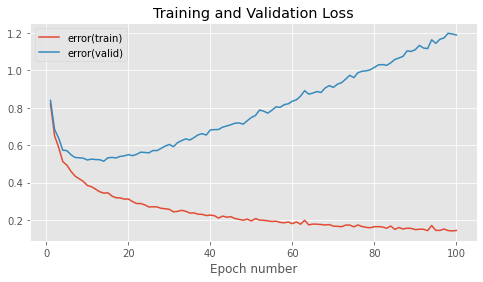

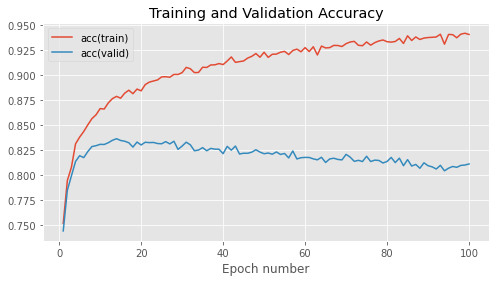

In [3]:
# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

# Initialize weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Define the Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Define the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_init, keys_init, run_time_init, activation_dict_init = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Export values for further analysis
export_values(stats_init, keys_init, run_time_init, activation_dict_init, 'init')

## Task 1: Problem Identification
### a) First identify and discuss the problem shown by the curves in Figure 1 and briefly discuss potential solutions in this section for overcoming this problem.

It's quite evident that there is overfitting mainly due to the number of units, and the number... give further, better descriptions.

### b) Initially you will train various 1-hidden layer networks by using either 32, 64 and 128 ReLU hidden units per layer on EMNIST using stochastic gradient descent (SGD) without any regularization

## Baseline Experiments: Understanding the influence of network width and depth

### _Number of ReLu hidden units:_ **32**

Epoch 1: 1.9s to complete
    error(train)=1.16e+00, acc(train)=6.65e-01, error(valid)=1.17e+00, acc(valid)=6.63e-01


Epoch 2: 1.9s to complete
    error(train)=9.92e-01, acc(train)=7.09e-01, error(valid)=1.01e+00, acc(valid)=7.05e-01


Epoch 3: 2.0s to complete
    error(train)=9.08e-01, acc(train)=7.31e-01, error(valid)=9.33e-01, acc(valid)=7.22e-01


Epoch 4: 1.8s to complete
    error(train)=8.65e-01, acc(train)=7.42e-01, error(valid)=8.93e-01, acc(valid)=7.37e-01


Epoch 5: 1.9s to complete
    error(train)=8.25e-01, acc(train)=7.54e-01, error(valid)=8.58e-01, acc(valid)=7.45e-01


Epoch 6: 1.9s to complete
    error(train)=8.10e-01, acc(train)=7.55e-01, error(valid)=8.50e-01, acc(valid)=7.47e-01


Epoch 7: 1.9s to complete
    error(train)=7.76e-01, acc(train)=7.65e-01, error(valid)=8.21e-01, acc(valid)=7.51e-01


Epoch 8: 1.9s to complete
    error(train)=7.45e-01, acc(train)=7.75e-01, error(valid)=7.91e-01, acc(valid)=7.60e-01


Epoch 9: 2.0s to complete
    error(train)=7.53e-01, acc(train)=7.69e-01, error(valid)=8.03e-01, acc(valid)=7.57e-01


Epoch 10: 2.0s to complete
    error(train)=7.26e-01, acc(train)=7.77e-01, error(valid)=7.78e-01, acc(valid)=7.64e-01


Epoch 11: 2.0s to complete
    error(train)=7.18e-01, acc(train)=7.79e-01, error(valid)=7.74e-01, acc(valid)=7.64e-01


Epoch 12: 2.0s to complete
    error(train)=7.01e-01, acc(train)=7.82e-01, error(valid)=7.60e-01, acc(valid)=7.67e-01


Epoch 13: 2.0s to complete
    error(train)=6.94e-01, acc(train)=7.84e-01, error(valid)=7.57e-01, acc(valid)=7.71e-01


Epoch 14: 2.0s to complete
    error(train)=6.83e-01, acc(train)=7.87e-01, error(valid)=7.52e-01, acc(valid)=7.75e-01


Epoch 15: 2.0s to complete
    error(train)=6.75e-01, acc(train)=7.88e-01, error(valid)=7.41e-01, acc(valid)=7.73e-01


Epoch 16: 2.0s to complete
    error(train)=6.55e-01, acc(train)=7.97e-01, error(valid)=7.28e-01, acc(valid)=7.79e-01


Epoch 17: 2.0s to complete
    error(train)=6.47e-01, acc(train)=7.98e-01, error(valid)=7.24e-01, acc(valid)=7.80e-01


Epoch 18: 2.0s to complete
    error(train)=6.48e-01, acc(train)=7.95e-01, error(valid)=7.25e-01, acc(valid)=7.74e-01


Epoch 19: 2.0s to complete
    error(train)=6.34e-01, acc(train)=8.00e-01, error(valid)=7.15e-01, acc(valid)=7.81e-01


Epoch 20: 1.9s to complete
    error(train)=6.31e-01, acc(train)=8.00e-01, error(valid)=7.13e-01, acc(valid)=7.82e-01


Epoch 21: 2.0s to complete
    error(train)=6.23e-01, acc(train)=8.03e-01, error(valid)=7.08e-01, acc(valid)=7.82e-01


Epoch 22: 2.0s to complete
    error(train)=6.14e-01, acc(train)=8.04e-01, error(valid)=7.02e-01, acc(valid)=7.85e-01


Epoch 23: 1.8s to complete
    error(train)=6.09e-01, acc(train)=8.06e-01, error(valid)=7.00e-01, acc(valid)=7.82e-01


Epoch 24: 1.7s to complete
    error(train)=6.07e-01, acc(train)=8.07e-01, error(valid)=7.01e-01, acc(valid)=7.84e-01


Epoch 25: 2.0s to complete
    error(train)=6.02e-01, acc(train)=8.09e-01, error(valid)=6.98e-01, acc(valid)=7.85e-01


Epoch 26: 2.0s to complete
    error(train)=5.97e-01, acc(train)=8.10e-01, error(valid)=6.95e-01, acc(valid)=7.86e-01


Epoch 27: 2.0s to complete
    error(train)=5.95e-01, acc(train)=8.10e-01, error(valid)=6.91e-01, acc(valid)=7.82e-01


Epoch 28: 1.7s to complete
    error(train)=5.85e-01, acc(train)=8.13e-01, error(valid)=6.81e-01, acc(valid)=7.90e-01


Epoch 29: 2.0s to complete
    error(train)=5.77e-01, acc(train)=8.14e-01, error(valid)=6.78e-01, acc(valid)=7.88e-01


Epoch 30: 2.0s to complete
    error(train)=5.83e-01, acc(train)=8.14e-01, error(valid)=6.86e-01, acc(valid)=7.89e-01


Epoch 31: 2.0s to complete
    error(train)=5.84e-01, acc(train)=8.13e-01, error(valid)=6.92e-01, acc(valid)=7.85e-01


Epoch 32: 2.0s to complete
    error(train)=5.89e-01, acc(train)=8.11e-01, error(valid)=6.96e-01, acc(valid)=7.83e-01


Epoch 33: 2.0s to complete
    error(train)=5.99e-01, acc(train)=8.04e-01, error(valid)=7.04e-01, acc(valid)=7.82e-01


Epoch 34: 2.0s to complete
    error(train)=5.69e-01, acc(train)=8.16e-01, error(valid)=6.75e-01, acc(valid)=7.90e-01


Epoch 35: 2.0s to complete
    error(train)=5.58e-01, acc(train)=8.20e-01, error(valid)=6.65e-01, acc(valid)=7.93e-01


Epoch 36: 2.0s to complete
    error(train)=5.64e-01, acc(train)=8.16e-01, error(valid)=6.72e-01, acc(valid)=7.88e-01


Epoch 37: 2.0s to complete
    error(train)=5.58e-01, acc(train)=8.19e-01, error(valid)=6.71e-01, acc(valid)=7.93e-01


Epoch 38: 2.0s to complete
    error(train)=5.53e-01, acc(train)=8.22e-01, error(valid)=6.67e-01, acc(valid)=7.96e-01


Epoch 39: 2.1s to complete
    error(train)=5.54e-01, acc(train)=8.21e-01, error(valid)=6.70e-01, acc(valid)=7.92e-01


Epoch 40: 2.0s to complete
    error(train)=5.52e-01, acc(train)=8.22e-01, error(valid)=6.65e-01, acc(valid)=7.95e-01


Epoch 41: 2.0s to complete
    error(train)=5.47e-01, acc(train)=8.24e-01, error(valid)=6.60e-01, acc(valid)=7.97e-01


Epoch 42: 2.0s to complete
    error(train)=5.54e-01, acc(train)=8.20e-01, error(valid)=6.72e-01, acc(valid)=7.91e-01


Epoch 43: 2.0s to complete
    error(train)=5.54e-01, acc(train)=8.20e-01, error(valid)=6.72e-01, acc(valid)=7.92e-01


Epoch 44: 2.0s to complete
    error(train)=5.50e-01, acc(train)=8.20e-01, error(valid)=6.71e-01, acc(valid)=7.92e-01


Epoch 45: 2.0s to complete
    error(train)=5.56e-01, acc(train)=8.19e-01, error(valid)=6.76e-01, acc(valid)=7.92e-01


Epoch 46: 2.0s to complete
    error(train)=5.45e-01, acc(train)=8.23e-01, error(valid)=6.68e-01, acc(valid)=7.91e-01


Epoch 47: 1.7s to complete
    error(train)=5.52e-01, acc(train)=8.18e-01, error(valid)=6.78e-01, acc(valid)=7.88e-01


Epoch 48: 1.8s to complete
    error(train)=5.43e-01, acc(train)=8.23e-01, error(valid)=6.67e-01, acc(valid)=7.94e-01


Epoch 49: 1.8s to complete
    error(train)=5.34e-01, acc(train)=8.27e-01, error(valid)=6.62e-01, acc(valid)=7.96e-01


Epoch 50: 2.0s to complete
    error(train)=5.40e-01, acc(train)=8.26e-01, error(valid)=6.73e-01, acc(valid)=7.93e-01


Epoch 51: 2.0s to complete
    error(train)=5.46e-01, acc(train)=8.22e-01, error(valid)=6.75e-01, acc(valid)=7.90e-01


Epoch 52: 2.0s to complete
    error(train)=5.40e-01, acc(train)=8.23e-01, error(valid)=6.69e-01, acc(valid)=7.90e-01


Epoch 53: 2.0s to complete
    error(train)=5.27e-01, acc(train)=8.28e-01, error(valid)=6.60e-01, acc(valid)=7.96e-01


Epoch 54: 2.0s to complete
    error(train)=5.48e-01, acc(train)=8.19e-01, error(valid)=6.80e-01, acc(valid)=7.89e-01


Epoch 55: 2.0s to complete
    error(train)=5.33e-01, acc(train)=8.25e-01, error(valid)=6.67e-01, acc(valid)=7.94e-01


Epoch 56: 1.7s to complete
    error(train)=5.34e-01, acc(train)=8.25e-01, error(valid)=6.72e-01, acc(valid)=7.92e-01


Epoch 57: 2.0s to complete
    error(train)=5.34e-01, acc(train)=8.24e-01, error(valid)=6.71e-01, acc(valid)=7.93e-01


Epoch 58: 2.0s to complete
    error(train)=5.29e-01, acc(train)=8.27e-01, error(valid)=6.66e-01, acc(valid)=7.94e-01


Epoch 59: 2.0s to complete
    error(train)=5.27e-01, acc(train)=8.26e-01, error(valid)=6.64e-01, acc(valid)=7.97e-01


Epoch 60: 2.0s to complete
    error(train)=5.34e-01, acc(train)=8.24e-01, error(valid)=6.75e-01, acc(valid)=7.94e-01


Epoch 61: 2.0s to complete
    error(train)=5.20e-01, acc(train)=8.29e-01, error(valid)=6.63e-01, acc(valid)=7.97e-01


Epoch 62: 2.0s to complete
    error(train)=5.30e-01, acc(train)=8.26e-01, error(valid)=6.70e-01, acc(valid)=7.92e-01


Epoch 63: 2.0s to complete
    error(train)=5.31e-01, acc(train)=8.25e-01, error(valid)=6.77e-01, acc(valid)=7.92e-01


Epoch 64: 2.0s to complete
    error(train)=5.21e-01, acc(train)=8.29e-01, error(valid)=6.64e-01, acc(valid)=7.97e-01


Epoch 65: 2.1s to complete
    error(train)=5.31e-01, acc(train)=8.26e-01, error(valid)=6.76e-01, acc(valid)=7.91e-01


Epoch 66: 2.0s to complete
    error(train)=5.16e-01, acc(train)=8.29e-01, error(valid)=6.58e-01, acc(valid)=7.96e-01


Epoch 67: 2.0s to complete
    error(train)=5.14e-01, acc(train)=8.31e-01, error(valid)=6.60e-01, acc(valid)=7.99e-01


Epoch 68: 2.1s to complete
    error(train)=5.18e-01, acc(train)=8.30e-01, error(valid)=6.61e-01, acc(valid)=7.97e-01


Epoch 69: 2.0s to complete
    error(train)=5.16e-01, acc(train)=8.30e-01, error(valid)=6.61e-01, acc(valid)=7.97e-01


Epoch 70: 2.0s to complete
    error(train)=5.20e-01, acc(train)=8.30e-01, error(valid)=6.69e-01, acc(valid)=7.92e-01


Epoch 71: 2.0s to complete
    error(train)=5.10e-01, acc(train)=8.32e-01, error(valid)=6.66e-01, acc(valid)=7.97e-01


Epoch 72: 2.0s to complete
    error(train)=5.13e-01, acc(train)=8.31e-01, error(valid)=6.65e-01, acc(valid)=7.99e-01


Epoch 73: 2.0s to complete
    error(train)=5.10e-01, acc(train)=8.32e-01, error(valid)=6.63e-01, acc(valid)=7.95e-01


Epoch 74: 2.0s to complete
    error(train)=5.12e-01, acc(train)=8.32e-01, error(valid)=6.65e-01, acc(valid)=7.96e-01


Epoch 75: 2.0s to complete
    error(train)=5.20e-01, acc(train)=8.27e-01, error(valid)=6.79e-01, acc(valid)=7.91e-01


Epoch 76: 2.0s to complete
    error(train)=5.06e-01, acc(train)=8.32e-01, error(valid)=6.64e-01, acc(valid)=7.95e-01


Epoch 77: 2.0s to complete
    error(train)=5.08e-01, acc(train)=8.31e-01, error(valid)=6.67e-01, acc(valid)=7.96e-01


Epoch 78: 2.0s to complete
    error(train)=5.10e-01, acc(train)=8.31e-01, error(valid)=6.67e-01, acc(valid)=7.93e-01


Epoch 79: 2.0s to complete
    error(train)=5.00e-01, acc(train)=8.35e-01, error(valid)=6.60e-01, acc(valid)=7.97e-01


Epoch 80: 2.0s to complete
    error(train)=4.97e-01, acc(train)=8.36e-01, error(valid)=6.58e-01, acc(valid)=7.95e-01


Epoch 81: 2.0s to complete
    error(train)=5.03e-01, acc(train)=8.34e-01, error(valid)=6.61e-01, acc(valid)=7.98e-01


Epoch 82: 2.1s to complete
    error(train)=5.02e-01, acc(train)=8.34e-01, error(valid)=6.65e-01, acc(valid)=7.97e-01


Epoch 83: 1.7s to complete
    error(train)=4.98e-01, acc(train)=8.35e-01, error(valid)=6.62e-01, acc(valid)=7.95e-01


Epoch 84: 1.9s to complete
    error(train)=5.02e-01, acc(train)=8.33e-01, error(valid)=6.67e-01, acc(valid)=7.96e-01


Epoch 85: 2.0s to complete
    error(train)=5.16e-01, acc(train)=8.30e-01, error(valid)=6.85e-01, acc(valid)=7.93e-01


Epoch 86: 1.9s to complete
    error(train)=4.98e-01, acc(train)=8.36e-01, error(valid)=6.65e-01, acc(valid)=7.96e-01


Epoch 87: 2.0s to complete
    error(train)=5.00e-01, acc(train)=8.34e-01, error(valid)=6.67e-01, acc(valid)=7.96e-01


Epoch 88: 2.0s to complete
    error(train)=5.03e-01, acc(train)=8.32e-01, error(valid)=6.72e-01, acc(valid)=7.94e-01


Epoch 89: 2.0s to complete
    error(train)=4.95e-01, acc(train)=8.36e-01, error(valid)=6.63e-01, acc(valid)=7.97e-01


Epoch 90: 2.0s to complete
    error(train)=5.00e-01, acc(train)=8.35e-01, error(valid)=6.70e-01, acc(valid)=7.96e-01


Epoch 91: 2.0s to complete
    error(train)=4.93e-01, acc(train)=8.36e-01, error(valid)=6.65e-01, acc(valid)=7.98e-01


Epoch 92: 2.0s to complete
    error(train)=4.91e-01, acc(train)=8.39e-01, error(valid)=6.63e-01, acc(valid)=8.01e-01


Epoch 93: 2.0s to complete
    error(train)=4.93e-01, acc(train)=8.37e-01, error(valid)=6.67e-01, acc(valid)=7.97e-01


Epoch 94: 2.0s to complete
    error(train)=4.93e-01, acc(train)=8.37e-01, error(valid)=6.71e-01, acc(valid)=7.94e-01


Epoch 95: 2.0s to complete
    error(train)=5.05e-01, acc(train)=8.32e-01, error(valid)=6.81e-01, acc(valid)=7.90e-01


Epoch 96: 2.0s to complete
    error(train)=4.89e-01, acc(train)=8.38e-01, error(valid)=6.64e-01, acc(valid)=7.98e-01


Epoch 97: 2.0s to complete
    error(train)=4.96e-01, acc(train)=8.35e-01, error(valid)=6.74e-01, acc(valid)=7.95e-01


Epoch 98: 2.0s to complete
    error(train)=4.96e-01, acc(train)=8.34e-01, error(valid)=6.73e-01, acc(valid)=7.95e-01


Epoch 99: 2.0s to complete
    error(train)=4.88e-01, acc(train)=8.38e-01, error(valid)=6.68e-01, acc(valid)=7.98e-01


Epoch 100: 2.1s to complete
    error(train)=4.81e-01, acc(train)=8.39e-01, error(valid)=6.63e-01, acc(valid)=7.98e-01


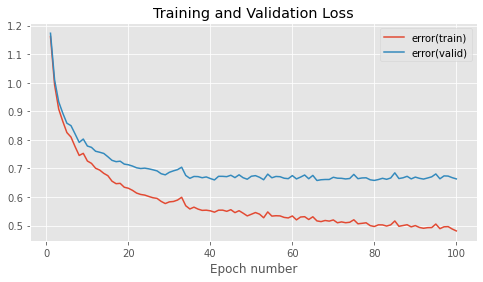

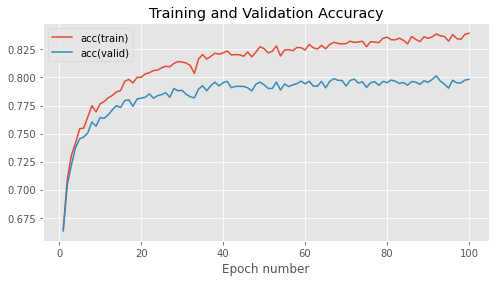

In [4]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 32 # 32 Hidden Units fed into the ReLu activation function

# Initialize weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Define Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Define Error function
error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_hu_32, keys_hu_32, run_time_hu_32, activation_dict_hu_32 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_hu_32, keys_hu_32, run_time_hu_32, activation_dict_hu_32, 'hu_32')

### _Number of ReLu hidden units:_ **64**

Epoch 1: 2.5s to complete
    error(train)=9.69e-01, acc(train)=7.14e-01, error(valid)=9.86e-01, acc(valid)=7.05e-01


Epoch 2: 2.4s to complete
    error(train)=7.64e-01, acc(train)=7.70e-01, error(valid)=7.96e-01, acc(valid)=7.58e-01


Epoch 3: 2.5s to complete
    error(train)=6.92e-01, acc(train)=7.84e-01, error(valid)=7.36e-01, acc(valid)=7.71e-01


Epoch 4: 2.4s to complete
    error(train)=6.25e-01, acc(train)=8.03e-01, error(valid)=6.76e-01, acc(valid)=7.90e-01


Epoch 5: 2.5s to complete
    error(train)=5.87e-01, acc(train)=8.12e-01, error(valid)=6.45e-01, acc(valid)=7.98e-01


Epoch 6: 2.3s to complete
    error(train)=5.60e-01, acc(train)=8.20e-01, error(valid)=6.25e-01, acc(valid)=7.99e-01


Epoch 7: 2.3s to complete
    error(train)=5.33e-01, acc(train)=8.27e-01, error(valid)=6.09e-01, acc(valid)=8.08e-01


Epoch 8: 2.4s to complete
    error(train)=5.19e-01, acc(train)=8.31e-01, error(valid)=5.98e-01, acc(valid)=8.13e-01


Epoch 9: 2.5s to complete
    error(train)=5.00e-01, acc(train)=8.31e-01, error(valid)=5.92e-01, acc(valid)=8.05e-01


Epoch 10: 2.4s to complete
    error(train)=4.91e-01, acc(train)=8.36e-01, error(valid)=5.92e-01, acc(valid)=8.09e-01


Epoch 11: 2.6s to complete
    error(train)=4.81e-01, acc(train)=8.39e-01, error(valid)=5.85e-01, acc(valid)=8.13e-01


Epoch 12: 2.6s to complete
    error(train)=4.51e-01, acc(train)=8.49e-01, error(valid)=5.65e-01, acc(valid)=8.19e-01


Epoch 13: 2.5s to complete
    error(train)=4.47e-01, acc(train)=8.50e-01, error(valid)=5.62e-01, acc(valid)=8.21e-01


Epoch 14: 2.6s to complete
    error(train)=4.41e-01, acc(train)=8.51e-01, error(valid)=5.64e-01, acc(valid)=8.19e-01


Epoch 15: 2.5s to complete
    error(train)=4.25e-01, acc(train)=8.57e-01, error(valid)=5.61e-01, acc(valid)=8.26e-01


Epoch 16: 2.5s to complete
    error(train)=4.29e-01, acc(train)=8.54e-01, error(valid)=5.66e-01, acc(valid)=8.19e-01


Epoch 17: 2.6s to complete
    error(train)=4.19e-01, acc(train)=8.58e-01, error(valid)=5.61e-01, acc(valid)=8.24e-01


Epoch 18: 2.6s to complete
    error(train)=4.11e-01, acc(train)=8.59e-01, error(valid)=5.61e-01, acc(valid)=8.23e-01


Epoch 19: 2.6s to complete
    error(train)=4.08e-01, acc(train)=8.61e-01, error(valid)=5.60e-01, acc(valid)=8.25e-01


Epoch 20: 2.5s to complete
    error(train)=4.07e-01, acc(train)=8.60e-01, error(valid)=5.67e-01, acc(valid)=8.23e-01


Epoch 21: 2.4s to complete
    error(train)=4.05e-01, acc(train)=8.60e-01, error(valid)=5.70e-01, acc(valid)=8.19e-01


Epoch 22: 2.2s to complete
    error(train)=3.92e-01, acc(train)=8.64e-01, error(valid)=5.61e-01, acc(valid)=8.23e-01


Epoch 23: 2.4s to complete
    error(train)=4.01e-01, acc(train)=8.58e-01, error(valid)=5.79e-01, acc(valid)=8.15e-01


Epoch 24: 2.7s to complete
    error(train)=3.99e-01, acc(train)=8.58e-01, error(valid)=5.79e-01, acc(valid)=8.18e-01


Epoch 25: 2.4s to complete
    error(train)=3.74e-01, acc(train)=8.70e-01, error(valid)=5.61e-01, acc(valid)=8.28e-01


Epoch 26: 2.5s to complete
    error(train)=3.77e-01, acc(train)=8.70e-01, error(valid)=5.73e-01, acc(valid)=8.23e-01


Epoch 27: 2.5s to complete
    error(train)=3.85e-01, acc(train)=8.65e-01, error(valid)=5.84e-01, acc(valid)=8.20e-01


Epoch 28: 2.5s to complete
    error(train)=3.70e-01, acc(train)=8.71e-01, error(valid)=5.73e-01, acc(valid)=8.23e-01


Epoch 29: 2.6s to complete
    error(train)=3.70e-01, acc(train)=8.70e-01, error(valid)=5.75e-01, acc(valid)=8.21e-01


Epoch 30: 2.5s to complete
    error(train)=3.64e-01, acc(train)=8.72e-01, error(valid)=5.75e-01, acc(valid)=8.22e-01


Epoch 31: 2.6s to complete
    error(train)=3.59e-01, acc(train)=8.74e-01, error(valid)=5.79e-01, acc(valid)=8.27e-01


Epoch 32: 2.6s to complete
    error(train)=3.65e-01, acc(train)=8.69e-01, error(valid)=5.86e-01, acc(valid)=8.20e-01


Epoch 33: 2.6s to complete
    error(train)=3.48e-01, acc(train)=8.77e-01, error(valid)=5.76e-01, acc(valid)=8.26e-01


Epoch 34: 2.5s to complete
    error(train)=3.55e-01, acc(train)=8.75e-01, error(valid)=5.89e-01, acc(valid)=8.23e-01


Epoch 35: 2.5s to complete
    error(train)=3.50e-01, acc(train)=8.76e-01, error(valid)=5.88e-01, acc(valid)=8.22e-01


Epoch 36: 2.6s to complete
    error(train)=3.47e-01, acc(train)=8.76e-01, error(valid)=5.91e-01, acc(valid)=8.24e-01


Epoch 37: 2.6s to complete
    error(train)=3.63e-01, acc(train)=8.70e-01, error(valid)=6.02e-01, acc(valid)=8.18e-01


Epoch 38: 2.6s to complete
    error(train)=3.47e-01, acc(train)=8.76e-01, error(valid)=5.94e-01, acc(valid)=8.22e-01


Epoch 39: 2.6s to complete
    error(train)=3.40e-01, acc(train)=8.76e-01, error(valid)=5.94e-01, acc(valid)=8.21e-01


Epoch 40: 2.6s to complete
    error(train)=3.39e-01, acc(train)=8.77e-01, error(valid)=6.05e-01, acc(valid)=8.20e-01


Epoch 41: 2.6s to complete
    error(train)=3.38e-01, acc(train)=8.79e-01, error(valid)=5.97e-01, acc(valid)=8.24e-01


Epoch 42: 2.6s to complete
    error(train)=3.22e-01, acc(train)=8.83e-01, error(valid)=5.90e-01, acc(valid)=8.24e-01


Epoch 43: 2.5s to complete
    error(train)=3.48e-01, acc(train)=8.75e-01, error(valid)=6.17e-01, acc(valid)=8.21e-01


Epoch 44: 2.5s to complete
    error(train)=3.22e-01, acc(train)=8.85e-01, error(valid)=5.92e-01, acc(valid)=8.24e-01


Epoch 45: 2.5s to complete
    error(train)=3.39e-01, acc(train)=8.77e-01, error(valid)=6.23e-01, acc(valid)=8.18e-01


Epoch 46: 2.7s to complete
    error(train)=3.19e-01, acc(train)=8.84e-01, error(valid)=6.06e-01, acc(valid)=8.20e-01


Epoch 47: 2.6s to complete
    error(train)=3.24e-01, acc(train)=8.83e-01, error(valid)=6.21e-01, acc(valid)=8.21e-01


Epoch 48: 2.5s to complete
    error(train)=3.15e-01, acc(train)=8.86e-01, error(valid)=6.10e-01, acc(valid)=8.25e-01


Epoch 49: 2.6s to complete
    error(train)=3.11e-01, acc(train)=8.88e-01, error(valid)=6.16e-01, acc(valid)=8.24e-01


Epoch 50: 2.3s to complete
    error(train)=3.10e-01, acc(train)=8.88e-01, error(valid)=6.07e-01, acc(valid)=8.25e-01


Epoch 51: 2.4s to complete
    error(train)=3.17e-01, acc(train)=8.85e-01, error(valid)=6.30e-01, acc(valid)=8.20e-01


Epoch 52: 2.8s to complete
    error(train)=3.07e-01, acc(train)=8.87e-01, error(valid)=6.19e-01, acc(valid)=8.21e-01


Epoch 53: 2.6s to complete
    error(train)=3.02e-01, acc(train)=8.91e-01, error(valid)=6.21e-01, acc(valid)=8.23e-01


Epoch 54: 2.5s to complete
    error(train)=3.04e-01, acc(train)=8.90e-01, error(valid)=6.28e-01, acc(valid)=8.20e-01


Epoch 55: 2.5s to complete
    error(train)=3.04e-01, acc(train)=8.89e-01, error(valid)=6.28e-01, acc(valid)=8.20e-01


Epoch 56: 2.6s to complete
    error(train)=2.95e-01, acc(train)=8.92e-01, error(valid)=6.31e-01, acc(valid)=8.22e-01


Epoch 57: 2.6s to complete
    error(train)=3.03e-01, acc(train)=8.89e-01, error(valid)=6.40e-01, acc(valid)=8.22e-01


Epoch 58: 2.6s to complete
    error(train)=3.01e-01, acc(train)=8.90e-01, error(valid)=6.33e-01, acc(valid)=8.24e-01


Epoch 59: 2.6s to complete
    error(train)=2.96e-01, acc(train)=8.91e-01, error(valid)=6.48e-01, acc(valid)=8.19e-01


Epoch 60: 2.6s to complete
    error(train)=3.12e-01, acc(train)=8.86e-01, error(valid)=6.67e-01, acc(valid)=8.15e-01


Epoch 61: 2.6s to complete
    error(train)=3.03e-01, acc(train)=8.88e-01, error(valid)=6.62e-01, acc(valid)=8.20e-01


Epoch 62: 2.6s to complete
    error(train)=2.95e-01, acc(train)=8.93e-01, error(valid)=6.58e-01, acc(valid)=8.21e-01


Epoch 63: 2.5s to complete
    error(train)=2.99e-01, acc(train)=8.90e-01, error(valid)=6.69e-01, acc(valid)=8.19e-01


Epoch 64: 2.5s to complete
    error(train)=2.90e-01, acc(train)=8.93e-01, error(valid)=6.59e-01, acc(valid)=8.19e-01


Epoch 65: 2.5s to complete
    error(train)=2.96e-01, acc(train)=8.90e-01, error(valid)=6.69e-01, acc(valid)=8.19e-01


Epoch 66: 2.4s to complete
    error(train)=2.91e-01, acc(train)=8.92e-01, error(valid)=6.66e-01, acc(valid)=8.18e-01


Epoch 67: 2.6s to complete
    error(train)=2.93e-01, acc(train)=8.92e-01, error(valid)=6.67e-01, acc(valid)=8.19e-01


Epoch 68: 2.6s to complete
    error(train)=2.90e-01, acc(train)=8.91e-01, error(valid)=6.86e-01, acc(valid)=8.14e-01


Epoch 69: 2.4s to complete
    error(train)=2.91e-01, acc(train)=8.92e-01, error(valid)=6.78e-01, acc(valid)=8.17e-01


Epoch 70: 2.3s to complete
    error(train)=3.07e-01, acc(train)=8.86e-01, error(valid)=7.03e-01, acc(valid)=8.15e-01


Epoch 71: 2.5s to complete
    error(train)=2.83e-01, acc(train)=8.94e-01, error(valid)=6.71e-01, acc(valid)=8.17e-01


Epoch 72: 2.7s to complete
    error(train)=2.83e-01, acc(train)=8.95e-01, error(valid)=6.89e-01, acc(valid)=8.18e-01


Epoch 73: 2.6s to complete
    error(train)=2.74e-01, acc(train)=9.00e-01, error(valid)=6.78e-01, acc(valid)=8.18e-01


Epoch 74: 2.6s to complete
    error(train)=2.76e-01, acc(train)=8.98e-01, error(valid)=6.84e-01, acc(valid)=8.20e-01


Epoch 75: 2.6s to complete
    error(train)=2.89e-01, acc(train)=8.93e-01, error(valid)=7.13e-01, acc(valid)=8.14e-01


Epoch 76: 2.6s to complete
    error(train)=2.80e-01, acc(train)=8.95e-01, error(valid)=6.94e-01, acc(valid)=8.16e-01


Epoch 77: 2.6s to complete
    error(train)=2.75e-01, acc(train)=8.98e-01, error(valid)=7.08e-01, acc(valid)=8.16e-01


Epoch 78: 2.6s to complete
    error(train)=2.78e-01, acc(train)=8.96e-01, error(valid)=7.09e-01, acc(valid)=8.17e-01


Epoch 79: 2.6s to complete
    error(train)=2.69e-01, acc(train)=9.00e-01, error(valid)=7.00e-01, acc(valid)=8.21e-01


Epoch 80: 2.5s to complete
    error(train)=2.80e-01, acc(train)=8.97e-01, error(valid)=7.12e-01, acc(valid)=8.18e-01


Epoch 81: 2.6s to complete
    error(train)=2.65e-01, acc(train)=9.02e-01, error(valid)=7.05e-01, acc(valid)=8.16e-01


Epoch 82: 2.6s to complete
    error(train)=2.66e-01, acc(train)=9.02e-01, error(valid)=7.08e-01, acc(valid)=8.18e-01


Epoch 83: 2.6s to complete
    error(train)=2.74e-01, acc(train)=8.96e-01, error(valid)=7.18e-01, acc(valid)=8.09e-01


Epoch 84: 2.6s to complete
    error(train)=2.63e-01, acc(train)=9.02e-01, error(valid)=7.10e-01, acc(valid)=8.16e-01


Epoch 85: 2.7s to complete
    error(train)=2.80e-01, acc(train)=8.94e-01, error(valid)=7.37e-01, acc(valid)=8.08e-01


Epoch 86: 2.5s to complete
    error(train)=2.72e-01, acc(train)=8.98e-01, error(valid)=7.24e-01, acc(valid)=8.15e-01


Epoch 87: 2.6s to complete
    error(train)=2.66e-01, acc(train)=9.01e-01, error(valid)=7.27e-01, acc(valid)=8.13e-01


Epoch 88: 2.6s to complete
    error(train)=2.68e-01, acc(train)=9.00e-01, error(valid)=7.37e-01, acc(valid)=8.14e-01


Epoch 89: 2.6s to complete
    error(train)=2.75e-01, acc(train)=8.95e-01, error(valid)=7.43e-01, acc(valid)=8.09e-01


Epoch 90: 2.6s to complete
    error(train)=2.62e-01, acc(train)=9.02e-01, error(valid)=7.40e-01, acc(valid)=8.14e-01


Epoch 91: 2.6s to complete
    error(train)=2.69e-01, acc(train)=8.98e-01, error(valid)=7.52e-01, acc(valid)=8.11e-01


Epoch 92: 2.5s to complete
    error(train)=2.63e-01, acc(train)=9.02e-01, error(valid)=7.40e-01, acc(valid)=8.14e-01


Epoch 93: 2.2s to complete
    error(train)=2.66e-01, acc(train)=8.99e-01, error(valid)=7.61e-01, acc(valid)=8.10e-01


Epoch 94: 2.6s to complete
    error(train)=2.61e-01, acc(train)=9.02e-01, error(valid)=7.55e-01, acc(valid)=8.15e-01


Epoch 95: 2.6s to complete
    error(train)=2.68e-01, acc(train)=8.98e-01, error(valid)=7.61e-01, acc(valid)=8.13e-01


Epoch 96: 2.6s to complete
    error(train)=2.65e-01, acc(train)=9.00e-01, error(valid)=7.67e-01, acc(valid)=8.14e-01


Epoch 97: 2.6s to complete
    error(train)=2.59e-01, acc(train)=9.02e-01, error(valid)=7.64e-01, acc(valid)=8.12e-01


Epoch 98: 2.6s to complete
    error(train)=2.58e-01, acc(train)=9.01e-01, error(valid)=7.66e-01, acc(valid)=8.12e-01


Epoch 99: 2.5s to complete
    error(train)=2.49e-01, acc(train)=9.06e-01, error(valid)=7.55e-01, acc(valid)=8.12e-01


Epoch 100: 2.5s to complete
    error(train)=2.53e-01, acc(train)=9.05e-01, error(valid)=7.73e-01, acc(valid)=8.12e-01


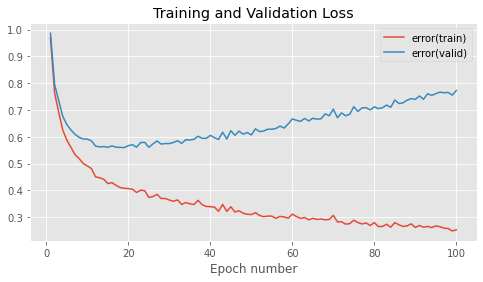

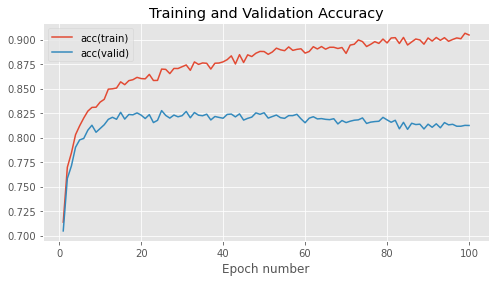

In [5]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 64 # 64 Hidden Units fed into the ReLu activation function

# Initialize weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Define Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Define error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_hu_64, keys_hu_64, run_time_hu_64, activation_dict_hu_64 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_hu_64, keys_hu_64, run_time_hu_64, activation_dict_hu_64, 'hu_64')

### _Number of ReLu hidden units:_ **128**

Epoch 1: 3.7s to complete
    error(train)=7.58e-01, acc(train)=7.72e-01, error(valid)=7.75e-01, acc(valid)=7.67e-01


Epoch 2: 3.6s to complete
    error(train)=5.82e-01, acc(train)=8.14e-01, error(valid)=6.23e-01, acc(valid)=7.99e-01


Epoch 3: 3.3s to complete
    error(train)=5.10e-01, acc(train)=8.32e-01, error(valid)=5.64e-01, acc(valid)=8.17e-01


Epoch 4: 3.2s to complete
    error(train)=4.71e-01, acc(train)=8.39e-01, error(valid)=5.42e-01, acc(valid)=8.18e-01


Epoch 5: 3.6s to complete
    error(train)=4.12e-01, acc(train)=8.60e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


Epoch 6: 3.6s to complete
    error(train)=4.02e-01, acc(train)=8.61e-01, error(valid)=5.04e-01, acc(valid)=8.34e-01


Epoch 7: 3.8s to complete
    error(train)=3.90e-01, acc(train)=8.63e-01, error(valid)=5.09e-01, acc(valid)=8.32e-01


Epoch 8: 4.0s to complete
    error(train)=3.58e-01, acc(train)=8.74e-01, error(valid)=4.95e-01, acc(valid)=8.36e-01


Epoch 9: 3.9s to complete
    error(train)=3.41e-01, acc(train)=8.77e-01, error(valid)=4.95e-01, acc(valid)=8.37e-01


Epoch 10: 4.0s to complete
    error(train)=3.31e-01, acc(train)=8.81e-01, error(valid)=4.97e-01, acc(valid)=8.37e-01


Epoch 11: 3.8s to complete
    error(train)=3.14e-01, acc(train)=8.87e-01, error(valid)=4.98e-01, acc(valid)=8.41e-01


Epoch 12: 3.9s to complete
    error(train)=3.10e-01, acc(train)=8.85e-01, error(valid)=5.03e-01, acc(valid)=8.36e-01


Epoch 13: 3.8s to complete
    error(train)=3.09e-01, acc(train)=8.84e-01, error(valid)=5.21e-01, acc(valid)=8.33e-01


Epoch 14: 3.7s to complete
    error(train)=2.81e-01, acc(train)=8.96e-01, error(valid)=5.13e-01, acc(valid)=8.39e-01


Epoch 15: 3.9s to complete
    error(train)=2.74e-01, acc(train)=8.97e-01, error(valid)=5.13e-01, acc(valid)=8.39e-01


Epoch 16: 4.0s to complete
    error(train)=2.63e-01, acc(train)=9.01e-01, error(valid)=5.18e-01, acc(valid)=8.40e-01


Epoch 17: 3.8s to complete
    error(train)=2.48e-01, acc(train)=9.07e-01, error(valid)=5.16e-01, acc(valid)=8.42e-01


Epoch 18: 3.9s to complete
    error(train)=2.54e-01, acc(train)=9.04e-01, error(valid)=5.41e-01, acc(valid)=8.38e-01


Epoch 19: 3.9s to complete
    error(train)=2.45e-01, acc(train)=9.07e-01, error(valid)=5.43e-01, acc(valid)=8.37e-01


Epoch 20: 3.8s to complete
    error(train)=2.45e-01, acc(train)=9.05e-01, error(valid)=5.64e-01, acc(valid)=8.34e-01


Epoch 21: 3.9s to complete
    error(train)=2.32e-01, acc(train)=9.11e-01, error(valid)=5.67e-01, acc(valid)=8.38e-01


Epoch 22: 3.8s to complete
    error(train)=2.29e-01, acc(train)=9.10e-01, error(valid)=5.65e-01, acc(valid)=8.37e-01


Epoch 23: 3.6s to complete
    error(train)=2.19e-01, acc(train)=9.16e-01, error(valid)=5.89e-01, acc(valid)=8.30e-01


Epoch 24: 3.5s to complete
    error(train)=2.20e-01, acc(train)=9.13e-01, error(valid)=5.86e-01, acc(valid)=8.34e-01


Epoch 25: 3.9s to complete
    error(train)=2.20e-01, acc(train)=9.11e-01, error(valid)=6.01e-01, acc(valid)=8.31e-01


Epoch 26: 3.8s to complete
    error(train)=2.05e-01, acc(train)=9.19e-01, error(valid)=6.17e-01, acc(valid)=8.34e-01


Epoch 27: 3.8s to complete
    error(train)=2.00e-01, acc(train)=9.21e-01, error(valid)=6.26e-01, acc(valid)=8.31e-01


Epoch 28: 3.8s to complete
    error(train)=2.13e-01, acc(train)=9.15e-01, error(valid)=6.48e-01, acc(valid)=8.28e-01


Epoch 29: 3.8s to complete
    error(train)=1.96e-01, acc(train)=9.23e-01, error(valid)=6.44e-01, acc(valid)=8.32e-01


Epoch 30: 3.8s to complete
    error(train)=2.03e-01, acc(train)=9.19e-01, error(valid)=6.71e-01, acc(valid)=8.28e-01


Epoch 31: 3.8s to complete
    error(train)=1.85e-01, acc(train)=9.26e-01, error(valid)=6.69e-01, acc(valid)=8.36e-01


Epoch 32: 3.4s to complete
    error(train)=1.89e-01, acc(train)=9.25e-01, error(valid)=7.03e-01, acc(valid)=8.29e-01


Epoch 33: 3.5s to complete
    error(train)=1.83e-01, acc(train)=9.26e-01, error(valid)=7.08e-01, acc(valid)=8.28e-01


Epoch 34: 3.6s to complete
    error(train)=1.83e-01, acc(train)=9.26e-01, error(valid)=7.16e-01, acc(valid)=8.29e-01


Epoch 35: 3.9s to complete
    error(train)=1.79e-01, acc(train)=9.29e-01, error(valid)=7.26e-01, acc(valid)=8.34e-01


Epoch 36: 3.8s to complete
    error(train)=1.69e-01, acc(train)=9.31e-01, error(valid)=7.37e-01, acc(valid)=8.32e-01


Epoch 37: 3.9s to complete
    error(train)=1.74e-01, acc(train)=9.29e-01, error(valid)=7.66e-01, acc(valid)=8.26e-01


Epoch 38: 3.6s to complete
    error(train)=1.80e-01, acc(train)=9.27e-01, error(valid)=7.97e-01, acc(valid)=8.23e-01


Epoch 39: 3.6s to complete
    error(train)=1.66e-01, acc(train)=9.34e-01, error(valid)=7.87e-01, acc(valid)=8.26e-01


Epoch 40: 3.8s to complete
    error(train)=1.59e-01, acc(train)=9.36e-01, error(valid)=7.84e-01, acc(valid)=8.29e-01


Epoch 41: 4.0s to complete
    error(train)=1.61e-01, acc(train)=9.35e-01, error(valid)=8.13e-01, acc(valid)=8.25e-01


Epoch 42: 3.8s to complete
    error(train)=1.58e-01, acc(train)=9.36e-01, error(valid)=8.34e-01, acc(valid)=8.28e-01


Epoch 43: 4.0s to complete
    error(train)=1.63e-01, acc(train)=9.32e-01, error(valid)=8.39e-01, acc(valid)=8.20e-01


Epoch 44: 4.0s to complete
    error(train)=1.51e-01, acc(train)=9.39e-01, error(valid)=8.60e-01, acc(valid)=8.28e-01


Epoch 45: 3.9s to complete
    error(train)=1.56e-01, acc(train)=9.35e-01, error(valid)=8.67e-01, acc(valid)=8.22e-01


Epoch 46: 3.9s to complete
    error(train)=1.51e-01, acc(train)=9.37e-01, error(valid)=8.70e-01, acc(valid)=8.26e-01


Epoch 47: 3.8s to complete
    error(train)=1.46e-01, acc(train)=9.41e-01, error(valid)=8.89e-01, acc(valid)=8.22e-01


Epoch 48: 3.8s to complete
    error(train)=1.50e-01, acc(train)=9.38e-01, error(valid)=9.18e-01, acc(valid)=8.25e-01


Epoch 49: 3.8s to complete
    error(train)=1.39e-01, acc(train)=9.43e-01, error(valid)=9.17e-01, acc(valid)=8.26e-01


Epoch 50: 3.4s to complete
    error(train)=1.34e-01, acc(train)=9.45e-01, error(valid)=9.25e-01, acc(valid)=8.25e-01


Epoch 51: 3.5s to complete
    error(train)=1.38e-01, acc(train)=9.44e-01, error(valid)=9.28e-01, acc(valid)=8.27e-01


Epoch 52: 3.9s to complete
    error(train)=1.38e-01, acc(train)=9.43e-01, error(valid)=9.52e-01, acc(valid)=8.24e-01


Epoch 53: 3.9s to complete
    error(train)=1.33e-01, acc(train)=9.45e-01, error(valid)=9.68e-01, acc(valid)=8.24e-01


Epoch 54: 3.9s to complete
    error(train)=1.39e-01, acc(train)=9.44e-01, error(valid)=9.87e-01, acc(valid)=8.26e-01


Epoch 55: 3.9s to complete
    error(train)=1.34e-01, acc(train)=9.44e-01, error(valid)=9.90e-01, acc(valid)=8.23e-01


Epoch 56: 3.8s to complete
    error(train)=1.33e-01, acc(train)=9.46e-01, error(valid)=1.00e+00, acc(valid)=8.24e-01


Epoch 57: 3.7s to complete
    error(train)=1.28e-01, acc(train)=9.46e-01, error(valid)=1.00e+00, acc(valid)=8.22e-01


Epoch 58: 3.8s to complete
    error(train)=1.29e-01, acc(train)=9.46e-01, error(valid)=1.03e+00, acc(valid)=8.23e-01


Epoch 59: 3.8s to complete
    error(train)=1.28e-01, acc(train)=9.47e-01, error(valid)=1.05e+00, acc(valid)=8.22e-01


Epoch 60: 3.8s to complete
    error(train)=1.31e-01, acc(train)=9.46e-01, error(valid)=1.08e+00, acc(valid)=8.21e-01


Epoch 61: 3.8s to complete
    error(train)=1.13e-01, acc(train)=9.53e-01, error(valid)=1.07e+00, acc(valid)=8.25e-01


Epoch 62: 3.9s to complete
    error(train)=1.29e-01, acc(train)=9.47e-01, error(valid)=1.09e+00, acc(valid)=8.23e-01


Epoch 63: 4.0s to complete
    error(train)=1.38e-01, acc(train)=9.43e-01, error(valid)=1.11e+00, acc(valid)=8.21e-01


Epoch 64: 4.0s to complete
    error(train)=1.38e-01, acc(train)=9.44e-01, error(valid)=1.12e+00, acc(valid)=8.16e-01


Epoch 65: 3.9s to complete
    error(train)=1.28e-01, acc(train)=9.48e-01, error(valid)=1.12e+00, acc(valid)=8.18e-01


Epoch 66: 3.9s to complete
    error(train)=1.14e-01, acc(train)=9.53e-01, error(valid)=1.12e+00, acc(valid)=8.23e-01


Epoch 67: 3.8s to complete
    error(train)=1.22e-01, acc(train)=9.51e-01, error(valid)=1.17e+00, acc(valid)=8.17e-01


Epoch 68: 4.0s to complete
    error(train)=1.14e-01, acc(train)=9.53e-01, error(valid)=1.17e+00, acc(valid)=8.24e-01


Epoch 69: 3.9s to complete
    error(train)=1.24e-01, acc(train)=9.49e-01, error(valid)=1.18e+00, acc(valid)=8.15e-01


Epoch 70: 3.9s to complete
    error(train)=1.15e-01, acc(train)=9.53e-01, error(valid)=1.17e+00, acc(valid)=8.22e-01


Epoch 71: 3.9s to complete
    error(train)=1.17e-01, acc(train)=9.52e-01, error(valid)=1.18e+00, acc(valid)=8.20e-01


Epoch 72: 3.9s to complete
    error(train)=1.18e-01, acc(train)=9.51e-01, error(valid)=1.21e+00, acc(valid)=8.19e-01


Epoch 73: 3.9s to complete
    error(train)=1.14e-01, acc(train)=9.54e-01, error(valid)=1.23e+00, acc(valid)=8.18e-01


Epoch 74: 3.9s to complete
    error(train)=1.15e-01, acc(train)=9.53e-01, error(valid)=1.25e+00, acc(valid)=8.18e-01


Epoch 75: 4.0s to complete
    error(train)=1.12e-01, acc(train)=9.53e-01, error(valid)=1.24e+00, acc(valid)=8.16e-01


Epoch 76: 4.0s to complete
    error(train)=1.03e-01, acc(train)=9.58e-01, error(valid)=1.27e+00, acc(valid)=8.19e-01


Epoch 77: 3.5s to complete
    error(train)=1.25e-01, acc(train)=9.49e-01, error(valid)=1.29e+00, acc(valid)=8.20e-01


Epoch 78: 3.4s to complete
    error(train)=1.10e-01, acc(train)=9.55e-01, error(valid)=1.31e+00, acc(valid)=8.15e-01


Epoch 79: 3.4s to complete
    error(train)=1.14e-01, acc(train)=9.54e-01, error(valid)=1.32e+00, acc(valid)=8.21e-01


Epoch 80: 3.4s to complete
    error(train)=1.07e-01, acc(train)=9.56e-01, error(valid)=1.32e+00, acc(valid)=8.20e-01


Epoch 81: 3.4s to complete
    error(train)=1.14e-01, acc(train)=9.53e-01, error(valid)=1.34e+00, acc(valid)=8.18e-01


Epoch 82: 3.8s to complete
    error(train)=1.09e-01, acc(train)=9.54e-01, error(valid)=1.34e+00, acc(valid)=8.17e-01


Epoch 83: 3.8s to complete
    error(train)=1.24e-01, acc(train)=9.51e-01, error(valid)=1.39e+00, acc(valid)=8.16e-01


Epoch 84: 3.9s to complete
    error(train)=9.71e-02, acc(train)=9.61e-01, error(valid)=1.37e+00, acc(valid)=8.20e-01


Epoch 85: 3.9s to complete
    error(train)=1.05e-01, acc(train)=9.58e-01, error(valid)=1.40e+00, acc(valid)=8.22e-01


Epoch 86: 3.8s to complete
    error(train)=9.49e-02, acc(train)=9.61e-01, error(valid)=1.38e+00, acc(valid)=8.23e-01


Epoch 87: 3.6s to complete
    error(train)=1.10e-01, acc(train)=9.56e-01, error(valid)=1.41e+00, acc(valid)=8.18e-01


Epoch 88: 3.7s to complete
    error(train)=1.03e-01, acc(train)=9.58e-01, error(valid)=1.42e+00, acc(valid)=8.16e-01


Epoch 89: 3.9s to complete
    error(train)=9.36e-02, acc(train)=9.61e-01, error(valid)=1.43e+00, acc(valid)=8.18e-01


Epoch 90: 3.9s to complete
    error(train)=1.05e-01, acc(train)=9.57e-01, error(valid)=1.46e+00, acc(valid)=8.18e-01


Epoch 91: 3.8s to complete
    error(train)=1.09e-01, acc(train)=9.56e-01, error(valid)=1.50e+00, acc(valid)=8.17e-01


Epoch 92: 3.9s to complete
    error(train)=9.69e-02, acc(train)=9.60e-01, error(valid)=1.49e+00, acc(valid)=8.15e-01


Epoch 93: 3.9s to complete
    error(train)=1.01e-01, acc(train)=9.59e-01, error(valid)=1.48e+00, acc(valid)=8.15e-01


Epoch 94: 3.9s to complete
    error(train)=9.42e-02, acc(train)=9.62e-01, error(valid)=1.52e+00, acc(valid)=8.19e-01


Epoch 95: 3.9s to complete
    error(train)=9.53e-02, acc(train)=9.61e-01, error(valid)=1.54e+00, acc(valid)=8.16e-01


Epoch 96: 3.8s to complete
    error(train)=1.05e-01, acc(train)=9.59e-01, error(valid)=1.56e+00, acc(valid)=8.18e-01


Epoch 97: 3.9s to complete
    error(train)=1.10e-01, acc(train)=9.56e-01, error(valid)=1.57e+00, acc(valid)=8.16e-01


Epoch 98: 3.9s to complete
    error(train)=1.04e-01, acc(train)=9.59e-01, error(valid)=1.58e+00, acc(valid)=8.17e-01


Epoch 99: 3.9s to complete
    error(train)=8.79e-02, acc(train)=9.64e-01, error(valid)=1.56e+00, acc(valid)=8.16e-01


Epoch 100: 3.9s to complete
    error(train)=9.37e-02, acc(train)=9.62e-01, error(valid)=1.59e+00, acc(valid)=8.15e-01


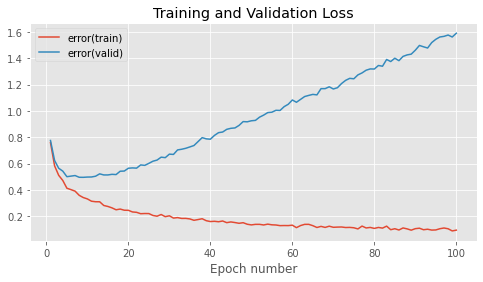

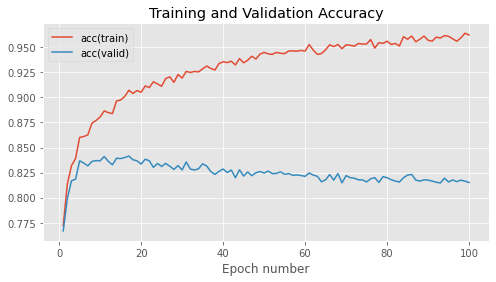

In [6]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialize weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Define Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Define error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_hu_128, keys_hu_128, run_time_hu_128, activation_dict_hu_128 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_hu_128, keys_hu_128, run_time_hu_128, activation_dict_hu_128, 'hu_128')

### c) Here you will train various neural networks by using either 1, 2, 3 hidden layers with 128 ReLU hidden units per layer on EMNIST using stochastic gradient descent (SGD) without any regularization.

### _Number of hidden layers:_ **1**

Epoch 1: 3.6s to complete
    error(train)=7.55e-01, acc(train)=7.70e-01, error(valid)=7.76e-01, acc(valid)=7.63e-01


Epoch 2: 3.6s to complete
    error(train)=5.92e-01, acc(train)=8.13e-01, error(valid)=6.31e-01, acc(valid)=8.03e-01


Epoch 3: 3.7s to complete
    error(train)=5.25e-01, acc(train)=8.26e-01, error(valid)=5.78e-01, acc(valid)=8.14e-01


Epoch 4: 3.7s to complete
    error(train)=4.72e-01, acc(train)=8.42e-01, error(valid)=5.40e-01, acc(valid)=8.28e-01


Epoch 5: 3.7s to complete
    error(train)=4.26e-01, acc(train)=8.56e-01, error(valid)=5.06e-01, acc(valid)=8.34e-01


Epoch 6: 3.6s to complete
    error(train)=4.07e-01, acc(train)=8.59e-01, error(valid)=5.08e-01, acc(valid)=8.34e-01


Epoch 7: 3.6s to complete
    error(train)=3.79e-01, acc(train)=8.68e-01, error(valid)=4.93e-01, acc(valid)=8.36e-01


Epoch 8: 3.7s to complete
    error(train)=3.51e-01, acc(train)=8.78e-01, error(valid)=4.82e-01, acc(valid)=8.42e-01


Epoch 9: 3.7s to complete
    error(train)=3.50e-01, acc(train)=8.75e-01, error(valid)=4.92e-01, acc(valid)=8.40e-01


Epoch 10: 3.7s to complete
    error(train)=3.37e-01, acc(train)=8.80e-01, error(valid)=4.96e-01, acc(valid)=8.41e-01


Epoch 11: 3.7s to complete
    error(train)=3.14e-01, acc(train)=8.87e-01, error(valid)=4.92e-01, acc(valid)=8.42e-01


Epoch 12: 3.7s to complete
    error(train)=3.14e-01, acc(train)=8.84e-01, error(valid)=5.06e-01, acc(valid)=8.38e-01


Epoch 13: 3.7s to complete
    error(train)=2.90e-01, acc(train)=8.93e-01, error(valid)=5.00e-01, acc(valid)=8.39e-01


Epoch 14: 3.7s to complete
    error(train)=3.08e-01, acc(train)=8.86e-01, error(valid)=5.30e-01, acc(valid)=8.30e-01


Epoch 15: 3.8s to complete
    error(train)=2.88e-01, acc(train)=8.92e-01, error(valid)=5.24e-01, acc(valid)=8.34e-01


Epoch 16: 3.7s to complete
    error(train)=2.89e-01, acc(train)=8.86e-01, error(valid)=5.36e-01, acc(valid)=8.26e-01


Epoch 17: 3.7s to complete
    error(train)=2.55e-01, acc(train)=9.03e-01, error(valid)=5.22e-01, acc(valid)=8.36e-01


Epoch 18: 3.8s to complete
    error(train)=2.58e-01, acc(train)=9.02e-01, error(valid)=5.36e-01, acc(valid)=8.37e-01


Epoch 19: 3.8s to complete
    error(train)=2.51e-01, acc(train)=9.04e-01, error(valid)=5.39e-01, acc(valid)=8.34e-01


Epoch 20: 3.7s to complete
    error(train)=2.45e-01, acc(train)=9.07e-01, error(valid)=5.49e-01, acc(valid)=8.36e-01


Epoch 21: 3.8s to complete
    error(train)=2.52e-01, acc(train)=9.02e-01, error(valid)=5.85e-01, acc(valid)=8.30e-01


Epoch 22: 3.9s to complete
    error(train)=2.33e-01, acc(train)=9.10e-01, error(valid)=5.72e-01, acc(valid)=8.33e-01


Epoch 23: 3.8s to complete
    error(train)=2.30e-01, acc(train)=9.11e-01, error(valid)=5.87e-01, acc(valid)=8.35e-01


Epoch 24: 3.8s to complete
    error(train)=2.19e-01, acc(train)=9.14e-01, error(valid)=5.82e-01, acc(valid)=8.33e-01


Epoch 25: 3.8s to complete
    error(train)=2.12e-01, acc(train)=9.18e-01, error(valid)=5.93e-01, acc(valid)=8.35e-01


Epoch 26: 3.8s to complete
    error(train)=2.05e-01, acc(train)=9.21e-01, error(valid)=6.01e-01, acc(valid)=8.35e-01


Epoch 27: 3.8s to complete
    error(train)=2.06e-01, acc(train)=9.19e-01, error(valid)=6.21e-01, acc(valid)=8.30e-01


Epoch 28: 3.7s to complete
    error(train)=2.02e-01, acc(train)=9.20e-01, error(valid)=6.41e-01, acc(valid)=8.32e-01


Epoch 29: 3.8s to complete
    error(train)=1.93e-01, acc(train)=9.24e-01, error(valid)=6.33e-01, acc(valid)=8.31e-01


Epoch 30: 3.7s to complete
    error(train)=2.05e-01, acc(train)=9.19e-01, error(valid)=6.68e-01, acc(valid)=8.27e-01


Epoch 31: 3.7s to complete
    error(train)=1.91e-01, acc(train)=9.25e-01, error(valid)=6.58e-01, acc(valid)=8.33e-01


Epoch 32: 3.8s to complete
    error(train)=1.97e-01, acc(train)=9.21e-01, error(valid)=6.82e-01, acc(valid)=8.29e-01


Epoch 33: 3.7s to complete
    error(train)=1.87e-01, acc(train)=9.26e-01, error(valid)=6.84e-01, acc(valid)=8.31e-01


Epoch 34: 3.8s to complete
    error(train)=1.82e-01, acc(train)=9.28e-01, error(valid)=7.06e-01, acc(valid)=8.29e-01


Epoch 35: 3.8s to complete
    error(train)=1.84e-01, acc(train)=9.25e-01, error(valid)=7.12e-01, acc(valid)=8.28e-01


Epoch 36: 3.8s to complete
    error(train)=1.75e-01, acc(train)=9.29e-01, error(valid)=7.23e-01, acc(valid)=8.30e-01


Epoch 37: 3.8s to complete
    error(train)=1.64e-01, acc(train)=9.34e-01, error(valid)=7.32e-01, acc(valid)=8.32e-01


Epoch 38: 3.8s to complete
    error(train)=1.84e-01, acc(train)=9.25e-01, error(valid)=7.61e-01, acc(valid)=8.26e-01


Epoch 39: 3.7s to complete
    error(train)=1.76e-01, acc(train)=9.30e-01, error(valid)=7.89e-01, acc(valid)=8.26e-01


Epoch 40: 3.8s to complete
    error(train)=1.81e-01, acc(train)=9.25e-01, error(valid)=7.94e-01, acc(valid)=8.23e-01


Epoch 41: 3.8s to complete
    error(train)=1.60e-01, acc(train)=9.34e-01, error(valid)=7.90e-01, acc(valid)=8.26e-01


Epoch 42: 3.5s to complete
    error(train)=1.61e-01, acc(train)=9.35e-01, error(valid)=7.91e-01, acc(valid)=8.30e-01


Epoch 43: 3.5s to complete
    error(train)=1.71e-01, acc(train)=9.30e-01, error(valid)=8.23e-01, acc(valid)=8.29e-01


Epoch 44: 3.3s to complete
    error(train)=1.56e-01, acc(train)=9.36e-01, error(valid)=8.38e-01, acc(valid)=8.26e-01


Epoch 45: 3.5s to complete
    error(train)=1.49e-01, acc(train)=9.39e-01, error(valid)=8.28e-01, acc(valid)=8.29e-01


Epoch 46: 3.7s to complete
    error(train)=1.56e-01, acc(train)=9.36e-01, error(valid)=8.52e-01, acc(valid)=8.23e-01


Epoch 47: 3.8s to complete
    error(train)=1.58e-01, acc(train)=9.35e-01, error(valid)=8.64e-01, acc(valid)=8.24e-01


Epoch 48: 3.8s to complete
    error(train)=1.47e-01, acc(train)=9.38e-01, error(valid)=8.52e-01, acc(valid)=8.28e-01


Epoch 49: 3.8s to complete
    error(train)=1.47e-01, acc(train)=9.39e-01, error(valid)=9.01e-01, acc(valid)=8.25e-01


Epoch 50: 3.7s to complete
    error(train)=1.48e-01, acc(train)=9.40e-01, error(valid)=9.11e-01, acc(valid)=8.26e-01


Epoch 51: 3.8s to complete
    error(train)=1.51e-01, acc(train)=9.38e-01, error(valid)=9.23e-01, acc(valid)=8.22e-01


Epoch 52: 3.8s to complete
    error(train)=1.49e-01, acc(train)=9.39e-01, error(valid)=9.47e-01, acc(valid)=8.20e-01


Epoch 53: 3.8s to complete
    error(train)=1.33e-01, acc(train)=9.45e-01, error(valid)=9.40e-01, acc(valid)=8.28e-01


Epoch 54: 3.8s to complete
    error(train)=1.34e-01, acc(train)=9.45e-01, error(valid)=9.36e-01, acc(valid)=8.25e-01


Epoch 55: 3.8s to complete
    error(train)=1.36e-01, acc(train)=9.43e-01, error(valid)=9.61e-01, acc(valid)=8.21e-01


Epoch 56: 3.9s to complete
    error(train)=1.44e-01, acc(train)=9.41e-01, error(valid)=9.98e-01, acc(valid)=8.18e-01


Epoch 57: 3.5s to complete
    error(train)=1.43e-01, acc(train)=9.40e-01, error(valid)=9.87e-01, acc(valid)=8.18e-01


Epoch 58: 3.4s to complete
    error(train)=1.39e-01, acc(train)=9.43e-01, error(valid)=9.95e-01, acc(valid)=8.21e-01


Epoch 59: 3.7s to complete
    error(train)=1.33e-01, acc(train)=9.46e-01, error(valid)=1.03e+00, acc(valid)=8.18e-01


Epoch 60: 3.7s to complete
    error(train)=1.40e-01, acc(train)=9.43e-01, error(valid)=1.05e+00, acc(valid)=8.22e-01


Epoch 61: 4.0s to complete
    error(train)=1.38e-01, acc(train)=9.43e-01, error(valid)=1.07e+00, acc(valid)=8.21e-01


Epoch 62: 3.8s to complete
    error(train)=1.35e-01, acc(train)=9.46e-01, error(valid)=1.09e+00, acc(valid)=8.21e-01


Epoch 63: 3.6s to complete
    error(train)=1.21e-01, acc(train)=9.50e-01, error(valid)=1.07e+00, acc(valid)=8.20e-01


Epoch 64: 3.6s to complete
    error(train)=1.24e-01, acc(train)=9.49e-01, error(valid)=1.08e+00, acc(valid)=8.22e-01


Epoch 65: 3.8s to complete
    error(train)=1.31e-01, acc(train)=9.46e-01, error(valid)=1.11e+00, acc(valid)=8.16e-01


Epoch 66: 3.9s to complete
    error(train)=1.25e-01, acc(train)=9.50e-01, error(valid)=1.09e+00, acc(valid)=8.20e-01


Epoch 67: 3.6s to complete
    error(train)=1.18e-01, acc(train)=9.52e-01, error(valid)=1.12e+00, acc(valid)=8.22e-01


Epoch 68: 3.6s to complete
    error(train)=1.21e-01, acc(train)=9.50e-01, error(valid)=1.13e+00, acc(valid)=8.21e-01


Epoch 69: 3.6s to complete
    error(train)=1.32e-01, acc(train)=9.48e-01, error(valid)=1.18e+00, acc(valid)=8.21e-01


Epoch 70: 3.5s to complete
    error(train)=1.28e-01, acc(train)=9.48e-01, error(valid)=1.18e+00, acc(valid)=8.23e-01


Epoch 71: 3.7s to complete
    error(train)=1.20e-01, acc(train)=9.50e-01, error(valid)=1.18e+00, acc(valid)=8.19e-01


Epoch 72: 3.9s to complete
    error(train)=1.16e-01, acc(train)=9.52e-01, error(valid)=1.20e+00, acc(valid)=8.22e-01


Epoch 73: 3.9s to complete
    error(train)=1.21e-01, acc(train)=9.50e-01, error(valid)=1.19e+00, acc(valid)=8.20e-01


Epoch 74: 3.9s to complete
    error(train)=1.19e-01, acc(train)=9.51e-01, error(valid)=1.23e+00, acc(valid)=8.18e-01


Epoch 75: 4.0s to complete
    error(train)=1.19e-01, acc(train)=9.51e-01, error(valid)=1.23e+00, acc(valid)=8.17e-01


Epoch 76: 3.5s to complete
    error(train)=1.25e-01, acc(train)=9.50e-01, error(valid)=1.27e+00, acc(valid)=8.22e-01


Epoch 77: 3.8s to complete
    error(train)=1.13e-01, acc(train)=9.54e-01, error(valid)=1.25e+00, acc(valid)=8.20e-01


Epoch 78: 3.5s to complete
    error(train)=1.11e-01, acc(train)=9.55e-01, error(valid)=1.25e+00, acc(valid)=8.18e-01


Epoch 79: 3.5s to complete
    error(train)=1.15e-01, acc(train)=9.53e-01, error(valid)=1.26e+00, acc(valid)=8.18e-01


Epoch 80: 3.5s to complete
    error(train)=1.10e-01, acc(train)=9.55e-01, error(valid)=1.30e+00, acc(valid)=8.22e-01


Epoch 81: 3.5s to complete
    error(train)=1.16e-01, acc(train)=9.54e-01, error(valid)=1.33e+00, acc(valid)=8.16e-01


Epoch 82: 3.6s to complete
    error(train)=1.21e-01, acc(train)=9.51e-01, error(valid)=1.34e+00, acc(valid)=8.16e-01


Epoch 83: 3.8s to complete
    error(train)=1.25e-01, acc(train)=9.49e-01, error(valid)=1.37e+00, acc(valid)=8.18e-01


Epoch 84: 3.5s to complete
    error(train)=1.06e-01, acc(train)=9.56e-01, error(valid)=1.35e+00, acc(valid)=8.17e-01


Epoch 85: 3.6s to complete
    error(train)=1.13e-01, acc(train)=9.54e-01, error(valid)=1.36e+00, acc(valid)=8.19e-01


Epoch 86: 3.8s to complete
    error(train)=1.20e-01, acc(train)=9.51e-01, error(valid)=1.38e+00, acc(valid)=8.15e-01


Epoch 87: 3.4s to complete
    error(train)=1.08e-01, acc(train)=9.56e-01, error(valid)=1.39e+00, acc(valid)=8.18e-01


Epoch 88: 3.5s to complete
    error(train)=1.09e-01, acc(train)=9.56e-01, error(valid)=1.43e+00, acc(valid)=8.15e-01


Epoch 89: 3.9s to complete
    error(train)=9.91e-02, acc(train)=9.59e-01, error(valid)=1.40e+00, acc(valid)=8.18e-01


Epoch 90: 3.9s to complete
    error(train)=1.02e-01, acc(train)=9.59e-01, error(valid)=1.45e+00, acc(valid)=8.14e-01


Epoch 91: 3.8s to complete
    error(train)=1.09e-01, acc(train)=9.56e-01, error(valid)=1.46e+00, acc(valid)=8.11e-01


Epoch 92: 3.7s to complete
    error(train)=1.18e-01, acc(train)=9.53e-01, error(valid)=1.49e+00, acc(valid)=8.13e-01


Epoch 93: 3.8s to complete
    error(train)=1.19e-01, acc(train)=9.52e-01, error(valid)=1.49e+00, acc(valid)=8.15e-01


Epoch 94: 3.7s to complete
    error(train)=9.82e-02, acc(train)=9.60e-01, error(valid)=1.47e+00, acc(valid)=8.15e-01


Epoch 95: 3.8s to complete
    error(train)=1.04e-01, acc(train)=9.57e-01, error(valid)=1.49e+00, acc(valid)=8.15e-01


Epoch 96: 3.9s to complete
    error(train)=1.07e-01, acc(train)=9.57e-01, error(valid)=1.53e+00, acc(valid)=8.17e-01


Epoch 97: 3.9s to complete
    error(train)=1.01e-01, acc(train)=9.59e-01, error(valid)=1.50e+00, acc(valid)=8.19e-01


Epoch 98: 3.9s to complete
    error(train)=9.83e-02, acc(train)=9.60e-01, error(valid)=1.53e+00, acc(valid)=8.16e-01


Epoch 99: 3.8s to complete
    error(train)=9.89e-02, acc(train)=9.60e-01, error(valid)=1.52e+00, acc(valid)=8.16e-01


Epoch 100: 4.0s to complete
    error(train)=9.61e-02, acc(train)=9.62e-01, error(valid)=1.54e+00, acc(valid)=8.17e-01


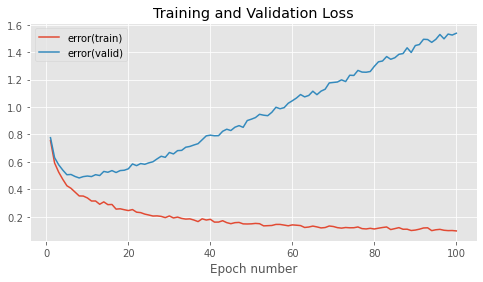

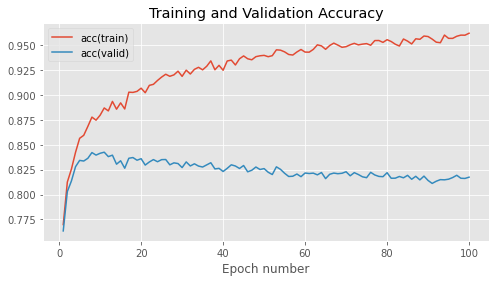

In [7]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialize weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Define Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Define error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_hl_1, keys_hl_1, run_time_hl_1, activation_dict_hl_1 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_hl_1, keys_hl_1, run_time_hl_1, activation_dict_hl_1, 'hl_1')

### _Number of hidden layers:_ **2**

Epoch 1: 4.9s to complete
    error(train)=7.04e-01, acc(train)=7.78e-01, error(valid)=7.29e-01, acc(valid)=7.72e-01


Epoch 2: 4.5s to complete
    error(train)=5.63e-01, acc(train)=8.12e-01, error(valid)=6.11e-01, acc(valid)=7.96e-01


Epoch 3: 4.5s to complete
    error(train)=4.79e-01, acc(train)=8.40e-01, error(valid)=5.47e-01, acc(valid)=8.17e-01


Epoch 4: 4.4s to complete
    error(train)=4.32e-01, acc(train)=8.51e-01, error(valid)=5.19e-01, acc(valid)=8.29e-01


Epoch 5: 4.6s to complete
    error(train)=4.00e-01, acc(train)=8.60e-01, error(valid)=4.98e-01, acc(valid)=8.35e-01


Epoch 6: 4.5s to complete
    error(train)=3.89e-01, acc(train)=8.60e-01, error(valid)=5.07e-01, acc(valid)=8.27e-01


Epoch 7: 4.5s to complete
    error(train)=3.49e-01, acc(train)=8.74e-01, error(valid)=4.75e-01, acc(valid)=8.38e-01


Epoch 8: 4.8s to complete
    error(train)=3.39e-01, acc(train)=8.76e-01, error(valid)=4.84e-01, acc(valid)=8.38e-01


Epoch 9: 4.8s to complete
    error(train)=3.37e-01, acc(train)=8.76e-01, error(valid)=5.02e-01, acc(valid)=8.33e-01


Epoch 10: 5.2s to complete
    error(train)=3.04e-01, acc(train)=8.87e-01, error(valid)=4.83e-01, acc(valid)=8.40e-01


Epoch 11: 5.1s to complete
    error(train)=2.86e-01, acc(train)=8.90e-01, error(valid)=4.85e-01, acc(valid)=8.40e-01


Epoch 12: 4.9s to complete
    error(train)=2.98e-01, acc(train)=8.87e-01, error(valid)=5.13e-01, acc(valid)=8.38e-01


Epoch 13: 4.8s to complete
    error(train)=2.73e-01, acc(train)=8.97e-01, error(valid)=5.02e-01, acc(valid)=8.42e-01


Epoch 14: 4.4s to complete
    error(train)=2.59e-01, acc(train)=9.00e-01, error(valid)=5.06e-01, acc(valid)=8.41e-01


Epoch 15: 4.8s to complete
    error(train)=2.53e-01, acc(train)=9.03e-01, error(valid)=5.12e-01, acc(valid)=8.40e-01


Epoch 16: 5.1s to complete
    error(train)=2.41e-01, acc(train)=9.06e-01, error(valid)=5.19e-01, acc(valid)=8.43e-01


Epoch 17: 5.0s to complete
    error(train)=2.39e-01, acc(train)=9.07e-01, error(valid)=5.46e-01, acc(valid)=8.36e-01


Epoch 18: 4.9s to complete
    error(train)=2.20e-01, acc(train)=9.14e-01, error(valid)=5.44e-01, acc(valid)=8.43e-01


Epoch 19: 4.9s to complete
    error(train)=2.30e-01, acc(train)=9.08e-01, error(valid)=5.64e-01, acc(valid)=8.33e-01


Epoch 20: 4.8s to complete
    error(train)=2.10e-01, acc(train)=9.16e-01, error(valid)=5.58e-01, acc(valid)=8.40e-01


Epoch 21: 4.8s to complete
    error(train)=2.10e-01, acc(train)=9.15e-01, error(valid)=5.86e-01, acc(valid)=8.37e-01


Epoch 22: 4.8s to complete
    error(train)=2.13e-01, acc(train)=9.15e-01, error(valid)=6.09e-01, acc(valid)=8.38e-01


Epoch 23: 4.7s to complete
    error(train)=1.98e-01, acc(train)=9.21e-01, error(valid)=6.04e-01, acc(valid)=8.41e-01


Epoch 24: 4.7s to complete
    error(train)=2.07e-01, acc(train)=9.15e-01, error(valid)=6.31e-01, acc(valid)=8.31e-01


Epoch 25: 4.8s to complete
    error(train)=2.04e-01, acc(train)=9.18e-01, error(valid)=6.48e-01, acc(valid)=8.34e-01


Epoch 26: 4.8s to complete
    error(train)=1.95e-01, acc(train)=9.20e-01, error(valid)=6.42e-01, acc(valid)=8.33e-01


Epoch 27: 4.8s to complete
    error(train)=1.97e-01, acc(train)=9.21e-01, error(valid)=6.61e-01, acc(valid)=8.34e-01


Epoch 28: 5.0s to complete
    error(train)=1.77e-01, acc(train)=9.27e-01, error(valid)=6.76e-01, acc(valid)=8.34e-01


Epoch 29: 5.0s to complete
    error(train)=1.81e-01, acc(train)=9.26e-01, error(valid)=6.80e-01, acc(valid)=8.38e-01


Epoch 30: 4.5s to complete
    error(train)=1.76e-01, acc(train)=9.28e-01, error(valid)=7.01e-01, acc(valid)=8.33e-01


Epoch 31: 4.8s to complete
    error(train)=1.87e-01, acc(train)=9.24e-01, error(valid)=7.34e-01, acc(valid)=8.36e-01


Epoch 32: 4.8s to complete
    error(train)=1.70e-01, acc(train)=9.32e-01, error(valid)=7.38e-01, acc(valid)=8.33e-01


Epoch 33: 4.8s to complete
    error(train)=1.67e-01, acc(train)=9.32e-01, error(valid)=7.39e-01, acc(valid)=8.32e-01


Epoch 34: 4.7s to complete
    error(train)=1.55e-01, acc(train)=9.36e-01, error(valid)=7.54e-01, acc(valid)=8.32e-01


Epoch 35: 4.9s to complete
    error(train)=1.66e-01, acc(train)=9.33e-01, error(valid)=7.92e-01, acc(valid)=8.33e-01


Epoch 36: 5.0s to complete
    error(train)=1.62e-01, acc(train)=9.33e-01, error(valid)=8.06e-01, acc(valid)=8.29e-01


Epoch 37: 5.1s to complete
    error(train)=1.59e-01, acc(train)=9.33e-01, error(valid)=8.00e-01, acc(valid)=8.32e-01


Epoch 38: 4.7s to complete
    error(train)=1.55e-01, acc(train)=9.37e-01, error(valid)=8.26e-01, acc(valid)=8.29e-01


Epoch 39: 4.8s to complete
    error(train)=1.55e-01, acc(train)=9.36e-01, error(valid)=8.36e-01, acc(valid)=8.31e-01


Epoch 40: 4.7s to complete
    error(train)=1.46e-01, acc(train)=9.40e-01, error(valid)=8.52e-01, acc(valid)=8.30e-01


Epoch 41: 4.2s to complete
    error(train)=1.56e-01, acc(train)=9.37e-01, error(valid)=8.83e-01, acc(valid)=8.28e-01


Epoch 42: 4.7s to complete
    error(train)=1.54e-01, acc(train)=9.37e-01, error(valid)=8.74e-01, acc(valid)=8.28e-01


Epoch 43: 5.2s to complete
    error(train)=1.43e-01, acc(train)=9.41e-01, error(valid)=8.70e-01, acc(valid)=8.29e-01


Epoch 44: 4.8s to complete
    error(train)=1.40e-01, acc(train)=9.42e-01, error(valid)=9.09e-01, acc(valid)=8.29e-01


Epoch 45: 4.7s to complete
    error(train)=1.42e-01, acc(train)=9.42e-01, error(valid)=9.28e-01, acc(valid)=8.27e-01


Epoch 46: 4.3s to complete
    error(train)=1.45e-01, acc(train)=9.40e-01, error(valid)=9.38e-01, acc(valid)=8.22e-01


Epoch 47: 5.1s to complete
    error(train)=1.38e-01, acc(train)=9.43e-01, error(valid)=9.27e-01, acc(valid)=8.32e-01


Epoch 48: 4.9s to complete
    error(train)=1.40e-01, acc(train)=9.42e-01, error(valid)=9.77e-01, acc(valid)=8.25e-01


Epoch 49: 5.1s to complete
    error(train)=1.21e-01, acc(train)=9.50e-01, error(valid)=9.69e-01, acc(valid)=8.31e-01


Epoch 50: 4.8s to complete
    error(train)=1.50e-01, acc(train)=9.38e-01, error(valid)=1.00e+00, acc(valid)=8.21e-01


Epoch 51: 5.1s to complete
    error(train)=1.46e-01, acc(train)=9.41e-01, error(valid)=1.05e+00, acc(valid)=8.24e-01


Epoch 52: 5.0s to complete
    error(train)=1.40e-01, acc(train)=9.43e-01, error(valid)=1.06e+00, acc(valid)=8.24e-01


Epoch 53: 4.9s to complete
    error(train)=1.26e-01, acc(train)=9.49e-01, error(valid)=1.03e+00, acc(valid)=8.28e-01


Epoch 54: 4.8s to complete
    error(train)=1.34e-01, acc(train)=9.44e-01, error(valid)=1.04e+00, acc(valid)=8.22e-01


Epoch 55: 4.8s to complete
    error(train)=1.21e-01, acc(train)=9.51e-01, error(valid)=1.04e+00, acc(valid)=8.28e-01


Epoch 56: 4.9s to complete
    error(train)=1.41e-01, acc(train)=9.43e-01, error(valid)=1.08e+00, acc(valid)=8.27e-01


Epoch 57: 5.0s to complete
    error(train)=1.38e-01, acc(train)=9.45e-01, error(valid)=1.10e+00, acc(valid)=8.26e-01


Epoch 58: 4.9s to complete
    error(train)=1.23e-01, acc(train)=9.50e-01, error(valid)=1.12e+00, acc(valid)=8.26e-01


Epoch 59: 5.5s to complete
    error(train)=1.42e-01, acc(train)=9.43e-01, error(valid)=1.13e+00, acc(valid)=8.23e-01


Epoch 60: 4.4s to complete
    error(train)=1.26e-01, acc(train)=9.50e-01, error(valid)=1.13e+00, acc(valid)=8.26e-01


Epoch 61: 4.8s to complete
    error(train)=1.21e-01, acc(train)=9.50e-01, error(valid)=1.16e+00, acc(valid)=8.28e-01


Epoch 62: 5.0s to complete
    error(train)=1.23e-01, acc(train)=9.51e-01, error(valid)=1.18e+00, acc(valid)=8.28e-01


Epoch 63: 4.4s to complete
    error(train)=1.56e-01, acc(train)=9.42e-01, error(valid)=1.25e+00, acc(valid)=8.22e-01


Epoch 64: 4.5s to complete
    error(train)=1.14e-01, acc(train)=9.54e-01, error(valid)=1.20e+00, acc(valid)=8.28e-01


Epoch 65: 4.3s to complete
    error(train)=1.22e-01, acc(train)=9.51e-01, error(valid)=1.19e+00, acc(valid)=8.20e-01


Epoch 66: 4.3s to complete
    error(train)=1.25e-01, acc(train)=9.50e-01, error(valid)=1.20e+00, acc(valid)=8.23e-01


Epoch 67: 4.3s to complete
    error(train)=1.19e-01, acc(train)=9.52e-01, error(valid)=1.22e+00, acc(valid)=8.26e-01


Epoch 68: 4.3s to complete
    error(train)=1.37e-01, acc(train)=9.46e-01, error(valid)=1.24e+00, acc(valid)=8.24e-01


Epoch 69: 4.3s to complete
    error(train)=1.13e-01, acc(train)=9.54e-01, error(valid)=1.26e+00, acc(valid)=8.25e-01


Epoch 70: 4.4s to complete
    error(train)=1.17e-01, acc(train)=9.54e-01, error(valid)=1.23e+00, acc(valid)=8.27e-01


Epoch 71: 5.1s to complete
    error(train)=1.30e-01, acc(train)=9.50e-01, error(valid)=1.34e+00, acc(valid)=8.23e-01


Epoch 72: 4.8s to complete
    error(train)=1.15e-01, acc(train)=9.54e-01, error(valid)=1.31e+00, acc(valid)=8.25e-01


Epoch 73: 4.8s to complete
    error(train)=1.17e-01, acc(train)=9.53e-01, error(valid)=1.31e+00, acc(valid)=8.19e-01


Epoch 74: 4.8s to complete
    error(train)=1.20e-01, acc(train)=9.55e-01, error(valid)=1.31e+00, acc(valid)=8.25e-01


Epoch 75: 4.8s to complete
    error(train)=1.22e-01, acc(train)=9.53e-01, error(valid)=1.32e+00, acc(valid)=8.26e-01


Epoch 76: 4.5s to complete
    error(train)=1.30e-01, acc(train)=9.48e-01, error(valid)=1.36e+00, acc(valid)=8.19e-01


Epoch 77: 5.1s to complete
    error(train)=1.21e-01, acc(train)=9.53e-01, error(valid)=1.39e+00, acc(valid)=8.20e-01


Epoch 78: 4.8s to complete
    error(train)=1.20e-01, acc(train)=9.54e-01, error(valid)=1.38e+00, acc(valid)=8.26e-01


Epoch 79: 4.8s to complete
    error(train)=1.16e-01, acc(train)=9.54e-01, error(valid)=1.36e+00, acc(valid)=8.20e-01


Epoch 80: 4.8s to complete
    error(train)=1.29e-01, acc(train)=9.51e-01, error(valid)=1.41e+00, acc(valid)=8.20e-01


Epoch 81: 4.7s to complete
    error(train)=1.23e-01, acc(train)=9.53e-01, error(valid)=1.39e+00, acc(valid)=8.22e-01


Epoch 82: 4.8s to complete
    error(train)=1.12e-01, acc(train)=9.57e-01, error(valid)=1.41e+00, acc(valid)=8.22e-01


Epoch 83: 4.9s to complete
    error(train)=1.04e-01, acc(train)=9.59e-01, error(valid)=1.43e+00, acc(valid)=8.22e-01


Epoch 84: 5.1s to complete
    error(train)=1.08e-01, acc(train)=9.57e-01, error(valid)=1.42e+00, acc(valid)=8.26e-01


Epoch 85: 4.7s to complete
    error(train)=1.11e-01, acc(train)=9.57e-01, error(valid)=1.51e+00, acc(valid)=8.24e-01


Epoch 86: 4.8s to complete
    error(train)=1.07e-01, acc(train)=9.58e-01, error(valid)=1.47e+00, acc(valid)=8.24e-01


Epoch 87: 4.7s to complete
    error(train)=1.27e-01, acc(train)=9.53e-01, error(valid)=1.55e+00, acc(valid)=8.18e-01


Epoch 88: 4.9s to complete
    error(train)=1.16e-01, acc(train)=9.54e-01, error(valid)=1.49e+00, acc(valid)=8.22e-01


Epoch 89: 4.8s to complete
    error(train)=1.14e-01, acc(train)=9.57e-01, error(valid)=1.57e+00, acc(valid)=8.26e-01


Epoch 90: 4.8s to complete
    error(train)=1.19e-01, acc(train)=9.56e-01, error(valid)=1.57e+00, acc(valid)=8.22e-01


Epoch 91: 4.8s to complete
    error(train)=1.06e-01, acc(train)=9.59e-01, error(valid)=1.58e+00, acc(valid)=8.23e-01


Epoch 92: 4.8s to complete
    error(train)=1.11e-01, acc(train)=9.58e-01, error(valid)=1.54e+00, acc(valid)=8.24e-01


Epoch 93: 4.8s to complete
    error(train)=9.02e-02, acc(train)=9.63e-01, error(valid)=1.58e+00, acc(valid)=8.24e-01


Epoch 94: 4.9s to complete
    error(train)=1.22e-01, acc(train)=9.55e-01, error(valid)=1.60e+00, acc(valid)=8.16e-01


Epoch 95: 4.8s to complete
    error(train)=1.08e-01, acc(train)=9.59e-01, error(valid)=1.60e+00, acc(valid)=8.22e-01


Epoch 96: 4.8s to complete
    error(train)=9.94e-02, acc(train)=9.61e-01, error(valid)=1.61e+00, acc(valid)=8.21e-01


Epoch 97: 5.0s to complete
    error(train)=1.08e-01, acc(train)=9.58e-01, error(valid)=1.65e+00, acc(valid)=8.22e-01


Epoch 98: 4.9s to complete
    error(train)=1.19e-01, acc(train)=9.55e-01, error(valid)=1.63e+00, acc(valid)=8.22e-01


Epoch 99: 4.8s to complete
    error(train)=1.05e-01, acc(train)=9.61e-01, error(valid)=1.63e+00, acc(valid)=8.25e-01


Epoch 100: 4.9s to complete
    error(train)=1.26e-01, acc(train)=9.54e-01, error(valid)=1.70e+00, acc(valid)=8.18e-01


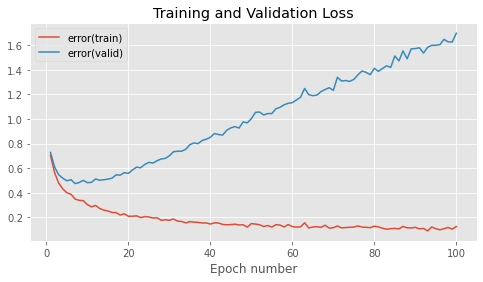

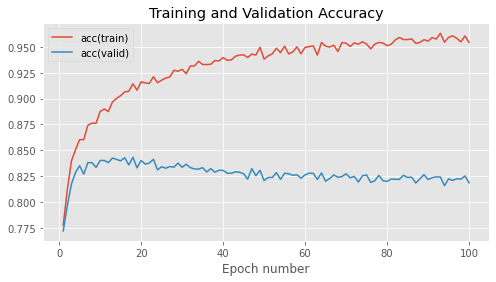

In [8]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialize weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Define Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Define error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_hl_2, keys_hl_2, run_time_hl_2, activation_dict_hl_2 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_hl_2, keys_hl_2, run_time_hl_2, activation_dict_hl_2, 'hl_2')

### _Number of hidden layers:_ **3**

Epoch 1: 5.0s to complete
    error(train)=6.77e-01, acc(train)=7.81e-01, error(valid)=7.04e-01, acc(valid)=7.72e-01


Epoch 2: 5.4s to complete
    error(train)=5.30e-01, acc(train)=8.23e-01, error(valid)=5.84e-01, acc(valid)=8.09e-01


Epoch 3: 5.4s to complete
    error(train)=4.84e-01, acc(train)=8.34e-01, error(valid)=5.55e-01, acc(valid)=8.12e-01


Epoch 4: 5.4s to complete
    error(train)=4.46e-01, acc(train)=8.45e-01, error(valid)=5.37e-01, acc(valid)=8.20e-01


Epoch 5: 5.0s to complete
    error(train)=4.04e-01, acc(train)=8.59e-01, error(valid)=5.08e-01, acc(valid)=8.30e-01


Epoch 6: 5.3s to complete
    error(train)=3.87e-01, acc(train)=8.61e-01, error(valid)=5.07e-01, acc(valid)=8.31e-01


Epoch 7: 5.4s to complete
    error(train)=3.55e-01, acc(train)=8.70e-01, error(valid)=4.97e-01, acc(valid)=8.34e-01


Epoch 8: 5.6s to complete
    error(train)=3.40e-01, acc(train)=8.75e-01, error(valid)=5.01e-01, acc(valid)=8.35e-01


Epoch 9: 5.5s to complete
    error(train)=3.19e-01, acc(train)=8.81e-01, error(valid)=4.90e-01, acc(valid)=8.37e-01


Epoch 10: 5.7s to complete
    error(train)=3.14e-01, acc(train)=8.82e-01, error(valid)=5.01e-01, acc(valid)=8.36e-01


Epoch 11: 5.6s to complete
    error(train)=2.95e-01, acc(train)=8.88e-01, error(valid)=5.12e-01, acc(valid)=8.39e-01


Epoch 12: 5.8s to complete
    error(train)=2.84e-01, acc(train)=8.90e-01, error(valid)=5.08e-01, acc(valid)=8.40e-01


Epoch 13: 5.6s to complete
    error(train)=2.74e-01, acc(train)=8.94e-01, error(valid)=5.15e-01, acc(valid)=8.38e-01


Epoch 14: 5.6s to complete
    error(train)=2.68e-01, acc(train)=8.96e-01, error(valid)=5.17e-01, acc(valid)=8.44e-01


Epoch 15: 5.3s to complete
    error(train)=2.45e-01, acc(train)=9.04e-01, error(valid)=5.16e-01, acc(valid)=8.44e-01


Epoch 16: 5.5s to complete
    error(train)=2.41e-01, acc(train)=9.04e-01, error(valid)=5.40e-01, acc(valid)=8.38e-01


Epoch 17: 5.6s to complete
    error(train)=2.35e-01, acc(train)=9.06e-01, error(valid)=5.37e-01, acc(valid)=8.43e-01


Epoch 18: 5.6s to complete
    error(train)=2.37e-01, acc(train)=9.05e-01, error(valid)=5.70e-01, acc(valid)=8.39e-01


Epoch 19: 5.6s to complete
    error(train)=2.29e-01, acc(train)=9.09e-01, error(valid)=5.79e-01, acc(valid)=8.36e-01


Epoch 20: 5.6s to complete
    error(train)=2.10e-01, acc(train)=9.16e-01, error(valid)=5.65e-01, acc(valid)=8.39e-01


Epoch 21: 5.6s to complete
    error(train)=2.19e-01, acc(train)=9.11e-01, error(valid)=5.92e-01, acc(valid)=8.38e-01


Epoch 22: 5.8s to complete
    error(train)=2.15e-01, acc(train)=9.14e-01, error(valid)=6.06e-01, acc(valid)=8.40e-01


Epoch 23: 5.6s to complete
    error(train)=2.19e-01, acc(train)=9.12e-01, error(valid)=6.05e-01, acc(valid)=8.38e-01


Epoch 24: 5.8s to complete
    error(train)=1.98e-01, acc(train)=9.20e-01, error(valid)=6.18e-01, acc(valid)=8.42e-01


Epoch 25: 5.8s to complete
    error(train)=2.07e-01, acc(train)=9.16e-01, error(valid)=6.26e-01, acc(valid)=8.38e-01


Epoch 26: 5.7s to complete
    error(train)=2.01e-01, acc(train)=9.19e-01, error(valid)=6.62e-01, acc(valid)=8.34e-01


Epoch 27: 5.6s to complete
    error(train)=1.98e-01, acc(train)=9.19e-01, error(valid)=6.64e-01, acc(valid)=8.34e-01


Epoch 28: 5.8s to complete
    error(train)=1.82e-01, acc(train)=9.26e-01, error(valid)=6.64e-01, acc(valid)=8.38e-01


Epoch 29: 5.8s to complete
    error(train)=1.89e-01, acc(train)=9.23e-01, error(valid)=6.87e-01, acc(valid)=8.38e-01


Epoch 30: 6.0s to complete
    error(train)=1.94e-01, acc(train)=9.22e-01, error(valid)=6.87e-01, acc(valid)=8.38e-01


Epoch 31: 5.7s to complete
    error(train)=1.77e-01, acc(train)=9.27e-01, error(valid)=6.86e-01, acc(valid)=8.40e-01


Epoch 32: 5.7s to complete
    error(train)=1.87e-01, acc(train)=9.24e-01, error(valid)=7.38e-01, acc(valid)=8.36e-01


Epoch 33: 5.8s to complete
    error(train)=1.81e-01, acc(train)=9.27e-01, error(valid)=7.39e-01, acc(valid)=8.36e-01


Epoch 34: 5.1s to complete
    error(train)=1.66e-01, acc(train)=9.31e-01, error(valid)=7.30e-01, acc(valid)=8.35e-01


Epoch 35: 5.9s to complete
    error(train)=1.66e-01, acc(train)=9.31e-01, error(valid)=7.41e-01, acc(valid)=8.36e-01


Epoch 36: 5.8s to complete
    error(train)=1.70e-01, acc(train)=9.30e-01, error(valid)=7.39e-01, acc(valid)=8.36e-01


Epoch 37: 5.8s to complete
    error(train)=1.71e-01, acc(train)=9.30e-01, error(valid)=7.58e-01, acc(valid)=8.35e-01


Epoch 38: 5.1s to complete
    error(train)=1.58e-01, acc(train)=9.35e-01, error(valid)=7.82e-01, acc(valid)=8.38e-01


Epoch 39: 5.2s to complete
    error(train)=1.92e-01, acc(train)=9.26e-01, error(valid)=8.33e-01, acc(valid)=8.32e-01


Epoch 40: 5.6s to complete
    error(train)=1.62e-01, acc(train)=9.33e-01, error(valid)=8.02e-01, acc(valid)=8.38e-01


Epoch 41: 5.7s to complete
    error(train)=1.69e-01, acc(train)=9.31e-01, error(valid)=8.20e-01, acc(valid)=8.34e-01


Epoch 42: 5.7s to complete
    error(train)=1.72e-01, acc(train)=9.30e-01, error(valid)=8.17e-01, acc(valid)=8.31e-01


Epoch 43: 5.8s to complete
    error(train)=1.56e-01, acc(train)=9.36e-01, error(valid)=8.30e-01, acc(valid)=8.33e-01


Epoch 44: 5.7s to complete
    error(train)=1.60e-01, acc(train)=9.34e-01, error(valid)=8.26e-01, acc(valid)=8.32e-01


Epoch 45: 5.8s to complete
    error(train)=1.55e-01, acc(train)=9.37e-01, error(valid)=8.69e-01, acc(valid)=8.33e-01


Epoch 46: 5.8s to complete
    error(train)=1.56e-01, acc(train)=9.37e-01, error(valid)=8.89e-01, acc(valid)=8.34e-01


Epoch 47: 5.8s to complete
    error(train)=1.65e-01, acc(train)=9.34e-01, error(valid)=9.10e-01, acc(valid)=8.30e-01


Epoch 48: 5.8s to complete
    error(train)=1.57e-01, acc(train)=9.35e-01, error(valid)=9.11e-01, acc(valid)=8.28e-01


Epoch 49: 5.8s to complete
    error(train)=1.58e-01, acc(train)=9.35e-01, error(valid)=9.12e-01, acc(valid)=8.32e-01


Epoch 50: 5.8s to complete
    error(train)=1.58e-01, acc(train)=9.36e-01, error(valid)=9.52e-01, acc(valid)=8.27e-01


Epoch 51: 5.8s to complete
    error(train)=1.42e-01, acc(train)=9.42e-01, error(valid)=9.07e-01, acc(valid)=8.33e-01


Epoch 52: 5.8s to complete
    error(train)=1.57e-01, acc(train)=9.37e-01, error(valid)=9.52e-01, acc(valid)=8.32e-01


Epoch 53: 5.2s to complete
    error(train)=1.46e-01, acc(train)=9.40e-01, error(valid)=9.29e-01, acc(valid)=8.31e-01


Epoch 54: 5.8s to complete
    error(train)=1.45e-01, acc(train)=9.41e-01, error(valid)=9.76e-01, acc(valid)=8.32e-01


Epoch 55: 6.1s to complete
    error(train)=1.57e-01, acc(train)=9.37e-01, error(valid)=9.89e-01, acc(valid)=8.27e-01


Epoch 56: 6.1s to complete
    error(train)=1.37e-01, acc(train)=9.44e-01, error(valid)=9.51e-01, acc(valid)=8.31e-01


Epoch 57: 6.1s to complete
    error(train)=1.36e-01, acc(train)=9.45e-01, error(valid)=1.01e+00, acc(valid)=8.31e-01


Epoch 58: 6.1s to complete
    error(train)=1.43e-01, acc(train)=9.42e-01, error(valid)=9.93e-01, acc(valid)=8.31e-01


Epoch 59: 6.1s to complete
    error(train)=1.50e-01, acc(train)=9.41e-01, error(valid)=1.06e+00, acc(valid)=8.27e-01


Epoch 60: 6.0s to complete
    error(train)=1.33e-01, acc(train)=9.47e-01, error(valid)=1.04e+00, acc(valid)=8.30e-01


Epoch 61: 5.8s to complete
    error(train)=1.45e-01, acc(train)=9.42e-01, error(valid)=1.01e+00, acc(valid)=8.29e-01


Epoch 62: 5.6s to complete
    error(train)=1.34e-01, acc(train)=9.45e-01, error(valid)=1.02e+00, acc(valid)=8.32e-01


Epoch 63: 5.0s to complete
    error(train)=1.42e-01, acc(train)=9.43e-01, error(valid)=1.03e+00, acc(valid)=8.32e-01


Epoch 64: 5.5s to complete
    error(train)=1.30e-01, acc(train)=9.47e-01, error(valid)=1.04e+00, acc(valid)=8.31e-01


Epoch 65: 5.7s to complete
    error(train)=1.38e-01, acc(train)=9.46e-01, error(valid)=1.08e+00, acc(valid)=8.29e-01


Epoch 66: 5.8s to complete
    error(train)=1.43e-01, acc(train)=9.43e-01, error(valid)=1.10e+00, acc(valid)=8.28e-01


Epoch 67: 5.8s to complete
    error(train)=1.62e-01, acc(train)=9.38e-01, error(valid)=1.11e+00, acc(valid)=8.25e-01


Epoch 68: 5.6s to complete
    error(train)=1.41e-01, acc(train)=9.46e-01, error(valid)=1.14e+00, acc(valid)=8.28e-01


Epoch 69: 5.7s to complete
    error(train)=1.30e-01, acc(train)=9.48e-01, error(valid)=1.12e+00, acc(valid)=8.32e-01


Epoch 70: 5.8s to complete
    error(train)=1.35e-01, acc(train)=9.45e-01, error(valid)=1.16e+00, acc(valid)=8.31e-01


Epoch 71: 5.6s to complete
    error(train)=1.46e-01, acc(train)=9.43e-01, error(valid)=1.15e+00, acc(valid)=8.26e-01


Epoch 72: 5.4s to complete
    error(train)=1.37e-01, acc(train)=9.47e-01, error(valid)=1.22e+00, acc(valid)=8.30e-01


Epoch 73: 5.2s to complete
    error(train)=1.49e-01, acc(train)=9.42e-01, error(valid)=1.16e+00, acc(valid)=8.27e-01


Epoch 74: 5.3s to complete
    error(train)=1.30e-01, acc(train)=9.47e-01, error(valid)=1.20e+00, acc(valid)=8.28e-01


Epoch 75: 5.0s to complete
    error(train)=1.33e-01, acc(train)=9.46e-01, error(valid)=1.15e+00, acc(valid)=8.25e-01


Epoch 76: 5.6s to complete
    error(train)=1.31e-01, acc(train)=9.49e-01, error(valid)=1.18e+00, acc(valid)=8.30e-01


Epoch 77: 5.8s to complete
    error(train)=1.31e-01, acc(train)=9.48e-01, error(valid)=1.20e+00, acc(valid)=8.30e-01


Epoch 78: 5.7s to complete
    error(train)=1.43e-01, acc(train)=9.44e-01, error(valid)=1.21e+00, acc(valid)=8.27e-01


Epoch 79: 5.8s to complete
    error(train)=1.43e-01, acc(train)=9.45e-01, error(valid)=1.24e+00, acc(valid)=8.29e-01


Epoch 80: 5.2s to complete
    error(train)=1.40e-01, acc(train)=9.45e-01, error(valid)=1.23e+00, acc(valid)=8.24e-01


Epoch 81: 5.0s to complete
    error(train)=1.33e-01, acc(train)=9.48e-01, error(valid)=1.30e+00, acc(valid)=8.28e-01


Epoch 82: 5.1s to complete
    error(train)=1.23e-01, acc(train)=9.52e-01, error(valid)=1.25e+00, acc(valid)=8.33e-01


Epoch 83: 5.5s to complete
    error(train)=1.49e-01, acc(train)=9.44e-01, error(valid)=1.32e+00, acc(valid)=8.27e-01


Epoch 84: 5.5s to complete
    error(train)=1.49e-01, acc(train)=9.43e-01, error(valid)=1.29e+00, acc(valid)=8.24e-01


Epoch 85: 5.5s to complete
    error(train)=1.10e-01, acc(train)=9.55e-01, error(valid)=1.28e+00, acc(valid)=8.30e-01


Epoch 86: 5.4s to complete
    error(train)=1.25e-01, acc(train)=9.50e-01, error(valid)=1.29e+00, acc(valid)=8.26e-01


Epoch 87: 5.5s to complete
    error(train)=1.49e-01, acc(train)=9.44e-01, error(valid)=1.28e+00, acc(valid)=8.27e-01


Epoch 88: 5.6s to complete
    error(train)=1.19e-01, acc(train)=9.52e-01, error(valid)=1.31e+00, acc(valid)=8.27e-01


Epoch 89: 5.1s to complete
    error(train)=1.25e-01, acc(train)=9.51e-01, error(valid)=1.33e+00, acc(valid)=8.26e-01


Epoch 90: 5.2s to complete
    error(train)=1.21e-01, acc(train)=9.52e-01, error(valid)=1.34e+00, acc(valid)=8.28e-01


Epoch 91: 5.0s to complete
    error(train)=1.15e-01, acc(train)=9.53e-01, error(valid)=1.33e+00, acc(valid)=8.26e-01


Epoch 92: 5.1s to complete
    error(train)=1.32e-01, acc(train)=9.50e-01, error(valid)=1.35e+00, acc(valid)=8.26e-01


Epoch 93: 5.0s to complete
    error(train)=1.37e-01, acc(train)=9.48e-01, error(valid)=1.38e+00, acc(valid)=8.23e-01


Epoch 94: 5.0s to complete
    error(train)=1.25e-01, acc(train)=9.52e-01, error(valid)=1.37e+00, acc(valid)=8.24e-01


Epoch 95: 5.0s to complete
    error(train)=1.23e-01, acc(train)=9.52e-01, error(valid)=1.37e+00, acc(valid)=8.26e-01


Epoch 96: 5.1s to complete
    error(train)=1.36e-01, acc(train)=9.49e-01, error(valid)=1.43e+00, acc(valid)=8.23e-01


Epoch 97: 5.8s to complete
    error(train)=1.21e-01, acc(train)=9.52e-01, error(valid)=1.35e+00, acc(valid)=8.29e-01


Epoch 98: 5.7s to complete
    error(train)=1.75e-01, acc(train)=9.38e-01, error(valid)=1.49e+00, acc(valid)=8.19e-01


Epoch 99: 5.2s to complete
    error(train)=1.23e-01, acc(train)=9.52e-01, error(valid)=1.41e+00, acc(valid)=8.29e-01


Epoch 100: 5.8s to complete
    error(train)=1.21e-01, acc(train)=9.54e-01, error(valid)=1.40e+00, acc(valid)=8.24e-01


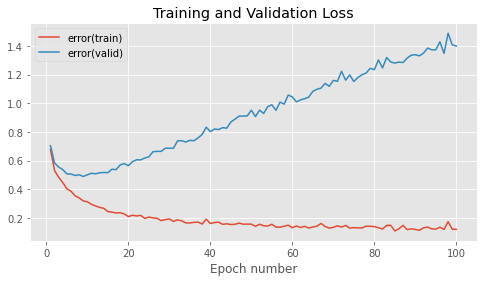

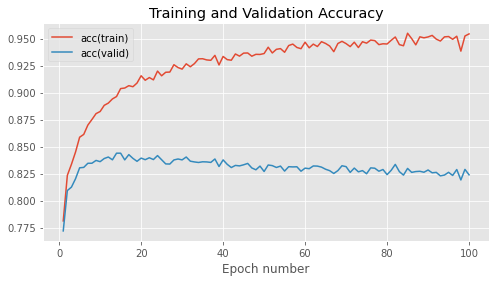

In [9]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialize weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Define Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Define error function
error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_hl_3, keys_hl_3, run_time_hl_3, activation_dict_hl_3 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_hl_3, keys_hl_3, run_time_hl_3, activation_dict_hl_3, 'hl_3')

## Analysis and Plotting of Baseline Experiments

### Analysis of results from varying the width of the network compared to initial network

### Analysis of results from varying the depth of the network compared to initial network

## Task 2: Mitigating the problem with Dropout and Weight Penalty
### c) EMNIST Experiments. In this section you should modify your baseline network to one that uses one or a combination of DropoutLayer with either L1Penalty or L2Penalty and train a model. For the experiments, your baseline network should contain 3 hidden layers and 128 hidden units with ReLU activation function.

In [10]:
from mlp.layers import DropoutLayer
from mlp.penalties import L1Penalty, L2Penalty

## Initialisation of Baseline Model with which we'll compare all variants

### Baseline Model
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

Epoch 1: 4.7s to complete
    error(train)=6.75e-01, acc(train)=7.85e-01, error(valid)=7.04e-01, acc(valid)=7.78e-01


Epoch 2: 4.9s to complete
    error(train)=5.58e-01, acc(train)=8.14e-01, error(valid)=6.12e-01, acc(valid)=8.01e-01


Epoch 3: 5.0s to complete
    error(train)=4.87e-01, acc(train)=8.31e-01, error(valid)=5.61e-01, acc(valid)=8.11e-01


Epoch 4: 5.3s to complete
    error(train)=4.52e-01, acc(train)=8.41e-01, error(valid)=5.34e-01, acc(valid)=8.21e-01


Epoch 5: 5.3s to complete
    error(train)=4.01e-01, acc(train)=8.58e-01, error(valid)=5.03e-01, acc(valid)=8.29e-01


Epoch 6: 4.9s to complete
    error(train)=3.80e-01, acc(train)=8.64e-01, error(valid)=4.97e-01, acc(valid)=8.34e-01


Epoch 7: 4.9s to complete
    error(train)=3.71e-01, acc(train)=8.63e-01, error(valid)=5.03e-01, acc(valid)=8.31e-01


Epoch 8: 5.1s to complete
    error(train)=3.45e-01, acc(train)=8.72e-01, error(valid)=4.94e-01, acc(valid)=8.33e-01


Epoch 9: 5.1s to complete
    error(train)=3.27e-01, acc(train)=8.78e-01, error(valid)=4.85e-01, acc(valid)=8.40e-01


Epoch 10: 5.2s to complete
    error(train)=3.11e-01, acc(train)=8.83e-01, error(valid)=4.88e-01, acc(valid)=8.39e-01


Epoch 11: 5.2s to complete
    error(train)=2.97e-01, acc(train)=8.89e-01, error(valid)=4.91e-01, acc(valid)=8.42e-01


Epoch 12: 5.1s to complete
    error(train)=2.91e-01, acc(train)=8.89e-01, error(valid)=5.04e-01, acc(valid)=8.41e-01


Epoch 13: 5.1s to complete
    error(train)=2.84e-01, acc(train)=8.92e-01, error(valid)=5.20e-01, acc(valid)=8.38e-01


Epoch 14: 5.1s to complete
    error(train)=2.56e-01, acc(train)=9.00e-01, error(valid)=4.98e-01, acc(valid)=8.45e-01


Epoch 15: 5.3s to complete
    error(train)=2.60e-01, acc(train)=8.98e-01, error(valid)=5.10e-01, acc(valid)=8.44e-01


Epoch 16: 5.2s to complete
    error(train)=2.43e-01, acc(train)=9.03e-01, error(valid)=5.15e-01, acc(valid)=8.41e-01


Epoch 17: 5.2s to complete
    error(train)=2.43e-01, acc(train)=9.04e-01, error(valid)=5.32e-01, acc(valid)=8.45e-01


Epoch 18: 5.1s to complete
    error(train)=2.50e-01, acc(train)=9.01e-01, error(valid)=5.55e-01, acc(valid)=8.35e-01


Epoch 19: 5.1s to complete
    error(train)=2.33e-01, acc(train)=9.07e-01, error(valid)=5.50e-01, acc(valid)=8.41e-01


Epoch 20: 5.1s to complete
    error(train)=2.34e-01, acc(train)=9.08e-01, error(valid)=5.89e-01, acc(valid)=8.36e-01


Epoch 21: 5.1s to complete
    error(train)=2.31e-01, acc(train)=9.08e-01, error(valid)=6.00e-01, acc(valid)=8.39e-01


Epoch 22: 5.3s to complete
    error(train)=2.38e-01, acc(train)=9.06e-01, error(valid)=5.85e-01, acc(valid)=8.32e-01


Epoch 23: 5.1s to complete
    error(train)=2.05e-01, acc(train)=9.16e-01, error(valid)=5.91e-01, acc(valid)=8.39e-01


Epoch 24: 5.2s to complete
    error(train)=2.03e-01, acc(train)=9.17e-01, error(valid)=5.98e-01, acc(valid)=8.38e-01


Epoch 25: 5.5s to complete
    error(train)=2.10e-01, acc(train)=9.16e-01, error(valid)=6.30e-01, acc(valid)=8.38e-01


Epoch 26: 5.4s to complete
    error(train)=2.11e-01, acc(train)=9.14e-01, error(valid)=6.56e-01, acc(valid)=8.33e-01


Epoch 27: 5.4s to complete
    error(train)=1.95e-01, acc(train)=9.21e-01, error(valid)=6.37e-01, acc(valid)=8.37e-01


Epoch 28: 5.8s to complete
    error(train)=1.93e-01, acc(train)=9.22e-01, error(valid)=6.57e-01, acc(valid)=8.38e-01


Epoch 29: 5.9s to complete
    error(train)=1.95e-01, acc(train)=9.20e-01, error(valid)=6.84e-01, acc(valid)=8.36e-01


Epoch 30: 5.3s to complete
    error(train)=2.02e-01, acc(train)=9.17e-01, error(valid)=6.97e-01, acc(valid)=8.34e-01


Epoch 31: 5.5s to complete
    error(train)=1.78e-01, acc(train)=9.28e-01, error(valid)=7.04e-01, acc(valid)=8.36e-01


Epoch 32: 5.1s to complete
    error(train)=1.81e-01, acc(train)=9.26e-01, error(valid)=7.08e-01, acc(valid)=8.37e-01


Epoch 33: 5.2s to complete
    error(train)=1.83e-01, acc(train)=9.26e-01, error(valid)=7.20e-01, acc(valid)=8.37e-01


Epoch 34: 5.3s to complete
    error(train)=1.91e-01, acc(train)=9.23e-01, error(valid)=7.49e-01, acc(valid)=8.32e-01


Epoch 35: 5.9s to complete
    error(train)=1.78e-01, acc(train)=9.28e-01, error(valid)=7.68e-01, acc(valid)=8.34e-01


Epoch 36: 5.7s to complete
    error(train)=1.61e-01, acc(train)=9.33e-01, error(valid)=7.38e-01, acc(valid)=8.39e-01


Epoch 37: 5.6s to complete
    error(train)=1.85e-01, acc(train)=9.25e-01, error(valid)=7.54e-01, acc(valid)=8.26e-01


Epoch 38: 5.5s to complete
    error(train)=1.84e-01, acc(train)=9.26e-01, error(valid)=8.15e-01, acc(valid)=8.27e-01


Epoch 39: 5.6s to complete
    error(train)=1.66e-01, acc(train)=9.32e-01, error(valid)=8.15e-01, acc(valid)=8.33e-01


Epoch 40: 5.5s to complete
    error(train)=1.70e-01, acc(train)=9.30e-01, error(valid)=8.09e-01, acc(valid)=8.30e-01


Epoch 41: 5.9s to complete
    error(train)=1.77e-01, acc(train)=9.26e-01, error(valid)=8.19e-01, acc(valid)=8.27e-01


Epoch 42: 6.1s to complete
    error(train)=1.60e-01, acc(train)=9.34e-01, error(valid)=8.27e-01, acc(valid)=8.29e-01


Epoch 43: 5.5s to complete
    error(train)=1.60e-01, acc(train)=9.36e-01, error(valid)=8.81e-01, acc(valid)=8.26e-01


Epoch 44: 5.3s to complete
    error(train)=1.59e-01, acc(train)=9.33e-01, error(valid)=8.62e-01, acc(valid)=8.30e-01


Epoch 45: 5.5s to complete
    error(train)=1.52e-01, acc(train)=9.38e-01, error(valid)=8.97e-01, acc(valid)=8.32e-01


Epoch 46: 5.3s to complete
    error(train)=1.63e-01, acc(train)=9.36e-01, error(valid)=9.43e-01, acc(valid)=8.27e-01


Epoch 47: 5.5s to complete
    error(train)=1.56e-01, acc(train)=9.36e-01, error(valid)=9.29e-01, acc(valid)=8.29e-01


Epoch 48: 6.0s to complete
    error(train)=1.48e-01, acc(train)=9.40e-01, error(valid)=9.34e-01, acc(valid)=8.31e-01


Epoch 49: 5.6s to complete
    error(train)=1.49e-01, acc(train)=9.38e-01, error(valid)=9.48e-01, acc(valid)=8.29e-01


Epoch 50: 5.3s to complete
    error(train)=1.48e-01, acc(train)=9.39e-01, error(valid)=9.28e-01, acc(valid)=8.30e-01


Epoch 51: 5.4s to complete
    error(train)=1.41e-01, acc(train)=9.43e-01, error(valid)=9.45e-01, acc(valid)=8.29e-01


Epoch 52: 5.2s to complete
    error(train)=1.63e-01, acc(train)=9.34e-01, error(valid)=1.00e+00, acc(valid)=8.26e-01


Epoch 53: 5.3s to complete
    error(train)=1.45e-01, acc(train)=9.41e-01, error(valid)=9.76e-01, acc(valid)=8.29e-01


Epoch 54: 5.8s to complete
    error(train)=1.46e-01, acc(train)=9.41e-01, error(valid)=1.00e+00, acc(valid)=8.31e-01


Epoch 55: 5.3s to complete
    error(train)=1.41e-01, acc(train)=9.43e-01, error(valid)=9.90e-01, acc(valid)=8.31e-01


Epoch 56: 5.4s to complete
    error(train)=1.58e-01, acc(train)=9.37e-01, error(valid)=1.00e+00, acc(valid)=8.26e-01


Epoch 57: 5.3s to complete
    error(train)=1.44e-01, acc(train)=9.42e-01, error(valid)=1.02e+00, acc(valid)=8.31e-01


Epoch 58: 5.3s to complete
    error(train)=1.59e-01, acc(train)=9.37e-01, error(valid)=1.02e+00, acc(valid)=8.27e-01


Epoch 59: 5.1s to complete
    error(train)=1.53e-01, acc(train)=9.39e-01, error(valid)=1.06e+00, acc(valid)=8.23e-01


Epoch 60: 5.4s to complete
    error(train)=1.49e-01, acc(train)=9.40e-01, error(valid)=1.01e+00, acc(valid)=8.26e-01


Epoch 61: 5.1s to complete
    error(train)=1.53e-01, acc(train)=9.40e-01, error(valid)=1.08e+00, acc(valid)=8.27e-01


Epoch 62: 5.3s to complete
    error(train)=1.40e-01, acc(train)=9.44e-01, error(valid)=1.06e+00, acc(valid)=8.22e-01


Epoch 63: 5.4s to complete
    error(train)=1.54e-01, acc(train)=9.38e-01, error(valid)=1.11e+00, acc(valid)=8.22e-01


Epoch 64: 5.2s to complete
    error(train)=1.37e-01, acc(train)=9.45e-01, error(valid)=1.05e+00, acc(valid)=8.28e-01


Epoch 65: 5.3s to complete
    error(train)=1.42e-01, acc(train)=9.43e-01, error(valid)=1.08e+00, acc(valid)=8.25e-01


Epoch 66: 5.1s to complete
    error(train)=1.33e-01, acc(train)=9.47e-01, error(valid)=1.11e+00, acc(valid)=8.25e-01


Epoch 67: 5.9s to complete
    error(train)=1.36e-01, acc(train)=9.45e-01, error(valid)=1.11e+00, acc(valid)=8.28e-01


Epoch 68: 5.3s to complete
    error(train)=1.41e-01, acc(train)=9.45e-01, error(valid)=1.10e+00, acc(valid)=8.25e-01


Epoch 69: 5.9s to complete
    error(train)=1.29e-01, acc(train)=9.47e-01, error(valid)=1.10e+00, acc(valid)=8.30e-01


Epoch 70: 5.3s to complete
    error(train)=1.38e-01, acc(train)=9.46e-01, error(valid)=1.12e+00, acc(valid)=8.28e-01


Epoch 71: 5.0s to complete
    error(train)=1.30e-01, acc(train)=9.48e-01, error(valid)=1.13e+00, acc(valid)=8.27e-01


Epoch 72: 5.3s to complete
    error(train)=1.46e-01, acc(train)=9.44e-01, error(valid)=1.23e+00, acc(valid)=8.24e-01


Epoch 73: 5.1s to complete
    error(train)=1.50e-01, acc(train)=9.43e-01, error(valid)=1.20e+00, acc(valid)=8.20e-01


Epoch 74: 5.9s to complete
    error(train)=1.37e-01, acc(train)=9.45e-01, error(valid)=1.20e+00, acc(valid)=8.25e-01


Epoch 75: 5.4s to complete
    error(train)=1.39e-01, acc(train)=9.45e-01, error(valid)=1.19e+00, acc(valid)=8.26e-01


Epoch 76: 5.4s to complete
    error(train)=1.53e-01, acc(train)=9.43e-01, error(valid)=1.26e+00, acc(valid)=8.22e-01


Epoch 77: 5.6s to complete
    error(train)=1.87e-01, acc(train)=9.35e-01, error(valid)=1.35e+00, acc(valid)=8.17e-01


Epoch 78: 5.7s to complete
    error(train)=1.23e-01, acc(train)=9.51e-01, error(valid)=1.19e+00, acc(valid)=8.26e-01


Epoch 79: 5.3s to complete
    error(train)=1.27e-01, acc(train)=9.50e-01, error(valid)=1.26e+00, acc(valid)=8.23e-01


Epoch 80: 5.6s to complete
    error(train)=1.34e-01, acc(train)=9.47e-01, error(valid)=1.24e+00, acc(valid)=8.26e-01


Epoch 81: 5.5s to complete
    error(train)=1.57e-01, acc(train)=9.42e-01, error(valid)=1.28e+00, acc(valid)=8.23e-01


Epoch 82: 5.2s to complete
    error(train)=1.40e-01, acc(train)=9.47e-01, error(valid)=1.30e+00, acc(valid)=8.21e-01


Epoch 83: 5.2s to complete
    error(train)=1.22e-01, acc(train)=9.51e-01, error(valid)=1.29e+00, acc(valid)=8.27e-01


Epoch 84: 5.3s to complete
    error(train)=1.42e-01, acc(train)=9.46e-01, error(valid)=1.33e+00, acc(valid)=8.22e-01


Epoch 85: 5.3s to complete
    error(train)=1.31e-01, acc(train)=9.49e-01, error(valid)=1.31e+00, acc(valid)=8.18e-01


Epoch 86: 5.4s to complete
    error(train)=1.32e-01, acc(train)=9.49e-01, error(valid)=1.27e+00, acc(valid)=8.21e-01


Epoch 87: 5.3s to complete
    error(train)=1.40e-01, acc(train)=9.46e-01, error(valid)=1.31e+00, acc(valid)=8.26e-01


Epoch 88: 5.2s to complete
    error(train)=1.19e-01, acc(train)=9.53e-01, error(valid)=1.31e+00, acc(valid)=8.28e-01


Epoch 89: 5.2s to complete
    error(train)=1.26e-01, acc(train)=9.50e-01, error(valid)=1.32e+00, acc(valid)=8.23e-01


Epoch 90: 5.2s to complete
    error(train)=1.30e-01, acc(train)=9.50e-01, error(valid)=1.40e+00, acc(valid)=8.26e-01


Epoch 91: 5.2s to complete
    error(train)=1.16e-01, acc(train)=9.53e-01, error(valid)=1.31e+00, acc(valid)=8.28e-01


Epoch 92: 5.2s to complete
    error(train)=1.31e-01, acc(train)=9.49e-01, error(valid)=1.34e+00, acc(valid)=8.24e-01


Epoch 93: 5.1s to complete
    error(train)=1.27e-01, acc(train)=9.51e-01, error(valid)=1.42e+00, acc(valid)=8.22e-01


Epoch 94: 5.1s to complete
    error(train)=1.42e-01, acc(train)=9.46e-01, error(valid)=1.42e+00, acc(valid)=8.22e-01


Epoch 95: 5.3s to complete
    error(train)=1.33e-01, acc(train)=9.50e-01, error(valid)=1.42e+00, acc(valid)=8.22e-01


Epoch 96: 5.1s to complete
    error(train)=1.21e-01, acc(train)=9.53e-01, error(valid)=1.45e+00, acc(valid)=8.24e-01


Epoch 97: 5.3s to complete
    error(train)=1.23e-01, acc(train)=9.53e-01, error(valid)=1.41e+00, acc(valid)=8.24e-01


Epoch 98: 5.7s to complete
    error(train)=1.25e-01, acc(train)=9.51e-01, error(valid)=1.45e+00, acc(valid)=8.24e-01


Epoch 99: 5.3s to complete
    error(train)=1.40e-01, acc(train)=9.49e-01, error(valid)=1.46e+00, acc(valid)=8.22e-01


Epoch 100: 5.5s to complete
    error(train)=1.28e-01, acc(train)=9.52e-01, error(valid)=1.45e+00, acc(valid)=8.24e-01


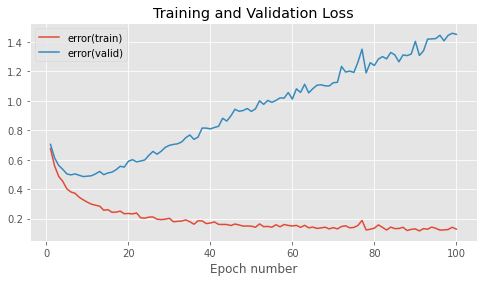

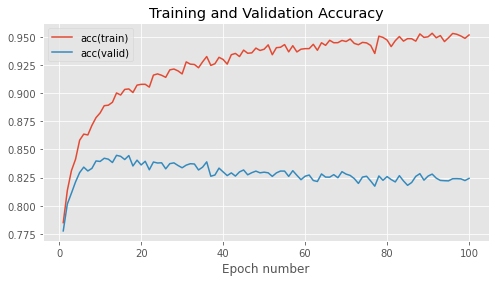

In [11]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Definition of Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_bl, keys_bl, runtime_bl, activation_dict_bl = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_bl, keys_bl, runtime_bl, activation_dict_bl, 'bl')

### Further Analyss: Absolute weight value for each layer, per epoch

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
def plot_weight_analysis(dict_weights, n_epochs):
    sns.set_style('darkgrid')
    fig = plt.figure(figsize=(15,8))

    colors = ['teal', 'yellowgreen', 'gold']
    epoch_list = list(range(1, n_epochs+1))

    lw = 2.5

    predictions = {}
    count = 0
    for key in  dict_weights.keys():
        if key == 0 or key == 2:
            pass
        elif key%2 ==0:
            hidden_layer_n = count+1
            plt.plot(epoch_list, dict_weights[key], color=colors[count], linewidth = lw, label="Hidden Layer %d" % hidden_layer_n)
            count += 1
        else:
            pass
    plt.title('Absolute Weight Value in Each Layer ',fontsize=15, fontweight="bold")
    plt.legend(loc='upper left', prop={'size': 15});
    plt.xlabel('Epoch', fontsize = 15)
    plt.ylabel('Absolute Average Weight Value', fontsize = 15)
    plt.show()

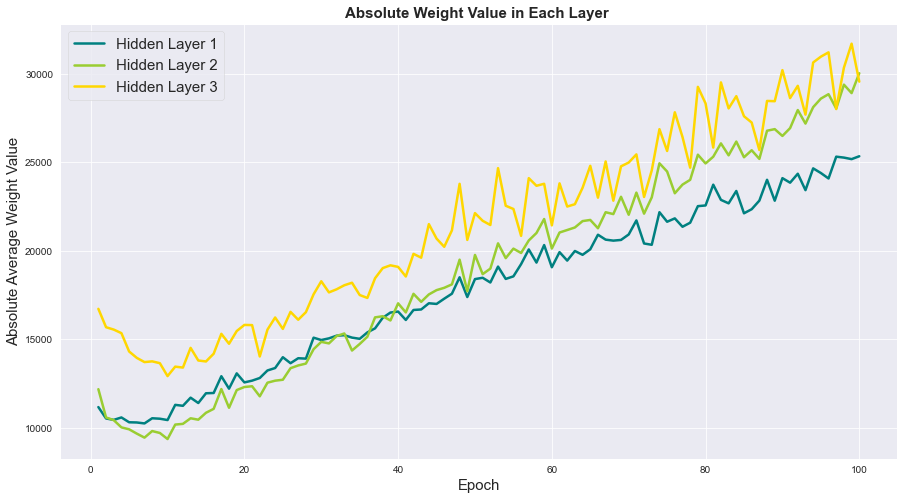

In [14]:
plot_weight_analysis(activation_dict_bl, 100)

## Study of the effect of Dropout

In [15]:
from mlp.layers import DropoutLayer
from mlp.penalties import L1Penalty, L2Penalty

### Model 1
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

Dropout of **0.2** in all Hidden Layers

Epoch 1: 6.6s to complete
    error(train)=3.50e+00, acc(train)=5.62e-02, error(valid)=3.50e+00, acc(valid)=5.65e-02


Epoch 2: 6.3s to complete
    error(train)=3.38e+00, acc(train)=6.74e-02, error(valid)=3.37e+00, acc(valid)=6.27e-02


Epoch 3: 6.5s to complete
    error(train)=3.23e+00, acc(train)=9.34e-02, error(valid)=3.24e+00, acc(valid)=8.76e-02


Epoch 4: 6.7s to complete
    error(train)=3.16e+00, acc(train)=9.95e-02, error(valid)=3.17e+00, acc(valid)=9.55e-02


Epoch 5: 6.7s to complete
    error(train)=3.09e+00, acc(train)=1.11e-01, error(valid)=3.09e+00, acc(valid)=1.12e-01


Epoch 6: 7.6s to complete
    error(train)=3.07e+00, acc(train)=1.12e-01, error(valid)=3.10e+00, acc(valid)=1.05e-01


Epoch 7: 6.4s to complete
    error(train)=3.02e+00, acc(train)=1.23e-01, error(valid)=3.04e+00, acc(valid)=1.16e-01


Epoch 8: 9.1s to complete
    error(train)=3.00e+00, acc(train)=1.20e-01, error(valid)=3.01e+00, acc(valid)=1.14e-01


Epoch 9: 8.9s to complete
    error(train)=2.97e+00, acc(train)=1.28e-01, error(valid)=3.00e+00, acc(valid)=1.26e-01


Epoch 10: 8.1s to complete
    error(train)=2.95e+00, acc(train)=1.34e-01, error(valid)=2.96e+00, acc(valid)=1.30e-01


Epoch 11: 8.6s to complete
    error(train)=2.94e+00, acc(train)=1.41e-01, error(valid)=2.94e+00, acc(valid)=1.33e-01


Epoch 12: 9.2s to complete
    error(train)=2.91e+00, acc(train)=1.40e-01, error(valid)=2.93e+00, acc(valid)=1.39e-01


Epoch 13: 8.8s to complete
    error(train)=2.90e+00, acc(train)=1.48e-01, error(valid)=2.92e+00, acc(valid)=1.39e-01


Epoch 14: 7.8s to complete
    error(train)=2.88e+00, acc(train)=1.49e-01, error(valid)=2.89e+00, acc(valid)=1.50e-01


Epoch 15: 8.2s to complete
    error(train)=2.86e+00, acc(train)=1.54e-01, error(valid)=2.87e+00, acc(valid)=1.49e-01


Epoch 16: 8.9s to complete
    error(train)=2.85e+00, acc(train)=1.62e-01, error(valid)=2.87e+00, acc(valid)=1.52e-01


Epoch 17: 8.4s to complete
    error(train)=2.84e+00, acc(train)=1.61e-01, error(valid)=2.81e+00, acc(valid)=1.66e-01


Epoch 18: 8.2s to complete
    error(train)=2.81e+00, acc(train)=1.70e-01, error(valid)=2.84e+00, acc(valid)=1.65e-01


Epoch 19: 8.1s to complete
    error(train)=2.79e+00, acc(train)=1.74e-01, error(valid)=2.80e+00, acc(valid)=1.75e-01


Epoch 20: 8.9s to complete
    error(train)=2.77e+00, acc(train)=1.81e-01, error(valid)=2.79e+00, acc(valid)=1.80e-01


Epoch 21: 8.2s to complete
    error(train)=2.75e+00, acc(train)=1.79e-01, error(valid)=2.81e+00, acc(valid)=1.72e-01


Epoch 22: 8.2s to complete
    error(train)=2.74e+00, acc(train)=1.90e-01, error(valid)=2.78e+00, acc(valid)=1.80e-01


Epoch 23: 9.0s to complete
    error(train)=2.73e+00, acc(train)=1.90e-01, error(valid)=2.75e+00, acc(valid)=1.85e-01


Epoch 24: 8.6s to complete
    error(train)=2.72e+00, acc(train)=1.93e-01, error(valid)=2.73e+00, acc(valid)=1.87e-01


Epoch 25: 8.7s to complete
    error(train)=2.70e+00, acc(train)=2.00e-01, error(valid)=2.72e+00, acc(valid)=1.99e-01


Epoch 26: 8.0s to complete
    error(train)=2.69e+00, acc(train)=2.00e-01, error(valid)=2.68e+00, acc(valid)=2.03e-01


Epoch 27: 8.2s to complete
    error(train)=2.69e+00, acc(train)=2.05e-01, error(valid)=2.71e+00, acc(valid)=2.01e-01


Epoch 28: 8.6s to complete
    error(train)=2.68e+00, acc(train)=2.03e-01, error(valid)=2.67e+00, acc(valid)=2.05e-01


Epoch 29: 8.1s to complete
    error(train)=2.68e+00, acc(train)=2.04e-01, error(valid)=2.68e+00, acc(valid)=2.02e-01


Epoch 30: 8.9s to complete
    error(train)=2.66e+00, acc(train)=2.13e-01, error(valid)=2.67e+00, acc(valid)=2.13e-01


Epoch 31: 9.3s to complete
    error(train)=2.65e+00, acc(train)=2.09e-01, error(valid)=2.65e+00, acc(valid)=2.08e-01


Epoch 32: 9.5s to complete
    error(train)=2.65e+00, acc(train)=2.17e-01, error(valid)=2.66e+00, acc(valid)=2.09e-01


Epoch 33: 8.6s to complete
    error(train)=2.64e+00, acc(train)=2.17e-01, error(valid)=2.65e+00, acc(valid)=2.21e-01


Epoch 34: 9.2s to complete
    error(train)=2.63e+00, acc(train)=2.23e-01, error(valid)=2.66e+00, acc(valid)=2.14e-01


Epoch 35: 8.3s to complete
    error(train)=2.64e+00, acc(train)=2.18e-01, error(valid)=2.62e+00, acc(valid)=2.24e-01


Epoch 36: 8.4s to complete
    error(train)=2.62e+00, acc(train)=2.23e-01, error(valid)=2.66e+00, acc(valid)=2.19e-01


Epoch 37: 9.2s to complete
    error(train)=2.61e+00, acc(train)=2.24e-01, error(valid)=2.62e+00, acc(valid)=2.24e-01


Epoch 38: 8.5s to complete
    error(train)=2.62e+00, acc(train)=2.25e-01, error(valid)=2.62e+00, acc(valid)=2.21e-01


Epoch 39: 9.0s to complete
    error(train)=2.61e+00, acc(train)=2.27e-01, error(valid)=2.62e+00, acc(valid)=2.25e-01


Epoch 40: 8.9s to complete
    error(train)=2.60e+00, acc(train)=2.26e-01, error(valid)=2.61e+00, acc(valid)=2.22e-01


Epoch 41: 8.1s to complete
    error(train)=2.60e+00, acc(train)=2.27e-01, error(valid)=2.62e+00, acc(valid)=2.18e-01


Epoch 42: 8.2s to complete
    error(train)=2.58e+00, acc(train)=2.32e-01, error(valid)=2.58e+00, acc(valid)=2.25e-01


Epoch 43: 9.5s to complete
    error(train)=2.59e+00, acc(train)=2.35e-01, error(valid)=2.60e+00, acc(valid)=2.30e-01


Epoch 44: 9.6s to complete
    error(train)=2.57e+00, acc(train)=2.34e-01, error(valid)=2.60e+00, acc(valid)=2.26e-01


Epoch 45: 9.5s to complete
    error(train)=2.56e+00, acc(train)=2.40e-01, error(valid)=2.57e+00, acc(valid)=2.40e-01


Epoch 46: 8.4s to complete
    error(train)=2.57e+00, acc(train)=2.35e-01, error(valid)=2.57e+00, acc(valid)=2.36e-01


Epoch 47: 8.4s to complete
    error(train)=2.55e+00, acc(train)=2.43e-01, error(valid)=2.58e+00, acc(valid)=2.35e-01


Epoch 48: 8.7s to complete
    error(train)=2.58e+00, acc(train)=2.34e-01, error(valid)=2.60e+00, acc(valid)=2.32e-01


Epoch 49: 8.5s to complete
    error(train)=2.56e+00, acc(train)=2.41e-01, error(valid)=2.57e+00, acc(valid)=2.42e-01


Epoch 50: 8.4s to complete
    error(train)=2.54e+00, acc(train)=2.46e-01, error(valid)=2.58e+00, acc(valid)=2.33e-01


Epoch 51: 10.3s to complete
    error(train)=2.56e+00, acc(train)=2.40e-01, error(valid)=2.60e+00, acc(valid)=2.38e-01


Epoch 52: 9.4s to complete
    error(train)=2.54e+00, acc(train)=2.42e-01, error(valid)=2.57e+00, acc(valid)=2.39e-01


Epoch 53: 9.5s to complete
    error(train)=2.53e+00, acc(train)=2.45e-01, error(valid)=2.53e+00, acc(valid)=2.53e-01


Epoch 54: 9.6s to complete
    error(train)=2.54e+00, acc(train)=2.42e-01, error(valid)=2.57e+00, acc(valid)=2.39e-01


Epoch 55: 8.9s to complete
    error(train)=2.54e+00, acc(train)=2.47e-01, error(valid)=2.57e+00, acc(valid)=2.41e-01


Epoch 56: 8.3s to complete
    error(train)=2.53e+00, acc(train)=2.46e-01, error(valid)=2.54e+00, acc(valid)=2.46e-01


Epoch 57: 8.1s to complete
    error(train)=2.53e+00, acc(train)=2.49e-01, error(valid)=2.51e+00, acc(valid)=2.48e-01


Epoch 58: 8.2s to complete
    error(train)=2.54e+00, acc(train)=2.48e-01, error(valid)=2.54e+00, acc(valid)=2.42e-01


Epoch 59: 9.8s to complete
    error(train)=2.52e+00, acc(train)=2.53e-01, error(valid)=2.48e+00, acc(valid)=2.59e-01


Epoch 60: 8.4s to complete
    error(train)=2.52e+00, acc(train)=2.51e-01, error(valid)=2.53e+00, acc(valid)=2.51e-01


Epoch 61: 8.5s to complete
    error(train)=2.51e+00, acc(train)=2.53e-01, error(valid)=2.54e+00, acc(valid)=2.49e-01


Epoch 62: 8.3s to complete
    error(train)=2.52e+00, acc(train)=2.50e-01, error(valid)=2.54e+00, acc(valid)=2.49e-01


Epoch 63: 9.5s to complete
    error(train)=2.52e+00, acc(train)=2.51e-01, error(valid)=2.53e+00, acc(valid)=2.53e-01


Epoch 64: 9.6s to complete
    error(train)=2.51e+00, acc(train)=2.53e-01, error(valid)=2.51e+00, acc(valid)=2.52e-01


Epoch 65: 8.9s to complete
    error(train)=2.50e+00, acc(train)=2.56e-01, error(valid)=2.49e+00, acc(valid)=2.53e-01


Epoch 66: 8.9s to complete
    error(train)=2.51e+00, acc(train)=2.56e-01, error(valid)=2.49e+00, acc(valid)=2.55e-01


Epoch 67: 8.1s to complete
    error(train)=2.51e+00, acc(train)=2.57e-01, error(valid)=2.48e+00, acc(valid)=2.60e-01


Epoch 68: 8.1s to complete
    error(train)=2.50e+00, acc(train)=2.54e-01, error(valid)=2.52e+00, acc(valid)=2.53e-01


Epoch 69: 8.2s to complete
    error(train)=2.49e+00, acc(train)=2.60e-01, error(valid)=2.51e+00, acc(valid)=2.58e-01


Epoch 70: 9.2s to complete
    error(train)=2.49e+00, acc(train)=2.57e-01, error(valid)=2.50e+00, acc(valid)=2.67e-01


Epoch 71: 8.1s to complete
    error(train)=2.49e+00, acc(train)=2.60e-01, error(valid)=2.48e+00, acc(valid)=2.64e-01


Epoch 72: 9.1s to complete
    error(train)=2.50e+00, acc(train)=2.55e-01, error(valid)=2.50e+00, acc(valid)=2.62e-01


Epoch 73: 8.0s to complete
    error(train)=2.50e+00, acc(train)=2.59e-01, error(valid)=2.49e+00, acc(valid)=2.64e-01


Epoch 74: 9.0s to complete
    error(train)=2.48e+00, acc(train)=2.58e-01, error(valid)=2.52e+00, acc(valid)=2.53e-01


Epoch 75: 8.7s to complete
    error(train)=2.49e+00, acc(train)=2.60e-01, error(valid)=2.52e+00, acc(valid)=2.58e-01


Epoch 76: 9.7s to complete
    error(train)=2.47e+00, acc(train)=2.66e-01, error(valid)=2.49e+00, acc(valid)=2.62e-01


Epoch 77: 9.8s to complete
    error(train)=2.47e+00, acc(train)=2.65e-01, error(valid)=2.48e+00, acc(valid)=2.69e-01


Epoch 78: 9.5s to complete
    error(train)=2.48e+00, acc(train)=2.62e-01, error(valid)=2.48e+00, acc(valid)=2.63e-01


Epoch 79: 8.4s to complete
    error(train)=2.47e+00, acc(train)=2.66e-01, error(valid)=2.50e+00, acc(valid)=2.59e-01


Epoch 80: 9.7s to complete
    error(train)=2.47e+00, acc(train)=2.67e-01, error(valid)=2.52e+00, acc(valid)=2.64e-01


Epoch 81: 8.8s to complete
    error(train)=2.47e+00, acc(train)=2.64e-01, error(valid)=2.50e+00, acc(valid)=2.62e-01


Epoch 82: 9.6s to complete
    error(train)=2.47e+00, acc(train)=2.66e-01, error(valid)=2.51e+00, acc(valid)=2.62e-01


Epoch 83: 9.0s to complete
    error(train)=2.46e+00, acc(train)=2.66e-01, error(valid)=2.44e+00, acc(valid)=2.63e-01


Epoch 84: 9.1s to complete
    error(train)=2.48e+00, acc(train)=2.60e-01, error(valid)=2.49e+00, acc(valid)=2.55e-01


Epoch 85: 8.4s to complete
    error(train)=2.45e+00, acc(train)=2.70e-01, error(valid)=2.48e+00, acc(valid)=2.57e-01


Epoch 86: 8.8s to complete
    error(train)=2.47e+00, acc(train)=2.67e-01, error(valid)=2.47e+00, acc(valid)=2.65e-01


Epoch 87: 8.8s to complete
    error(train)=2.46e+00, acc(train)=2.68e-01, error(valid)=2.45e+00, acc(valid)=2.70e-01


Epoch 88: 8.2s to complete
    error(train)=2.46e+00, acc(train)=2.67e-01, error(valid)=2.48e+00, acc(valid)=2.61e-01


Epoch 89: 8.7s to complete
    error(train)=2.46e+00, acc(train)=2.68e-01, error(valid)=2.49e+00, acc(valid)=2.60e-01


Epoch 90: 8.0s to complete
    error(train)=2.46e+00, acc(train)=2.71e-01, error(valid)=2.47e+00, acc(valid)=2.73e-01


Epoch 91: 9.6s to complete
    error(train)=2.46e+00, acc(train)=2.68e-01, error(valid)=2.48e+00, acc(valid)=2.57e-01


Epoch 92: 8.0s to complete
    error(train)=2.47e+00, acc(train)=2.69e-01, error(valid)=2.47e+00, acc(valid)=2.74e-01


Epoch 93: 9.7s to complete
    error(train)=2.46e+00, acc(train)=2.68e-01, error(valid)=2.47e+00, acc(valid)=2.67e-01


Epoch 94: 8.7s to complete
    error(train)=2.45e+00, acc(train)=2.71e-01, error(valid)=2.51e+00, acc(valid)=2.50e-01


Epoch 95: 8.8s to complete
    error(train)=2.45e+00, acc(train)=2.72e-01, error(valid)=2.47e+00, acc(valid)=2.68e-01


Epoch 96: 8.1s to complete
    error(train)=2.44e+00, acc(train)=2.73e-01, error(valid)=2.45e+00, acc(valid)=2.70e-01


Epoch 97: 8.0s to complete
    error(train)=2.45e+00, acc(train)=2.72e-01, error(valid)=2.49e+00, acc(valid)=2.67e-01


Epoch 98: 8.0s to complete
    error(train)=2.45e+00, acc(train)=2.70e-01, error(valid)=2.47e+00, acc(valid)=2.60e-01


Epoch 99: 8.7s to complete
    error(train)=2.43e+00, acc(train)=2.76e-01, error(valid)=2.43e+00, acc(valid)=2.77e-01


Epoch 100: 8.3s to complete
    error(train)=2.45e+00, acc(train)=2.74e-01, error(valid)=2.48e+00, acc(valid)=2.66e-01


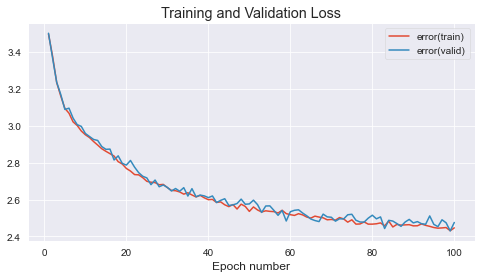

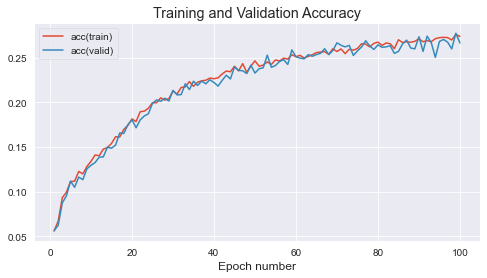

In [16]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Dropout random state
rng = np.random.RandomState(92019)

# Definition of Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.2),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.2),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.2),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])
    
# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule() # Using the default learning rate of 0.001

# Remember to use notebook=False when you write a script to be run in a terminal
stats_d_02, keys_d_02, runtime_d_02, activation_dict_d_02 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_d_02, keys_d_02, runtime_d_02, activation_dict_d_02, 'd_02')

### Model 2 
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

Dropout of **0.5** in all Hidden Layers

Epoch 1: 6.1s to complete
    error(train)=2.14e+00, acc(train)=3.65e-01, error(valid)=2.14e+00, acc(valid)=3.64e-01


Epoch 2: 6.6s to complete
    error(train)=1.83e+00, acc(train)=4.49e-01, error(valid)=1.82e+00, acc(valid)=4.53e-01


Epoch 3: 6.5s to complete
    error(train)=1.63e+00, acc(train)=5.06e-01, error(valid)=1.64e+00, acc(valid)=5.02e-01


Epoch 4: 6.3s to complete
    error(train)=1.52e+00, acc(train)=5.39e-01, error(valid)=1.51e+00, acc(valid)=5.41e-01


Epoch 5: 6.7s to complete
    error(train)=1.42e+00, acc(train)=5.65e-01, error(valid)=1.45e+00, acc(valid)=5.57e-01


Epoch 6: 7.0s to complete
    error(train)=1.38e+00, acc(train)=5.78e-01, error(valid)=1.41e+00, acc(valid)=5.74e-01


Epoch 7: 7.2s to complete
    error(train)=1.36e+00, acc(train)=5.84e-01, error(valid)=1.38e+00, acc(valid)=5.77e-01


Epoch 8: 7.8s to complete
    error(train)=1.33e+00, acc(train)=5.91e-01, error(valid)=1.35e+00, acc(valid)=5.83e-01


Epoch 9: 7.5s to complete
    error(train)=1.29e+00, acc(train)=6.02e-01, error(valid)=1.31e+00, acc(valid)=5.99e-01


Epoch 10: 6.5s to complete
    error(train)=1.26e+00, acc(train)=6.10e-01, error(valid)=1.27e+00, acc(valid)=6.08e-01


Epoch 11: 7.1s to complete
    error(train)=1.24e+00, acc(train)=6.17e-01, error(valid)=1.30e+00, acc(valid)=6.01e-01


Epoch 12: 7.3s to complete
    error(train)=1.22e+00, acc(train)=6.21e-01, error(valid)=1.25e+00, acc(valid)=6.13e-01


Epoch 13: 6.8s to complete
    error(train)=1.21e+00, acc(train)=6.26e-01, error(valid)=1.24e+00, acc(valid)=6.15e-01


Epoch 14: 6.9s to complete
    error(train)=1.21e+00, acc(train)=6.20e-01, error(valid)=1.24e+00, acc(valid)=6.17e-01


Epoch 15: 7.2s to complete
    error(train)=1.18e+00, acc(train)=6.32e-01, error(valid)=1.21e+00, acc(valid)=6.28e-01


Epoch 16: 7.2s to complete
    error(train)=1.16e+00, acc(train)=6.40e-01, error(valid)=1.20e+00, acc(valid)=6.31e-01


Epoch 17: 6.6s to complete
    error(train)=1.15e+00, acc(train)=6.43e-01, error(valid)=1.19e+00, acc(valid)=6.36e-01


Epoch 18: 7.2s to complete
    error(train)=1.14e+00, acc(train)=6.45e-01, error(valid)=1.18e+00, acc(valid)=6.40e-01


Epoch 19: 6.6s to complete
    error(train)=1.13e+00, acc(train)=6.49e-01, error(valid)=1.17e+00, acc(valid)=6.40e-01


Epoch 20: 7.1s to complete
    error(train)=1.13e+00, acc(train)=6.50e-01, error(valid)=1.17e+00, acc(valid)=6.41e-01


Epoch 21: 6.5s to complete
    error(train)=1.12e+00, acc(train)=6.53e-01, error(valid)=1.18e+00, acc(valid)=6.36e-01


Epoch 22: 7.5s to complete
    error(train)=1.12e+00, acc(train)=6.53e-01, error(valid)=1.17e+00, acc(valid)=6.37e-01


Epoch 23: 7.4s to complete
    error(train)=1.12e+00, acc(train)=6.55e-01, error(valid)=1.16e+00, acc(valid)=6.47e-01


Epoch 24: 6.5s to complete
    error(train)=1.11e+00, acc(train)=6.57e-01, error(valid)=1.14e+00, acc(valid)=6.49e-01


Epoch 25: 6.9s to complete
    error(train)=1.10e+00, acc(train)=6.59e-01, error(valid)=1.15e+00, acc(valid)=6.46e-01


Epoch 26: 6.6s to complete
    error(train)=1.09e+00, acc(train)=6.61e-01, error(valid)=1.14e+00, acc(valid)=6.49e-01


Epoch 27: 7.3s to complete
    error(train)=1.10e+00, acc(train)=6.58e-01, error(valid)=1.14e+00, acc(valid)=6.53e-01


Epoch 28: 7.7s to complete
    error(train)=1.08e+00, acc(train)=6.66e-01, error(valid)=1.13e+00, acc(valid)=6.58e-01


Epoch 29: 6.6s to complete
    error(train)=1.08e+00, acc(train)=6.66e-01, error(valid)=1.13e+00, acc(valid)=6.56e-01


Epoch 30: 6.5s to complete
    error(train)=1.09e+00, acc(train)=6.66e-01, error(valid)=1.13e+00, acc(valid)=6.55e-01


Epoch 31: 6.5s to complete
    error(train)=1.07e+00, acc(train)=6.66e-01, error(valid)=1.12e+00, acc(valid)=6.52e-01


Epoch 32: 7.8s to complete
    error(train)=1.08e+00, acc(train)=6.65e-01, error(valid)=1.13e+00, acc(valid)=6.56e-01


Epoch 33: 7.7s to complete
    error(train)=1.07e+00, acc(train)=6.66e-01, error(valid)=1.12e+00, acc(valid)=6.57e-01


Epoch 34: 7.2s to complete
    error(train)=1.07e+00, acc(train)=6.69e-01, error(valid)=1.14e+00, acc(valid)=6.55e-01


Epoch 35: 7.7s to complete
    error(train)=1.06e+00, acc(train)=6.74e-01, error(valid)=1.12e+00, acc(valid)=6.58e-01


Epoch 36: 6.6s to complete
    error(train)=1.06e+00, acc(train)=6.74e-01, error(valid)=1.09e+00, acc(valid)=6.66e-01


Epoch 37: 7.1s to complete
    error(train)=1.05e+00, acc(train)=6.75e-01, error(valid)=1.12e+00, acc(valid)=6.61e-01


Epoch 38: 6.5s to complete
    error(train)=1.04e+00, acc(train)=6.77e-01, error(valid)=1.10e+00, acc(valid)=6.66e-01


Epoch 39: 6.5s to complete
    error(train)=1.06e+00, acc(train)=6.74e-01, error(valid)=1.11e+00, acc(valid)=6.60e-01


Epoch 40: 7.0s to complete
    error(train)=1.05e+00, acc(train)=6.75e-01, error(valid)=1.13e+00, acc(valid)=6.54e-01


Epoch 41: 8.3s to complete
    error(train)=1.03e+00, acc(train)=6.81e-01, error(valid)=1.09e+00, acc(valid)=6.64e-01


Epoch 42: 7.0s to complete
    error(train)=1.04e+00, acc(train)=6.75e-01, error(valid)=1.11e+00, acc(valid)=6.63e-01


Epoch 43: 8.0s to complete
    error(train)=1.04e+00, acc(train)=6.80e-01, error(valid)=1.10e+00, acc(valid)=6.65e-01


Epoch 44: 7.7s to complete
    error(train)=1.04e+00, acc(train)=6.79e-01, error(valid)=1.12e+00, acc(valid)=6.58e-01


Epoch 45: 7.8s to complete
    error(train)=1.04e+00, acc(train)=6.80e-01, error(valid)=1.09e+00, acc(valid)=6.71e-01


Epoch 46: 6.8s to complete
    error(train)=1.03e+00, acc(train)=6.81e-01, error(valid)=1.10e+00, acc(valid)=6.70e-01


Epoch 47: 6.8s to complete
    error(train)=1.02e+00, acc(train)=6.81e-01, error(valid)=1.11e+00, acc(valid)=6.64e-01


Epoch 48: 6.7s to complete
    error(train)=1.03e+00, acc(train)=6.82e-01, error(valid)=1.08e+00, acc(valid)=6.67e-01


Epoch 49: 6.6s to complete
    error(train)=1.04e+00, acc(train)=6.77e-01, error(valid)=1.08e+00, acc(valid)=6.68e-01


Epoch 50: 6.5s to complete
    error(train)=1.03e+00, acc(train)=6.83e-01, error(valid)=1.08e+00, acc(valid)=6.74e-01


Epoch 51: 6.6s to complete
    error(train)=1.03e+00, acc(train)=6.81e-01, error(valid)=1.08e+00, acc(valid)=6.71e-01


Epoch 52: 7.5s to complete
    error(train)=1.02e+00, acc(train)=6.83e-01, error(valid)=1.09e+00, acc(valid)=6.65e-01


Epoch 53: 7.5s to complete
    error(train)=1.03e+00, acc(train)=6.81e-01, error(valid)=1.09e+00, acc(valid)=6.66e-01


Epoch 54: 6.7s to complete
    error(train)=1.02e+00, acc(train)=6.84e-01, error(valid)=1.09e+00, acc(valid)=6.67e-01


Epoch 55: 7.1s to complete
    error(train)=1.02e+00, acc(train)=6.87e-01, error(valid)=1.10e+00, acc(valid)=6.68e-01


Epoch 56: 6.6s to complete
    error(train)=1.02e+00, acc(train)=6.83e-01, error(valid)=1.10e+00, acc(valid)=6.69e-01


Epoch 57: 6.5s to complete
    error(train)=1.02e+00, acc(train)=6.89e-01, error(valid)=1.08e+00, acc(valid)=6.72e-01


Epoch 58: 7.3s to complete
    error(train)=1.01e+00, acc(train)=6.86e-01, error(valid)=1.09e+00, acc(valid)=6.72e-01


Epoch 59: 6.9s to complete
    error(train)=1.02e+00, acc(train)=6.85e-01, error(valid)=1.05e+00, acc(valid)=6.81e-01


Epoch 60: 7.6s to complete
    error(train)=1.00e+00, acc(train)=6.89e-01, error(valid)=1.08e+00, acc(valid)=6.72e-01


Epoch 61: 7.0s to complete
    error(train)=1.02e+00, acc(train)=6.84e-01, error(valid)=1.09e+00, acc(valid)=6.67e-01


Epoch 62: 6.7s to complete
    error(train)=1.01e+00, acc(train)=6.90e-01, error(valid)=1.06e+00, acc(valid)=6.76e-01


Epoch 63: 7.2s to complete
    error(train)=1.00e+00, acc(train)=6.90e-01, error(valid)=1.07e+00, acc(valid)=6.76e-01


Epoch 64: 6.6s to complete
    error(train)=1.01e+00, acc(train)=6.88e-01, error(valid)=1.08e+00, acc(valid)=6.67e-01


Epoch 65: 6.6s to complete
    error(train)=1.01e+00, acc(train)=6.88e-01, error(valid)=1.06e+00, acc(valid)=6.73e-01


Epoch 66: 8.2s to complete
    error(train)=1.00e+00, acc(train)=6.90e-01, error(valid)=1.07e+00, acc(valid)=6.75e-01


Epoch 67: 7.1s to complete
    error(train)=1.01e+00, acc(train)=6.89e-01, error(valid)=1.06e+00, acc(valid)=6.78e-01


Epoch 68: 6.6s to complete
    error(train)=1.01e+00, acc(train)=6.89e-01, error(valid)=1.07e+00, acc(valid)=6.73e-01


Epoch 69: 6.7s to complete
    error(train)=1.01e+00, acc(train)=6.87e-01, error(valid)=1.06e+00, acc(valid)=6.78e-01


Epoch 70: 6.9s to complete
    error(train)=9.97e-01, acc(train)=6.91e-01, error(valid)=1.06e+00, acc(valid)=6.76e-01


Epoch 71: 7.1s to complete
    error(train)=1.01e+00, acc(train)=6.87e-01, error(valid)=1.06e+00, acc(valid)=6.76e-01


Epoch 72: 8.1s to complete
    error(train)=1.01e+00, acc(train)=6.89e-01, error(valid)=1.07e+00, acc(valid)=6.75e-01


Epoch 73: 7.5s to complete
    error(train)=9.96e-01, acc(train)=6.92e-01, error(valid)=1.06e+00, acc(valid)=6.81e-01


Epoch 74: 7.9s to complete
    error(train)=9.96e-01, acc(train)=6.91e-01, error(valid)=1.07e+00, acc(valid)=6.74e-01


Epoch 75: 7.9s to complete
    error(train)=9.99e-01, acc(train)=6.91e-01, error(valid)=1.09e+00, acc(valid)=6.71e-01


Epoch 76: 7.8s to complete
    error(train)=9.95e-01, acc(train)=6.90e-01, error(valid)=1.05e+00, acc(valid)=6.76e-01


Epoch 77: 7.9s to complete
    error(train)=9.93e-01, acc(train)=6.93e-01, error(valid)=1.07e+00, acc(valid)=6.80e-01


Epoch 78: 7.9s to complete
    error(train)=9.96e-01, acc(train)=6.91e-01, error(valid)=1.08e+00, acc(valid)=6.75e-01


Epoch 79: 8.1s to complete
    error(train)=9.95e-01, acc(train)=6.92e-01, error(valid)=1.08e+00, acc(valid)=6.74e-01


Epoch 80: 8.1s to complete
    error(train)=9.90e-01, acc(train)=6.93e-01, error(valid)=1.06e+00, acc(valid)=6.79e-01


Epoch 81: 7.9s to complete
    error(train)=9.85e-01, acc(train)=6.96e-01, error(valid)=1.04e+00, acc(valid)=6.85e-01


Epoch 82: 8.6s to complete
    error(train)=9.92e-01, acc(train)=6.94e-01, error(valid)=1.03e+00, acc(valid)=6.88e-01


Epoch 83: 7.7s to complete
    error(train)=9.84e-01, acc(train)=6.95e-01, error(valid)=1.04e+00, acc(valid)=6.85e-01


Epoch 84: 8.0s to complete
    error(train)=9.89e-01, acc(train)=6.94e-01, error(valid)=1.04e+00, acc(valid)=6.83e-01


Epoch 85: 8.1s to complete
    error(train)=9.92e-01, acc(train)=6.91e-01, error(valid)=1.06e+00, acc(valid)=6.77e-01


Epoch 86: 6.9s to complete
    error(train)=9.93e-01, acc(train)=6.94e-01, error(valid)=1.05e+00, acc(valid)=6.80e-01


Epoch 87: 6.3s to complete
    error(train)=9.85e-01, acc(train)=6.96e-01, error(valid)=1.04e+00, acc(valid)=6.80e-01


Epoch 88: 6.3s to complete
    error(train)=9.84e-01, acc(train)=6.96e-01, error(valid)=1.04e+00, acc(valid)=6.84e-01


Epoch 89: 6.3s to complete
    error(train)=9.82e-01, acc(train)=6.97e-01, error(valid)=1.06e+00, acc(valid)=6.80e-01


Epoch 90: 6.3s to complete
    error(train)=9.87e-01, acc(train)=6.94e-01, error(valid)=1.07e+00, acc(valid)=6.76e-01


Epoch 91: 7.3s to complete
    error(train)=9.77e-01, acc(train)=6.97e-01, error(valid)=1.03e+00, acc(valid)=6.84e-01


Epoch 92: 6.6s to complete
    error(train)=9.86e-01, acc(train)=6.97e-01, error(valid)=1.05e+00, acc(valid)=6.80e-01


Epoch 93: 7.4s to complete
    error(train)=9.85e-01, acc(train)=6.94e-01, error(valid)=1.05e+00, acc(valid)=6.82e-01


Epoch 94: 7.7s to complete
    error(train)=9.79e-01, acc(train)=6.99e-01, error(valid)=1.03e+00, acc(valid)=6.86e-01


Epoch 95: 8.0s to complete
    error(train)=9.75e-01, acc(train)=6.98e-01, error(valid)=1.04e+00, acc(valid)=6.83e-01


Epoch 96: 7.8s to complete
    error(train)=9.69e-01, acc(train)=7.00e-01, error(valid)=1.05e+00, acc(valid)=6.82e-01


Epoch 97: 7.8s to complete
    error(train)=9.83e-01, acc(train)=6.96e-01, error(valid)=1.07e+00, acc(valid)=6.76e-01


Epoch 98: 7.9s to complete
    error(train)=9.82e-01, acc(train)=6.98e-01, error(valid)=1.06e+00, acc(valid)=6.79e-01


Epoch 99: 7.7s to complete
    error(train)=9.77e-01, acc(train)=6.97e-01, error(valid)=1.05e+00, acc(valid)=6.80e-01


Epoch 100: 7.8s to complete
    error(train)=9.79e-01, acc(train)=6.96e-01, error(valid)=1.05e+00, acc(valid)=6.79e-01


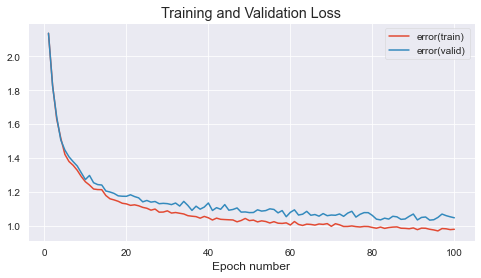

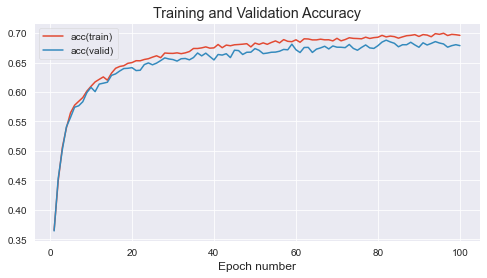

In [17]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Dropout random state
rng = np.random.RandomState(92019)

# Definition of Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.5),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.5),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.5),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])
    
# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_d_05, keys_d_05, runtime_d_05, activation_dict_d_05 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_d_05, keys_d_05, runtime_d_05, activation_dict_d_05, 'd_05')

### Model 3
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

Dropout  **in a decreasing fashion** 0.8, 0.5, 0.2

Epoch 1: 7.4s to complete
    error(train)=2.39e+00, acc(train)=2.85e-01, error(valid)=2.39e+00, acc(valid)=2.86e-01


Epoch 2: 7.7s to complete
    error(train)=1.98e+00, acc(train)=3.90e-01, error(valid)=2.00e+00, acc(valid)=3.86e-01


Epoch 3: 7.6s to complete
    error(train)=1.79e+00, acc(train)=4.46e-01, error(valid)=1.79e+00, acc(valid)=4.46e-01


Epoch 4: 7.5s to complete
    error(train)=1.64e+00, acc(train)=4.88e-01, error(valid)=1.68e+00, acc(valid)=4.72e-01


Epoch 5: 7.3s to complete
    error(train)=1.55e+00, acc(train)=5.14e-01, error(valid)=1.56e+00, acc(valid)=5.11e-01


Epoch 6: 7.3s to complete
    error(train)=1.47e+00, acc(train)=5.35e-01, error(valid)=1.54e+00, acc(valid)=5.16e-01


Epoch 7: 7.9s to complete
    error(train)=1.42e+00, acc(train)=5.55e-01, error(valid)=1.44e+00, acc(valid)=5.52e-01


Epoch 8: 7.8s to complete
    error(train)=1.40e+00, acc(train)=5.59e-01, error(valid)=1.43e+00, acc(valid)=5.56e-01


Epoch 9: 7.7s to complete
    error(train)=1.35e+00, acc(train)=5.78e-01, error(valid)=1.39e+00, acc(valid)=5.69e-01


Epoch 10: 8.3s to complete
    error(train)=1.31e+00, acc(train)=5.89e-01, error(valid)=1.37e+00, acc(valid)=5.72e-01


Epoch 11: 8.1s to complete
    error(train)=1.32e+00, acc(train)=5.87e-01, error(valid)=1.38e+00, acc(valid)=5.75e-01


Epoch 12: 8.1s to complete
    error(train)=1.25e+00, acc(train)=6.09e-01, error(valid)=1.33e+00, acc(valid)=5.87e-01


Epoch 13: 8.3s to complete
    error(train)=1.24e+00, acc(train)=6.06e-01, error(valid)=1.27e+00, acc(valid)=6.02e-01


Epoch 14: 8.1s to complete
    error(train)=1.23e+00, acc(train)=6.13e-01, error(valid)=1.24e+00, acc(valid)=6.16e-01


Epoch 15: 8.1s to complete
    error(train)=1.22e+00, acc(train)=6.13e-01, error(valid)=1.27e+00, acc(valid)=6.02e-01


Epoch 16: 8.1s to complete
    error(train)=1.19e+00, acc(train)=6.21e-01, error(valid)=1.28e+00, acc(valid)=5.96e-01


Epoch 17: 8.4s to complete
    error(train)=1.16e+00, acc(train)=6.30e-01, error(valid)=1.23e+00, acc(valid)=6.15e-01


Epoch 18: 8.3s to complete
    error(train)=1.17e+00, acc(train)=6.29e-01, error(valid)=1.23e+00, acc(valid)=6.17e-01


Epoch 19: 8.2s to complete
    error(train)=1.15e+00, acc(train)=6.32e-01, error(valid)=1.26e+00, acc(valid)=6.09e-01


Epoch 20: 8.8s to complete
    error(train)=1.15e+00, acc(train)=6.37e-01, error(valid)=1.21e+00, acc(valid)=6.24e-01


Epoch 21: 6.8s to complete
    error(train)=1.12e+00, acc(train)=6.42e-01, error(valid)=1.21e+00, acc(valid)=6.24e-01


Epoch 22: 7.1s to complete
    error(train)=1.13e+00, acc(train)=6.44e-01, error(valid)=1.18e+00, acc(valid)=6.31e-01


Epoch 23: 8.6s to complete
    error(train)=1.10e+00, acc(train)=6.48e-01, error(valid)=1.19e+00, acc(valid)=6.38e-01


Epoch 24: 8.7s to complete
    error(train)=1.11e+00, acc(train)=6.46e-01, error(valid)=1.21e+00, acc(valid)=6.30e-01


Epoch 25: 8.0s to complete
    error(train)=1.10e+00, acc(train)=6.50e-01, error(valid)=1.17e+00, acc(valid)=6.41e-01


Epoch 26: 8.0s to complete
    error(train)=1.10e+00, acc(train)=6.52e-01, error(valid)=1.17e+00, acc(valid)=6.37e-01


Epoch 27: 8.0s to complete
    error(train)=1.08e+00, acc(train)=6.57e-01, error(valid)=1.16e+00, acc(valid)=6.44e-01


Epoch 28: 7.9s to complete
    error(train)=1.08e+00, acc(train)=6.56e-01, error(valid)=1.16e+00, acc(valid)=6.41e-01


Epoch 29: 8.1s to complete
    error(train)=1.08e+00, acc(train)=6.59e-01, error(valid)=1.13e+00, acc(valid)=6.53e-01


Epoch 30: 8.2s to complete
    error(train)=1.07e+00, acc(train)=6.58e-01, error(valid)=1.12e+00, acc(valid)=6.48e-01


Epoch 31: 8.1s to complete
    error(train)=1.06e+00, acc(train)=6.62e-01, error(valid)=1.14e+00, acc(valid)=6.46e-01


Epoch 32: 8.1s to complete
    error(train)=1.05e+00, acc(train)=6.65e-01, error(valid)=1.13e+00, acc(valid)=6.51e-01


Epoch 33: 8.4s to complete
    error(train)=1.04e+00, acc(train)=6.70e-01, error(valid)=1.14e+00, acc(valid)=6.52e-01


Epoch 34: 8.4s to complete
    error(train)=1.05e+00, acc(train)=6.69e-01, error(valid)=1.13e+00, acc(valid)=6.51e-01


Epoch 35: 8.2s to complete
    error(train)=1.05e+00, acc(train)=6.66e-01, error(valid)=1.13e+00, acc(valid)=6.57e-01


Epoch 36: 8.3s to complete
    error(train)=1.02e+00, acc(train)=6.73e-01, error(valid)=1.12e+00, acc(valid)=6.52e-01


Epoch 37: 8.2s to complete
    error(train)=1.03e+00, acc(train)=6.71e-01, error(valid)=1.11e+00, acc(valid)=6.58e-01


Epoch 38: 8.3s to complete
    error(train)=1.04e+00, acc(train)=6.68e-01, error(valid)=1.15e+00, acc(valid)=6.40e-01


Epoch 39: 8.3s to complete
    error(train)=1.02e+00, acc(train)=6.74e-01, error(valid)=1.16e+00, acc(valid)=6.48e-01


Epoch 40: 8.5s to complete
    error(train)=1.03e+00, acc(train)=6.70e-01, error(valid)=1.13e+00, acc(valid)=6.52e-01


Epoch 41: 8.5s to complete
    error(train)=1.03e+00, acc(train)=6.73e-01, error(valid)=1.11e+00, acc(valid)=6.59e-01


Epoch 42: 8.4s to complete
    error(train)=1.02e+00, acc(train)=6.76e-01, error(valid)=1.13e+00, acc(valid)=6.49e-01


Epoch 43: 7.9s to complete
    error(train)=1.02e+00, acc(train)=6.76e-01, error(valid)=1.09e+00, acc(valid)=6.69e-01


Epoch 44: 7.9s to complete
    error(train)=1.00e+00, acc(train)=6.79e-01, error(valid)=1.12e+00, acc(valid)=6.50e-01


Epoch 45: 8.0s to complete
    error(train)=1.01e+00, acc(train)=6.76e-01, error(valid)=1.14e+00, acc(valid)=6.53e-01


Epoch 46: 7.9s to complete
    error(train)=1.01e+00, acc(train)=6.79e-01, error(valid)=1.11e+00, acc(valid)=6.55e-01


Epoch 47: 7.4s to complete
    error(train)=9.96e-01, acc(train)=6.83e-01, error(valid)=1.10e+00, acc(valid)=6.63e-01


Epoch 48: 8.4s to complete
    error(train)=9.87e-01, acc(train)=6.85e-01, error(valid)=1.10e+00, acc(valid)=6.61e-01


Epoch 49: 6.7s to complete
    error(train)=9.97e-01, acc(train)=6.81e-01, error(valid)=1.13e+00, acc(valid)=6.50e-01


Epoch 50: 7.7s to complete
    error(train)=1.00e+00, acc(train)=6.81e-01, error(valid)=1.13e+00, acc(valid)=6.55e-01


Epoch 51: 7.6s to complete
    error(train)=1.00e+00, acc(train)=6.80e-01, error(valid)=1.08e+00, acc(valid)=6.64e-01


Epoch 52: 8.3s to complete
    error(train)=9.95e-01, acc(train)=6.84e-01, error(valid)=1.10e+00, acc(valid)=6.66e-01


Epoch 53: 7.6s to complete
    error(train)=9.84e-01, acc(train)=6.85e-01, error(valid)=1.13e+00, acc(valid)=6.55e-01


Epoch 54: 7.0s to complete
    error(train)=9.90e-01, acc(train)=6.85e-01, error(valid)=1.09e+00, acc(valid)=6.65e-01


Epoch 55: 6.8s to complete
    error(train)=9.91e-01, acc(train)=6.87e-01, error(valid)=1.09e+00, acc(valid)=6.68e-01


Epoch 56: 6.8s to complete
    error(train)=9.97e-01, acc(train)=6.79e-01, error(valid)=1.11e+00, acc(valid)=6.55e-01


Epoch 57: 6.8s to complete
    error(train)=9.74e-01, acc(train)=6.91e-01, error(valid)=1.11e+00, acc(valid)=6.65e-01


Epoch 58: 7.0s to complete
    error(train)=9.76e-01, acc(train)=6.91e-01, error(valid)=1.09e+00, acc(valid)=6.66e-01


Epoch 59: 8.2s to complete
    error(train)=9.72e-01, acc(train)=6.91e-01, error(valid)=1.08e+00, acc(valid)=6.67e-01


Epoch 60: 7.3s to complete
    error(train)=9.79e-01, acc(train)=6.88e-01, error(valid)=1.09e+00, acc(valid)=6.63e-01


Epoch 61: 7.5s to complete
    error(train)=9.79e-01, acc(train)=6.90e-01, error(valid)=1.06e+00, acc(valid)=6.77e-01


Epoch 62: 7.6s to complete
    error(train)=9.70e-01, acc(train)=6.93e-01, error(valid)=1.10e+00, acc(valid)=6.67e-01


Epoch 63: 7.4s to complete
    error(train)=9.70e-01, acc(train)=6.93e-01, error(valid)=1.08e+00, acc(valid)=6.72e-01


Epoch 64: 7.3s to complete
    error(train)=9.70e-01, acc(train)=6.92e-01, error(valid)=1.08e+00, acc(valid)=6.70e-01


Epoch 65: 8.4s to complete
    error(train)=9.63e-01, acc(train)=6.94e-01, error(valid)=1.08e+00, acc(valid)=6.65e-01


Epoch 66: 7.1s to complete
    error(train)=9.69e-01, acc(train)=6.93e-01, error(valid)=1.08e+00, acc(valid)=6.69e-01


Epoch 67: 7.2s to complete
    error(train)=9.61e-01, acc(train)=6.96e-01, error(valid)=1.10e+00, acc(valid)=6.68e-01


Epoch 68: 6.9s to complete
    error(train)=9.49e-01, acc(train)=6.96e-01, error(valid)=1.06e+00, acc(valid)=6.73e-01


Epoch 69: 7.0s to complete
    error(train)=9.68e-01, acc(train)=6.93e-01, error(valid)=1.09e+00, acc(valid)=6.72e-01


Epoch 70: 7.1s to complete
    error(train)=9.60e-01, acc(train)=6.97e-01, error(valid)=1.06e+00, acc(valid)=6.72e-01


Epoch 71: 7.1s to complete
    error(train)=9.63e-01, acc(train)=6.95e-01, error(valid)=1.09e+00, acc(valid)=6.70e-01


Epoch 72: 7.5s to complete
    error(train)=9.54e-01, acc(train)=6.99e-01, error(valid)=1.06e+00, acc(valid)=6.77e-01


Epoch 73: 7.1s to complete
    error(train)=9.66e-01, acc(train)=6.93e-01, error(valid)=1.09e+00, acc(valid)=6.75e-01


Epoch 74: 6.9s to complete
    error(train)=9.57e-01, acc(train)=6.97e-01, error(valid)=1.09e+00, acc(valid)=6.71e-01


Epoch 75: 6.9s to complete
    error(train)=9.46e-01, acc(train)=7.00e-01, error(valid)=1.09e+00, acc(valid)=6.72e-01


Epoch 76: 7.7s to complete
    error(train)=9.42e-01, acc(train)=7.02e-01, error(valid)=1.07e+00, acc(valid)=6.77e-01


Epoch 77: 7.0s to complete
    error(train)=9.58e-01, acc(train)=6.98e-01, error(valid)=1.08e+00, acc(valid)=6.75e-01


Epoch 78: 8.1s to complete
    error(train)=9.60e-01, acc(train)=6.97e-01, error(valid)=1.09e+00, acc(valid)=6.68e-01


Epoch 79: 6.9s to complete
    error(train)=9.56e-01, acc(train)=6.98e-01, error(valid)=1.08e+00, acc(valid)=6.73e-01


Epoch 80: 7.6s to complete
    error(train)=9.45e-01, acc(train)=7.01e-01, error(valid)=1.06e+00, acc(valid)=6.78e-01


Epoch 81: 7.8s to complete
    error(train)=9.49e-01, acc(train)=7.01e-01, error(valid)=1.06e+00, acc(valid)=6.82e-01


Epoch 82: 7.2s to complete
    error(train)=9.43e-01, acc(train)=7.04e-01, error(valid)=1.06e+00, acc(valid)=6.74e-01


Epoch 83: 6.9s to complete
    error(train)=9.44e-01, acc(train)=7.01e-01, error(valid)=1.05e+00, acc(valid)=6.82e-01


Epoch 84: 7.9s to complete
    error(train)=9.49e-01, acc(train)=7.01e-01, error(valid)=1.05e+00, acc(valid)=6.89e-01


Epoch 85: 6.9s to complete
    error(train)=9.39e-01, acc(train)=7.02e-01, error(valid)=1.05e+00, acc(valid)=6.82e-01


Epoch 86: 7.4s to complete
    error(train)=9.49e-01, acc(train)=7.01e-01, error(valid)=1.06e+00, acc(valid)=6.81e-01


Epoch 87: 6.8s to complete
    error(train)=9.45e-01, acc(train)=7.03e-01, error(valid)=1.06e+00, acc(valid)=6.81e-01


Epoch 88: 7.1s to complete
    error(train)=9.32e-01, acc(train)=7.04e-01, error(valid)=1.04e+00, acc(valid)=6.89e-01


Epoch 89: 7.1s to complete
    error(train)=9.30e-01, acc(train)=7.06e-01, error(valid)=1.06e+00, acc(valid)=6.80e-01


Epoch 90: 6.8s to complete
    error(train)=9.43e-01, acc(train)=7.04e-01, error(valid)=1.06e+00, acc(valid)=6.80e-01


Epoch 91: 6.7s to complete
    error(train)=9.31e-01, acc(train)=7.06e-01, error(valid)=1.08e+00, acc(valid)=6.79e-01


Epoch 92: 6.9s to complete
    error(train)=9.33e-01, acc(train)=7.08e-01, error(valid)=1.06e+00, acc(valid)=6.79e-01


Epoch 93: 7.1s to complete
    error(train)=9.34e-01, acc(train)=7.07e-01, error(valid)=1.06e+00, acc(valid)=6.82e-01


Epoch 94: 7.5s to complete
    error(train)=9.28e-01, acc(train)=7.07e-01, error(valid)=1.06e+00, acc(valid)=6.81e-01


Epoch 95: 7.5s to complete
    error(train)=9.38e-01, acc(train)=7.04e-01, error(valid)=1.05e+00, acc(valid)=6.81e-01


Epoch 96: 6.8s to complete
    error(train)=9.33e-01, acc(train)=7.04e-01, error(valid)=1.04e+00, acc(valid)=6.84e-01


Epoch 97: 8.1s to complete
    error(train)=9.32e-01, acc(train)=7.07e-01, error(valid)=1.07e+00, acc(valid)=6.82e-01


Epoch 98: 7.8s to complete
    error(train)=9.37e-01, acc(train)=7.06e-01, error(valid)=1.04e+00, acc(valid)=6.91e-01


Epoch 99: 7.6s to complete
    error(train)=9.22e-01, acc(train)=7.09e-01, error(valid)=1.04e+00, acc(valid)=6.85e-01


Epoch 100: 8.1s to complete
    error(train)=9.21e-01, acc(train)=7.11e-01, error(valid)=1.04e+00, acc(valid)=6.88e-01


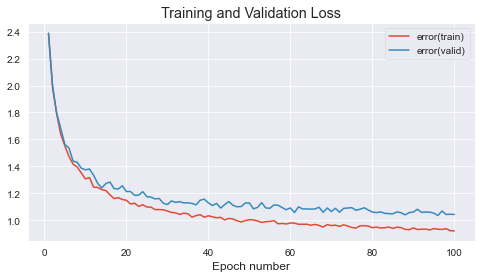

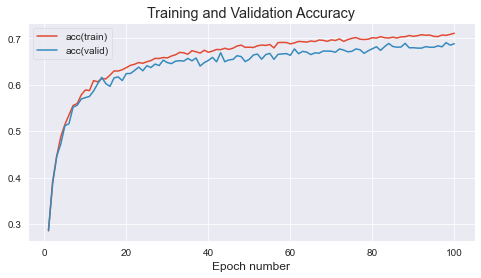

In [18]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Dropout random state
rng = np.random.RandomState(92019)

# Definition of Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.8),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.5),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.2),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])
    
# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_d_decf, keys_d_decf, runtime_d_decf, activation_d_decf = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_d_decf, keys_d_decf, runtime_d_decf, activation_d_decf, 'd_decf')

## Study of the effect of L2 Regularization

### Model 1
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

L2 regularisation penalty of  **0.0001** in all layers

Epoch 1: 5.4s to complete
    error(train)=6.99e-01, acc(train)=7.72e-01, error(valid)=7.19e-01, acc(valid)=7.67e-01


Epoch 2: 5.2s to complete
    error(train)=5.24e-01, acc(train)=8.25e-01, error(valid)=5.65e-01, acc(valid)=8.15e-01


Epoch 3: 5.1s to complete
    error(train)=5.07e-01, acc(train)=8.27e-01, error(valid)=5.62e-01, acc(valid)=8.14e-01


Epoch 4: 5.1s to complete
    error(train)=4.60e-01, acc(train)=8.40e-01, error(valid)=5.41e-01, acc(valid)=8.19e-01


Epoch 5: 5.5s to complete
    error(train)=4.17e-01, acc(train)=8.54e-01, error(valid)=5.05e-01, acc(valid)=8.33e-01


Epoch 6: 5.1s to complete
    error(train)=4.02e-01, acc(train)=8.55e-01, error(valid)=5.03e-01, acc(valid)=8.30e-01


Epoch 7: 5.7s to complete
    error(train)=3.76e-01, acc(train)=8.65e-01, error(valid)=4.89e-01, acc(valid)=8.36e-01


Epoch 8: 6.0s to complete
    error(train)=3.51e-01, acc(train)=8.72e-01, error(valid)=4.76e-01, acc(valid)=8.43e-01


Epoch 9: 5.7s to complete
    error(train)=3.57e-01, acc(train)=8.69e-01, error(valid)=4.99e-01, acc(valid)=8.37e-01


Epoch 10: 5.6s to complete
    error(train)=3.45e-01, acc(train)=8.74e-01, error(valid)=4.86e-01, acc(valid)=8.41e-01


Epoch 11: 6.0s to complete
    error(train)=3.17e-01, acc(train)=8.82e-01, error(valid)=4.71e-01, acc(valid)=8.42e-01


Epoch 12: 6.1s to complete
    error(train)=3.09e-01, acc(train)=8.83e-01, error(valid)=4.76e-01, acc(valid)=8.39e-01


Epoch 13: 6.0s to complete
    error(train)=3.04e-01, acc(train)=8.83e-01, error(valid)=4.77e-01, acc(valid)=8.40e-01


Epoch 14: 9.2s to complete
    error(train)=2.95e-01, acc(train)=8.89e-01, error(valid)=4.72e-01, acc(valid)=8.44e-01


Epoch 15: 10.0s to complete
    error(train)=2.87e-01, acc(train)=8.92e-01, error(valid)=4.79e-01, acc(valid)=8.45e-01


Epoch 16: 9.9s to complete
    error(train)=2.82e-01, acc(train)=8.92e-01, error(valid)=4.77e-01, acc(valid)=8.45e-01


Epoch 17: 9.9s to complete
    error(train)=2.65e-01, acc(train)=8.99e-01, error(valid)=4.70e-01, acc(valid)=8.47e-01


Epoch 18: 10.8s to complete
    error(train)=2.85e-01, acc(train)=8.91e-01, error(valid)=4.88e-01, acc(valid)=8.43e-01


Epoch 19: 11.5s to complete
    error(train)=2.63e-01, acc(train)=8.96e-01, error(valid)=4.88e-01, acc(valid)=8.40e-01


Epoch 20: 11.4s to complete
    error(train)=2.55e-01, acc(train)=9.01e-01, error(valid)=4.91e-01, acc(valid)=8.46e-01


Epoch 21: 11.2s to complete
    error(train)=2.57e-01, acc(train)=9.00e-01, error(valid)=5.01e-01, acc(valid)=8.41e-01


Epoch 22: 11.6s to complete
    error(train)=2.41e-01, acc(train)=9.04e-01, error(valid)=4.90e-01, acc(valid)=8.47e-01


Epoch 23: 12.3s to complete
    error(train)=2.29e-01, acc(train)=9.10e-01, error(valid)=4.96e-01, acc(valid)=8.47e-01


Epoch 24: 12.0s to complete
    error(train)=2.43e-01, acc(train)=9.04e-01, error(valid)=5.10e-01, acc(valid)=8.40e-01


Epoch 25: 13.0s to complete
    error(train)=2.38e-01, acc(train)=9.07e-01, error(valid)=5.15e-01, acc(valid)=8.42e-01


Epoch 26: 13.3s to complete
    error(train)=2.28e-01, acc(train)=9.09e-01, error(valid)=5.15e-01, acc(valid)=8.44e-01


Epoch 27: 12.7s to complete
    error(train)=2.52e-01, acc(train)=9.00e-01, error(valid)=5.50e-01, acc(valid)=8.34e-01


Epoch 28: 12.3s to complete
    error(train)=2.29e-01, acc(train)=9.10e-01, error(valid)=5.31e-01, acc(valid)=8.44e-01


Epoch 29: 12.6s to complete
    error(train)=2.21e-01, acc(train)=9.13e-01, error(valid)=5.26e-01, acc(valid)=8.45e-01


Epoch 30: 13.0s to complete
    error(train)=2.23e-01, acc(train)=9.12e-01, error(valid)=5.29e-01, acc(valid)=8.43e-01


Epoch 31: 12.8s to complete
    error(train)=2.25e-01, acc(train)=9.08e-01, error(valid)=5.46e-01, acc(valid)=8.38e-01


Epoch 32: 12.9s to complete
    error(train)=2.26e-01, acc(train)=9.10e-01, error(valid)=5.37e-01, acc(valid)=8.43e-01


Epoch 33: 13.3s to complete
    error(train)=2.03e-01, acc(train)=9.19e-01, error(valid)=5.11e-01, acc(valid)=8.48e-01


Epoch 34: 13.6s to complete
    error(train)=2.15e-01, acc(train)=9.14e-01, error(valid)=5.41e-01, acc(valid)=8.40e-01


Epoch 35: 13.8s to complete
    error(train)=2.07e-01, acc(train)=9.17e-01, error(valid)=5.37e-01, acc(valid)=8.45e-01


Epoch 36: 14.0s to complete
    error(train)=2.13e-01, acc(train)=9.16e-01, error(valid)=5.59e-01, acc(valid)=8.44e-01


Epoch 37: 13.9s to complete
    error(train)=1.93e-01, acc(train)=9.21e-01, error(valid)=5.32e-01, acc(valid)=8.47e-01


Epoch 38: 12.9s to complete
    error(train)=2.05e-01, acc(train)=9.16e-01, error(valid)=5.53e-01, acc(valid)=8.41e-01


Epoch 39: 12.7s to complete
    error(train)=1.92e-01, acc(train)=9.22e-01, error(valid)=5.38e-01, acc(valid)=8.44e-01


Epoch 40: 12.8s to complete
    error(train)=2.14e-01, acc(train)=9.13e-01, error(valid)=5.60e-01, acc(valid)=8.41e-01


Epoch 41: 13.7s to complete
    error(train)=2.00e-01, acc(train)=9.19e-01, error(valid)=5.69e-01, acc(valid)=8.44e-01


Epoch 42: 13.9s to complete
    error(train)=1.90e-01, acc(train)=9.24e-01, error(valid)=5.52e-01, acc(valid)=8.41e-01


Epoch 43: 13.3s to complete
    error(train)=1.94e-01, acc(train)=9.20e-01, error(valid)=5.64e-01, acc(valid)=8.37e-01


Epoch 44: 13.6s to complete
    error(train)=1.95e-01, acc(train)=9.21e-01, error(valid)=5.70e-01, acc(valid)=8.41e-01


Epoch 45: 13.1s to complete
    error(train)=1.93e-01, acc(train)=9.22e-01, error(valid)=5.74e-01, acc(valid)=8.41e-01


Epoch 46: 13.2s to complete
    error(train)=2.07e-01, acc(train)=9.17e-01, error(valid)=6.09e-01, acc(valid)=8.37e-01


Epoch 47: 13.0s to complete
    error(train)=1.86e-01, acc(train)=9.25e-01, error(valid)=5.84e-01, acc(valid)=8.42e-01


Epoch 48: 12.5s to complete
    error(train)=1.89e-01, acc(train)=9.23e-01, error(valid)=5.83e-01, acc(valid)=8.39e-01


Epoch 49: 12.5s to complete
    error(train)=1.90e-01, acc(train)=9.23e-01, error(valid)=5.79e-01, acc(valid)=8.42e-01


Epoch 50: 12.9s to complete
    error(train)=1.86e-01, acc(train)=9.25e-01, error(valid)=5.93e-01, acc(valid)=8.43e-01


Epoch 51: 13.1s to complete
    error(train)=1.72e-01, acc(train)=9.30e-01, error(valid)=5.71e-01, acc(valid)=8.45e-01


Epoch 52: 13.1s to complete
    error(train)=1.92e-01, acc(train)=9.21e-01, error(valid)=5.90e-01, acc(valid)=8.35e-01


Epoch 53: 13.0s to complete
    error(train)=1.78e-01, acc(train)=9.28e-01, error(valid)=5.95e-01, acc(valid)=8.40e-01


Epoch 54: 13.5s to complete
    error(train)=1.91e-01, acc(train)=9.22e-01, error(valid)=5.83e-01, acc(valid)=8.41e-01


Epoch 55: 13.7s to complete
    error(train)=1.78e-01, acc(train)=9.25e-01, error(valid)=5.90e-01, acc(valid)=8.40e-01


Epoch 56: 12.3s to complete
    error(train)=1.61e-01, acc(train)=9.35e-01, error(valid)=5.91e-01, acc(valid)=8.42e-01


Epoch 57: 13.2s to complete
    error(train)=1.73e-01, acc(train)=9.28e-01, error(valid)=5.91e-01, acc(valid)=8.42e-01


Epoch 58: 12.5s to complete
    error(train)=1.83e-01, acc(train)=9.26e-01, error(valid)=6.15e-01, acc(valid)=8.41e-01


Epoch 59: 13.0s to complete
    error(train)=1.72e-01, acc(train)=9.30e-01, error(valid)=5.97e-01, acc(valid)=8.40e-01


Epoch 60: 13.3s to complete
    error(train)=1.66e-01, acc(train)=9.34e-01, error(valid)=5.85e-01, acc(valid)=8.44e-01


Epoch 61: 12.5s to complete
    error(train)=1.76e-01, acc(train)=9.28e-01, error(valid)=6.09e-01, acc(valid)=8.39e-01


Epoch 62: 12.6s to complete
    error(train)=1.68e-01, acc(train)=9.31e-01, error(valid)=5.90e-01, acc(valid)=8.44e-01


Epoch 63: 13.0s to complete
    error(train)=1.63e-01, acc(train)=9.34e-01, error(valid)=6.01e-01, acc(valid)=8.44e-01


Epoch 64: 13.1s to complete
    error(train)=1.65e-01, acc(train)=9.32e-01, error(valid)=6.02e-01, acc(valid)=8.44e-01


Epoch 65: 12.3s to complete
    error(train)=1.61e-01, acc(train)=9.34e-01, error(valid)=5.97e-01, acc(valid)=8.42e-01


Epoch 66: 12.3s to complete
    error(train)=1.63e-01, acc(train)=9.34e-01, error(valid)=5.92e-01, acc(valid)=8.40e-01


Epoch 67: 13.4s to complete
    error(train)=1.68e-01, acc(train)=9.31e-01, error(valid)=6.12e-01, acc(valid)=8.40e-01


Epoch 68: 14.0s to complete
    error(train)=1.58e-01, acc(train)=9.36e-01, error(valid)=6.07e-01, acc(valid)=8.42e-01


Epoch 69: 13.5s to complete
    error(train)=1.56e-01, acc(train)=9.36e-01, error(valid)=6.16e-01, acc(valid)=8.36e-01


Epoch 70: 13.6s to complete
    error(train)=1.68e-01, acc(train)=9.31e-01, error(valid)=6.23e-01, acc(valid)=8.38e-01


Epoch 71: 13.3s to complete
    error(train)=1.57e-01, acc(train)=9.37e-01, error(valid)=6.07e-01, acc(valid)=8.42e-01


Epoch 72: 13.9s to complete
    error(train)=1.54e-01, acc(train)=9.38e-01, error(valid)=6.07e-01, acc(valid)=8.44e-01


Epoch 73: 13.7s to complete
    error(train)=1.67e-01, acc(train)=9.33e-01, error(valid)=6.28e-01, acc(valid)=8.41e-01


Epoch 74: 13.0s to complete
    error(train)=1.63e-01, acc(train)=9.34e-01, error(valid)=6.27e-01, acc(valid)=8.38e-01


Epoch 75: 12.4s to complete
    error(train)=1.69e-01, acc(train)=9.32e-01, error(valid)=6.28e-01, acc(valid)=8.35e-01


Epoch 76: 12.6s to complete
    error(train)=1.58e-01, acc(train)=9.37e-01, error(valid)=6.23e-01, acc(valid)=8.41e-01


Epoch 77: 12.1s to complete
    error(train)=1.68e-01, acc(train)=9.32e-01, error(valid)=6.36e-01, acc(valid)=8.36e-01


Epoch 78: 13.3s to complete
    error(train)=1.55e-01, acc(train)=9.37e-01, error(valid)=6.34e-01, acc(valid)=8.37e-01


Epoch 79: 13.3s to complete
    error(train)=1.50e-01, acc(train)=9.39e-01, error(valid)=6.21e-01, acc(valid)=8.44e-01


Epoch 80: 12.7s to complete
    error(train)=1.67e-01, acc(train)=9.34e-01, error(valid)=6.50e-01, acc(valid)=8.36e-01


Epoch 81: 12.9s to complete
    error(train)=1.54e-01, acc(train)=9.37e-01, error(valid)=6.36e-01, acc(valid)=8.41e-01


Epoch 82: 12.2s to complete
    error(train)=1.59e-01, acc(train)=9.36e-01, error(valid)=6.33e-01, acc(valid)=8.40e-01


Epoch 83: 12.4s to complete
    error(train)=1.49e-01, acc(train)=9.40e-01, error(valid)=6.42e-01, acc(valid)=8.39e-01


Epoch 84: 12.6s to complete
    error(train)=1.54e-01, acc(train)=9.38e-01, error(valid)=6.33e-01, acc(valid)=8.38e-01


Epoch 85: 12.2s to complete
    error(train)=1.57e-01, acc(train)=9.37e-01, error(valid)=6.24e-01, acc(valid)=8.38e-01


Epoch 86: 12.2s to complete
    error(train)=1.57e-01, acc(train)=9.36e-01, error(valid)=6.47e-01, acc(valid)=8.36e-01


Epoch 87: 12.2s to complete
    error(train)=1.48e-01, acc(train)=9.40e-01, error(valid)=6.33e-01, acc(valid)=8.40e-01


Epoch 88: 12.1s to complete
    error(train)=1.43e-01, acc(train)=9.42e-01, error(valid)=6.28e-01, acc(valid)=8.42e-01


Epoch 89: 12.0s to complete
    error(train)=1.39e-01, acc(train)=9.44e-01, error(valid)=6.34e-01, acc(valid)=8.42e-01


Epoch 90: 12.5s to complete
    error(train)=1.44e-01, acc(train)=9.41e-01, error(valid)=6.54e-01, acc(valid)=8.39e-01


Epoch 91: 12.4s to complete
    error(train)=1.54e-01, acc(train)=9.38e-01, error(valid)=6.41e-01, acc(valid)=8.35e-01


Epoch 92: 12.3s to complete
    error(train)=1.49e-01, acc(train)=9.40e-01, error(valid)=6.44e-01, acc(valid)=8.36e-01


Epoch 93: 12.3s to complete
    error(train)=1.51e-01, acc(train)=9.39e-01, error(valid)=6.44e-01, acc(valid)=8.39e-01


Epoch 94: 12.3s to complete
    error(train)=1.51e-01, acc(train)=9.39e-01, error(valid)=6.51e-01, acc(valid)=8.39e-01


Epoch 95: 12.4s to complete
    error(train)=1.47e-01, acc(train)=9.40e-01, error(valid)=6.36e-01, acc(valid)=8.43e-01


Epoch 96: 12.2s to complete
    error(train)=1.65e-01, acc(train)=9.34e-01, error(valid)=6.76e-01, acc(valid)=8.36e-01


Epoch 97: 12.2s to complete
    error(train)=1.42e-01, acc(train)=9.43e-01, error(valid)=6.51e-01, acc(valid)=8.41e-01


Epoch 98: 12.0s to complete
    error(train)=1.66e-01, acc(train)=9.34e-01, error(valid)=6.76e-01, acc(valid)=8.32e-01


Epoch 99: 12.1s to complete
    error(train)=1.53e-01, acc(train)=9.39e-01, error(valid)=6.56e-01, acc(valid)=8.36e-01


Epoch 100: 12.0s to complete
    error(train)=1.51e-01, acc(train)=9.39e-01, error(valid)=6.67e-01, acc(valid)=8.40e-01


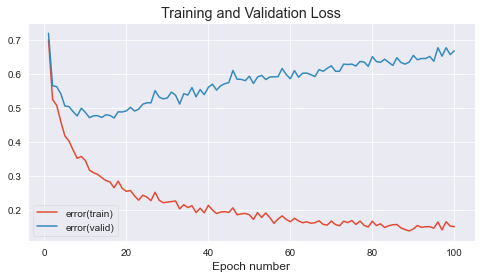

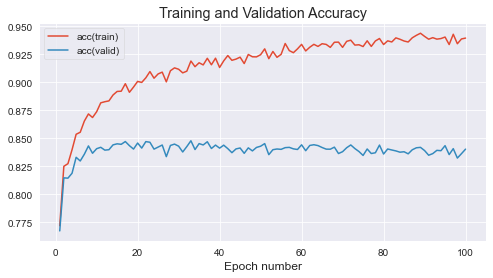

In [34]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Definition of the Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-4)), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L2Penalty(1e-4))
])

# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_L2_1e_4, keys_L2_1e_4, runtime_L2_1e_4, activation_L2_1e_4 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_L2_1e_4, keys_L2_1e_4, runtime_L2_1e_4, activation_L2_1e_4, 'L2_1e_4')

### Model 2
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

L2 regularisation penalty of  **0.01** in all layers

Epoch 1: 4.9s to complete
    error(train)=1.01e+00, acc(train)=7.01e-01, error(valid)=1.02e+00, acc(valid)=6.98e-01


Epoch 2: 5.0s to complete
    error(train)=9.00e-01, acc(train)=7.35e-01, error(valid)=9.04e-01, acc(valid)=7.30e-01


Epoch 3: 5.0s to complete
    error(train)=8.87e-01, acc(train)=7.37e-01, error(valid)=8.94e-01, acc(valid)=7.37e-01


Epoch 4: 5.0s to complete
    error(train)=8.45e-01, acc(train)=7.42e-01, error(valid)=8.55e-01, acc(valid)=7.34e-01


Epoch 5: 5.2s to complete
    error(train)=8.42e-01, acc(train)=7.46e-01, error(valid)=8.52e-01, acc(valid)=7.41e-01


Epoch 6: 5.2s to complete
    error(train)=8.25e-01, acc(train)=7.52e-01, error(valid)=8.33e-01, acc(valid)=7.52e-01


Epoch 7: 5.4s to complete
    error(train)=7.95e-01, acc(train)=7.61e-01, error(valid)=8.05e-01, acc(valid)=7.57e-01


Epoch 8: 5.4s to complete
    error(train)=8.13e-01, acc(train)=7.49e-01, error(valid)=8.18e-01, acc(valid)=7.49e-01


Epoch 9: 5.2s to complete
    error(train)=8.33e-01, acc(train)=7.51e-01, error(valid)=8.40e-01, acc(valid)=7.47e-01


Epoch 10: 5.5s to complete
    error(train)=7.86e-01, acc(train)=7.70e-01, error(valid)=7.99e-01, acc(valid)=7.66e-01


Epoch 11: 5.2s to complete
    error(train)=7.98e-01, acc(train)=7.59e-01, error(valid)=8.06e-01, acc(valid)=7.55e-01


Epoch 12: 5.0s to complete
    error(train)=8.02e-01, acc(train)=7.55e-01, error(valid)=8.13e-01, acc(valid)=7.50e-01


Epoch 13: 5.1s to complete
    error(train)=8.23e-01, acc(train)=7.52e-01, error(valid)=8.30e-01, acc(valid)=7.46e-01


Epoch 14: 5.7s to complete
    error(train)=7.94e-01, acc(train)=7.64e-01, error(valid)=8.05e-01, acc(valid)=7.60e-01


Epoch 15: 7.0s to complete
    error(train)=7.78e-01, acc(train)=7.70e-01, error(valid)=7.87e-01, acc(valid)=7.66e-01


Epoch 16: 6.6s to complete
    error(train)=7.95e-01, acc(train)=7.57e-01, error(valid)=8.08e-01, acc(valid)=7.52e-01


Epoch 17: 5.3s to complete
    error(train)=7.81e-01, acc(train)=7.62e-01, error(valid)=7.93e-01, acc(valid)=7.58e-01


Epoch 18: 5.7s to complete
    error(train)=7.82e-01, acc(train)=7.68e-01, error(valid)=7.98e-01, acc(valid)=7.61e-01


Epoch 19: 5.6s to complete
    error(train)=7.91e-01, acc(train)=7.62e-01, error(valid)=8.00e-01, acc(valid)=7.60e-01


Epoch 20: 6.4s to complete
    error(train)=8.06e-01, acc(train)=7.58e-01, error(valid)=8.17e-01, acc(valid)=7.55e-01


Epoch 21: 6.2s to complete
    error(train)=7.74e-01, acc(train)=7.68e-01, error(valid)=7.85e-01, acc(valid)=7.65e-01


Epoch 22: 6.9s to complete
    error(train)=7.93e-01, acc(train)=7.60e-01, error(valid)=8.03e-01, acc(valid)=7.59e-01


Epoch 23: 6.6s to complete
    error(train)=7.83e-01, acc(train)=7.66e-01, error(valid)=7.98e-01, acc(valid)=7.62e-01


Epoch 24: 6.7s to complete
    error(train)=7.92e-01, acc(train)=7.63e-01, error(valid)=8.04e-01, acc(valid)=7.58e-01


Epoch 25: 7.1s to complete
    error(train)=7.61e-01, acc(train)=7.71e-01, error(valid)=7.74e-01, acc(valid)=7.70e-01


Epoch 26: 6.7s to complete
    error(train)=8.06e-01, acc(train)=7.56e-01, error(valid)=8.21e-01, acc(valid)=7.51e-01


Epoch 27: 7.2s to complete
    error(train)=8.06e-01, acc(train)=7.61e-01, error(valid)=8.20e-01, acc(valid)=7.54e-01


Epoch 28: 7.0s to complete
    error(train)=8.13e-01, acc(train)=7.57e-01, error(valid)=8.28e-01, acc(valid)=7.50e-01


Epoch 29: 7.1s to complete
    error(train)=7.57e-01, acc(train)=7.70e-01, error(valid)=7.69e-01, acc(valid)=7.66e-01


Epoch 30: 6.6s to complete
    error(train)=7.98e-01, acc(train)=7.57e-01, error(valid)=8.13e-01, acc(valid)=7.51e-01


Epoch 31: 7.5s to complete
    error(train)=7.66e-01, acc(train)=7.68e-01, error(valid)=7.79e-01, acc(valid)=7.64e-01


Epoch 32: 6.5s to complete
    error(train)=7.72e-01, acc(train)=7.69e-01, error(valid)=7.84e-01, acc(valid)=7.62e-01


Epoch 33: 6.5s to complete
    error(train)=7.62e-01, acc(train)=7.75e-01, error(valid)=7.74e-01, acc(valid)=7.70e-01


Epoch 34: 7.1s to complete
    error(train)=7.64e-01, acc(train)=7.71e-01, error(valid)=7.81e-01, acc(valid)=7.65e-01


Epoch 35: 7.1s to complete
    error(train)=7.78e-01, acc(train)=7.67e-01, error(valid)=7.93e-01, acc(valid)=7.60e-01


Epoch 36: 6.7s to complete
    error(train)=7.89e-01, acc(train)=7.60e-01, error(valid)=8.03e-01, acc(valid)=7.54e-01


Epoch 37: 6.7s to complete
    error(train)=7.68e-01, acc(train)=7.70e-01, error(valid)=7.80e-01, acc(valid)=7.66e-01


Epoch 38: 7.4s to complete
    error(train)=7.76e-01, acc(train)=7.66e-01, error(valid)=7.90e-01, acc(valid)=7.60e-01


Epoch 39: 7.0s to complete
    error(train)=7.81e-01, acc(train)=7.63e-01, error(valid)=7.95e-01, acc(valid)=7.58e-01


Epoch 40: 7.2s to complete
    error(train)=7.86e-01, acc(train)=7.62e-01, error(valid)=8.01e-01, acc(valid)=7.57e-01


Epoch 41: 7.0s to complete
    error(train)=7.86e-01, acc(train)=7.63e-01, error(valid)=8.02e-01, acc(valid)=7.57e-01


Epoch 42: 6.4s to complete
    error(train)=7.89e-01, acc(train)=7.59e-01, error(valid)=8.04e-01, acc(valid)=7.53e-01


Epoch 43: 6.3s to complete
    error(train)=7.58e-01, acc(train)=7.74e-01, error(valid)=7.71e-01, acc(valid)=7.68e-01


Epoch 44: 6.4s to complete
    error(train)=7.60e-01, acc(train)=7.72e-01, error(valid)=7.74e-01, acc(valid)=7.67e-01


Epoch 45: 6.1s to complete
    error(train)=7.67e-01, acc(train)=7.71e-01, error(valid)=7.80e-01, acc(valid)=7.65e-01


Epoch 46: 6.6s to complete
    error(train)=7.97e-01, acc(train)=7.62e-01, error(valid)=8.07e-01, acc(valid)=7.57e-01


Epoch 47: 6.7s to complete
    error(train)=7.67e-01, acc(train)=7.73e-01, error(valid)=7.80e-01, acc(valid)=7.68e-01


Epoch 48: 6.9s to complete
    error(train)=8.08e-01, acc(train)=7.53e-01, error(valid)=8.22e-01, acc(valid)=7.47e-01


Epoch 49: 6.5s to complete
    error(train)=7.66e-01, acc(train)=7.69e-01, error(valid)=7.79e-01, acc(valid)=7.64e-01


Epoch 50: 6.4s to complete
    error(train)=7.56e-01, acc(train)=7.73e-01, error(valid)=7.68e-01, acc(valid)=7.71e-01


Epoch 51: 6.3s to complete
    error(train)=7.71e-01, acc(train)=7.68e-01, error(valid)=7.81e-01, acc(valid)=7.63e-01


Epoch 52: 6.1s to complete
    error(train)=7.58e-01, acc(train)=7.73e-01, error(valid)=7.73e-01, acc(valid)=7.70e-01


Epoch 53: 6.3s to complete
    error(train)=7.92e-01, acc(train)=7.64e-01, error(valid)=8.05e-01, acc(valid)=7.58e-01


Epoch 54: 6.3s to complete
    error(train)=7.70e-01, acc(train)=7.69e-01, error(valid)=7.84e-01, acc(valid)=7.64e-01


Epoch 55: 6.4s to complete
    error(train)=7.71e-01, acc(train)=7.70e-01, error(valid)=7.84e-01, acc(valid)=7.63e-01


Epoch 56: 6.1s to complete
    error(train)=7.80e-01, acc(train)=7.65e-01, error(valid)=7.96e-01, acc(valid)=7.61e-01


Epoch 57: 6.0s to complete
    error(train)=7.74e-01, acc(train)=7.68e-01, error(valid)=7.89e-01, acc(valid)=7.66e-01


Epoch 58: 6.0s to complete
    error(train)=7.70e-01, acc(train)=7.65e-01, error(valid)=7.85e-01, acc(valid)=7.59e-01


Epoch 59: 6.0s to complete
    error(train)=7.60e-01, acc(train)=7.75e-01, error(valid)=7.75e-01, acc(valid)=7.69e-01


Epoch 60: 6.4s to complete
    error(train)=7.87e-01, acc(train)=7.64e-01, error(valid)=8.07e-01, acc(valid)=7.54e-01


Epoch 61: 6.4s to complete
    error(train)=7.70e-01, acc(train)=7.69e-01, error(valid)=7.85e-01, acc(valid)=7.63e-01


Epoch 62: 6.2s to complete
    error(train)=7.69e-01, acc(train)=7.70e-01, error(valid)=7.82e-01, acc(valid)=7.67e-01


Epoch 63: 6.3s to complete
    error(train)=7.56e-01, acc(train)=7.77e-01, error(valid)=7.69e-01, acc(valid)=7.75e-01


Epoch 64: 5.9s to complete
    error(train)=7.79e-01, acc(train)=7.70e-01, error(valid)=7.97e-01, acc(valid)=7.61e-01


Epoch 65: 5.5s to complete
    error(train)=7.84e-01, acc(train)=7.65e-01, error(valid)=7.97e-01, acc(valid)=7.61e-01


Epoch 66: 5.8s to complete
    error(train)=7.57e-01, acc(train)=7.73e-01, error(valid)=7.72e-01, acc(valid)=7.66e-01


Epoch 67: 6.2s to complete
    error(train)=7.69e-01, acc(train)=7.71e-01, error(valid)=7.85e-01, acc(valid)=7.65e-01


Epoch 68: 6.6s to complete
    error(train)=7.53e-01, acc(train)=7.74e-01, error(valid)=7.64e-01, acc(valid)=7.69e-01


Epoch 69: 6.1s to complete
    error(train)=7.77e-01, acc(train)=7.64e-01, error(valid)=7.91e-01, acc(valid)=7.58e-01


Epoch 70: 6.6s to complete
    error(train)=7.72e-01, acc(train)=7.68e-01, error(valid)=7.87e-01, acc(valid)=7.60e-01


Epoch 71: 6.5s to complete
    error(train)=7.73e-01, acc(train)=7.67e-01, error(valid)=7.88e-01, acc(valid)=7.63e-01


Epoch 72: 6.6s to complete
    error(train)=7.93e-01, acc(train)=7.64e-01, error(valid)=8.07e-01, acc(valid)=7.60e-01


Epoch 73: 6.7s to complete
    error(train)=7.64e-01, acc(train)=7.72e-01, error(valid)=7.76e-01, acc(valid)=7.67e-01


Epoch 74: 5.7s to complete
    error(train)=7.86e-01, acc(train)=7.67e-01, error(valid)=8.00e-01, acc(valid)=7.61e-01


Epoch 75: 5.6s to complete
    error(train)=7.62e-01, acc(train)=7.71e-01, error(valid)=7.77e-01, acc(valid)=7.66e-01


Epoch 76: 5.6s to complete
    error(train)=7.56e-01, acc(train)=7.73e-01, error(valid)=7.69e-01, acc(valid)=7.67e-01


Epoch 77: 6.3s to complete
    error(train)=7.58e-01, acc(train)=7.72e-01, error(valid)=7.73e-01, acc(valid)=7.67e-01


Epoch 78: 5.7s to complete
    error(train)=7.64e-01, acc(train)=7.72e-01, error(valid)=7.78e-01, acc(valid)=7.65e-01


Epoch 79: 5.5s to complete
    error(train)=7.74e-01, acc(train)=7.68e-01, error(valid)=7.88e-01, acc(valid)=7.61e-01


Epoch 80: 5.8s to complete
    error(train)=7.69e-01, acc(train)=7.71e-01, error(valid)=7.82e-01, acc(valid)=7.64e-01


Epoch 81: 5.6s to complete
    error(train)=7.73e-01, acc(train)=7.67e-01, error(valid)=7.88e-01, acc(valid)=7.60e-01


Epoch 82: 5.5s to complete
    error(train)=7.76e-01, acc(train)=7.69e-01, error(valid)=7.90e-01, acc(valid)=7.63e-01


Epoch 83: 5.6s to complete
    error(train)=7.64e-01, acc(train)=7.72e-01, error(valid)=7.80e-01, acc(valid)=7.67e-01


Epoch 84: 5.5s to complete
    error(train)=7.68e-01, acc(train)=7.69e-01, error(valid)=7.79e-01, acc(valid)=7.65e-01


Epoch 85: 6.1s to complete
    error(train)=7.93e-01, acc(train)=7.59e-01, error(valid)=8.02e-01, acc(valid)=7.57e-01


Epoch 86: 6.1s to complete
    error(train)=7.82e-01, acc(train)=7.66e-01, error(valid)=7.94e-01, acc(valid)=7.63e-01


Epoch 87: 5.6s to complete
    error(train)=7.85e-01, acc(train)=7.63e-01, error(valid)=8.09e-01, acc(valid)=7.56e-01


Epoch 88: 5.6s to complete
    error(train)=7.89e-01, acc(train)=7.64e-01, error(valid)=8.02e-01, acc(valid)=7.60e-01


Epoch 89: 5.4s to complete
    error(train)=7.62e-01, acc(train)=7.72e-01, error(valid)=7.77e-01, acc(valid)=7.67e-01


Epoch 90: 5.5s to complete
    error(train)=7.69e-01, acc(train)=7.71e-01, error(valid)=7.79e-01, acc(valid)=7.70e-01


Epoch 91: 6.1s to complete
    error(train)=7.64e-01, acc(train)=7.73e-01, error(valid)=7.79e-01, acc(valid)=7.65e-01


Epoch 92: 6.0s to complete
    error(train)=7.62e-01, acc(train)=7.68e-01, error(valid)=7.77e-01, acc(valid)=7.63e-01


Epoch 93: 6.2s to complete
    error(train)=7.51e-01, acc(train)=7.74e-01, error(valid)=7.65e-01, acc(valid)=7.67e-01


Epoch 94: 6.0s to complete
    error(train)=7.62e-01, acc(train)=7.74e-01, error(valid)=7.75e-01, acc(valid)=7.68e-01


Epoch 95: 5.7s to complete
    error(train)=7.74e-01, acc(train)=7.65e-01, error(valid)=7.90e-01, acc(valid)=7.61e-01


Epoch 96: 6.1s to complete
    error(train)=7.57e-01, acc(train)=7.73e-01, error(valid)=7.72e-01, acc(valid)=7.64e-01


Epoch 97: 5.8s to complete
    error(train)=7.65e-01, acc(train)=7.73e-01, error(valid)=7.81e-01, acc(valid)=7.69e-01


Epoch 98: 5.5s to complete
    error(train)=7.87e-01, acc(train)=7.64e-01, error(valid)=8.05e-01, acc(valid)=7.57e-01


Epoch 99: 5.6s to complete
    error(train)=7.78e-01, acc(train)=7.66e-01, error(valid)=7.92e-01, acc(valid)=7.61e-01


Epoch 100: 5.8s to complete
    error(train)=7.75e-01, acc(train)=7.67e-01, error(valid)=7.90e-01, acc(valid)=7.63e-01


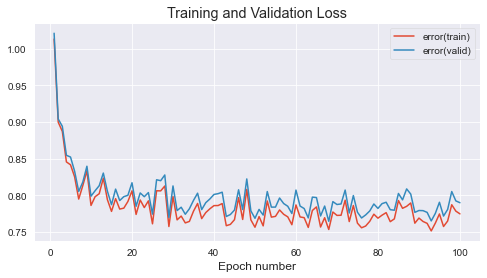

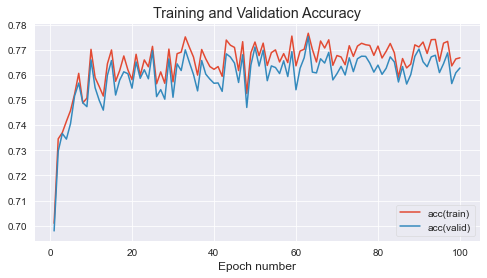

In [35]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Definition of the Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-2)), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L2Penalty(1e-2))
])

# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_L2_1e_2, keys_L2_1e_2, runtime_L2_1e_2, activation_L2_1e_2 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_L2_1e_2, keys_L2_1e_2, runtime_L2_1e_2, activation_L2_1e_2, 'L2_1e_2')

### Model 3
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

L2 regularisation penalty in  **increasing fashion** of 0.0001, 0.01, 0.1

Epoch 1: 4.9s to complete
    error(train)=8.95e-01, acc(train)=7.32e-01, error(valid)=9.11e-01, acc(valid)=7.27e-01


Epoch 2: 5.0s to complete
    error(train)=7.82e-01, acc(train)=7.55e-01, error(valid)=8.01e-01, acc(valid)=7.51e-01


Epoch 3: 5.0s to complete
    error(train)=7.38e-01, acc(train)=7.71e-01, error(valid)=7.61e-01, acc(valid)=7.67e-01


Epoch 4: 5.1s to complete
    error(train)=6.70e-01, acc(train)=7.84e-01, error(valid)=6.98e-01, acc(valid)=7.76e-01


Epoch 5: 5.1s to complete
    error(train)=6.47e-01, acc(train)=7.92e-01, error(valid)=6.74e-01, acc(valid)=7.84e-01


Epoch 6: 5.2s to complete
    error(train)=6.57e-01, acc(train)=7.89e-01, error(valid)=6.86e-01, acc(valid)=7.79e-01


Epoch 7: 5.4s to complete
    error(train)=6.26e-01, acc(train)=7.95e-01, error(valid)=6.60e-01, acc(valid)=7.83e-01


Epoch 8: 5.3s to complete
    error(train)=6.06e-01, acc(train)=8.02e-01, error(valid)=6.41e-01, acc(valid)=7.91e-01


Epoch 9: 5.3s to complete
    error(train)=5.72e-01, acc(train)=8.09e-01, error(valid)=6.12e-01, acc(valid)=7.98e-01


Epoch 10: 5.1s to complete
    error(train)=5.73e-01, acc(train)=8.14e-01, error(valid)=6.09e-01, acc(valid)=8.05e-01


Epoch 11: 5.1s to complete
    error(train)=5.50e-01, acc(train)=8.22e-01, error(valid)=5.91e-01, acc(valid)=8.12e-01


Epoch 12: 5.1s to complete
    error(train)=5.87e-01, acc(train)=8.02e-01, error(valid)=6.29e-01, acc(valid)=7.92e-01


Epoch 13: 5.2s to complete
    error(train)=5.32e-01, acc(train)=8.26e-01, error(valid)=5.72e-01, acc(valid)=8.14e-01


Epoch 14: 8.2s to complete
    error(train)=5.43e-01, acc(train)=8.22e-01, error(valid)=5.91e-01, acc(valid)=8.08e-01


Epoch 15: 9.3s to complete
    error(train)=5.22e-01, acc(train)=8.31e-01, error(valid)=5.71e-01, acc(valid)=8.17e-01


Epoch 16: 9.1s to complete
    error(train)=5.39e-01, acc(train)=8.25e-01, error(valid)=5.90e-01, acc(valid)=8.10e-01


Epoch 17: 9.3s to complete
    error(train)=5.06e-01, acc(train)=8.35e-01, error(valid)=5.60e-01, acc(valid)=8.18e-01


Epoch 18: 9.7s to complete
    error(train)=5.04e-01, acc(train)=8.36e-01, error(valid)=5.52e-01, acc(valid)=8.21e-01


Epoch 19: 10.5s to complete
    error(train)=5.33e-01, acc(train)=8.22e-01, error(valid)=5.83e-01, acc(valid)=8.09e-01


Epoch 20: 10.3s to complete
    error(train)=5.08e-01, acc(train)=8.32e-01, error(valid)=5.56e-01, acc(valid)=8.15e-01


Epoch 21: 10.3s to complete
    error(train)=4.96e-01, acc(train)=8.39e-01, error(valid)=5.53e-01, acc(valid)=8.22e-01


Epoch 22: 10.1s to complete
    error(train)=4.89e-01, acc(train)=8.40e-01, error(valid)=5.44e-01, acc(valid)=8.23e-01


Epoch 23: 10.3s to complete
    error(train)=4.90e-01, acc(train)=8.41e-01, error(valid)=5.47e-01, acc(valid)=8.22e-01


Epoch 24: 10.5s to complete
    error(train)=4.95e-01, acc(train)=8.36e-01, error(valid)=5.52e-01, acc(valid)=8.20e-01


Epoch 25: 10.6s to complete
    error(train)=4.92e-01, acc(train)=8.37e-01, error(valid)=5.50e-01, acc(valid)=8.19e-01


Epoch 26: 10.5s to complete
    error(train)=4.99e-01, acc(train)=8.37e-01, error(valid)=5.59e-01, acc(valid)=8.19e-01


Epoch 27: 10.4s to complete
    error(train)=5.07e-01, acc(train)=8.30e-01, error(valid)=5.61e-01, acc(valid)=8.13e-01


Epoch 28: 10.8s to complete
    error(train)=4.95e-01, acc(train)=8.35e-01, error(valid)=5.55e-01, acc(valid)=8.15e-01


Epoch 29: 10.6s to complete
    error(train)=4.86e-01, acc(train)=8.35e-01, error(valid)=5.47e-01, acc(valid)=8.14e-01


Epoch 30: 10.5s to complete
    error(train)=4.90e-01, acc(train)=8.37e-01, error(valid)=5.55e-01, acc(valid)=8.15e-01


Epoch 31: 10.9s to complete
    error(train)=4.85e-01, acc(train)=8.40e-01, error(valid)=5.48e-01, acc(valid)=8.22e-01


Epoch 32: 10.6s to complete
    error(train)=4.69e-01, acc(train)=8.48e-01, error(valid)=5.30e-01, acc(valid)=8.28e-01


Epoch 33: 10.3s to complete
    error(train)=4.84e-01, acc(train)=8.41e-01, error(valid)=5.46e-01, acc(valid)=8.20e-01


Epoch 34: 10.2s to complete
    error(train)=4.64e-01, acc(train)=8.48e-01, error(valid)=5.31e-01, acc(valid)=8.27e-01


Epoch 35: 10.3s to complete
    error(train)=4.64e-01, acc(train)=8.44e-01, error(valid)=5.30e-01, acc(valid)=8.22e-01


Epoch 36: 10.4s to complete
    error(train)=4.60e-01, acc(train)=8.49e-01, error(valid)=5.27e-01, acc(valid)=8.27e-01


Epoch 37: 10.5s to complete
    error(train)=4.79e-01, acc(train)=8.40e-01, error(valid)=5.43e-01, acc(valid)=8.21e-01


Epoch 38: 10.6s to complete
    error(train)=4.65e-01, acc(train)=8.48e-01, error(valid)=5.31e-01, acc(valid)=8.26e-01


Epoch 39: 10.7s to complete
    error(train)=4.63e-01, acc(train)=8.46e-01, error(valid)=5.30e-01, acc(valid)=8.23e-01


Epoch 40: 10.8s to complete
    error(train)=4.68e-01, acc(train)=8.45e-01, error(valid)=5.31e-01, acc(valid)=8.22e-01


Epoch 41: 10.3s to complete
    error(train)=4.77e-01, acc(train)=8.43e-01, error(valid)=5.46e-01, acc(valid)=8.23e-01


Epoch 42: 10.3s to complete
    error(train)=4.75e-01, acc(train)=8.42e-01, error(valid)=5.43e-01, acc(valid)=8.21e-01


Epoch 43: 10.7s to complete
    error(train)=4.45e-01, acc(train)=8.53e-01, error(valid)=5.13e-01, acc(valid)=8.32e-01


Epoch 44: 10.6s to complete
    error(train)=4.40e-01, acc(train)=8.56e-01, error(valid)=5.07e-01, acc(valid)=8.34e-01


Epoch 45: 10.7s to complete
    error(train)=4.57e-01, acc(train)=8.51e-01, error(valid)=5.24e-01, acc(valid)=8.28e-01


Epoch 46: 10.8s to complete
    error(train)=4.41e-01, acc(train)=8.55e-01, error(valid)=5.10e-01, acc(valid)=8.30e-01


Epoch 47: 10.8s to complete
    error(train)=4.59e-01, acc(train)=8.48e-01, error(valid)=5.28e-01, acc(valid)=8.25e-01


Epoch 48: 11.6s to complete
    error(train)=4.42e-01, acc(train)=8.51e-01, error(valid)=5.12e-01, acc(valid)=8.25e-01


Epoch 49: 11.2s to complete
    error(train)=4.49e-01, acc(train)=8.53e-01, error(valid)=5.20e-01, acc(valid)=8.30e-01


Epoch 50: 10.7s to complete
    error(train)=4.51e-01, acc(train)=8.49e-01, error(valid)=5.20e-01, acc(valid)=8.27e-01


Epoch 51: 10.6s to complete
    error(train)=4.55e-01, acc(train)=8.48e-01, error(valid)=5.30e-01, acc(valid)=8.24e-01


Epoch 52: 10.4s to complete
    error(train)=4.62e-01, acc(train)=8.46e-01, error(valid)=5.32e-01, acc(valid)=8.25e-01


Epoch 53: 10.7s to complete
    error(train)=4.47e-01, acc(train)=8.51e-01, error(valid)=5.20e-01, acc(valid)=8.25e-01


Epoch 54: 10.3s to complete
    error(train)=4.60e-01, acc(train)=8.46e-01, error(valid)=5.31e-01, acc(valid)=8.20e-01


Epoch 55: 10.1s to complete
    error(train)=4.45e-01, acc(train)=8.54e-01, error(valid)=5.14e-01, acc(valid)=8.29e-01


Epoch 56: 10.2s to complete
    error(train)=4.50e-01, acc(train)=8.51e-01, error(valid)=5.23e-01, acc(valid)=8.26e-01


Epoch 57: 10.2s to complete
    error(train)=4.43e-01, acc(train)=8.52e-01, error(valid)=5.15e-01, acc(valid)=8.31e-01


Epoch 58: 10.3s to complete
    error(train)=4.30e-01, acc(train)=8.61e-01, error(valid)=4.99e-01, acc(valid)=8.38e-01


Epoch 59: 10.4s to complete
    error(train)=4.37e-01, acc(train)=8.57e-01, error(valid)=5.05e-01, acc(valid)=8.33e-01


Epoch 60: 10.3s to complete
    error(train)=4.39e-01, acc(train)=8.55e-01, error(valid)=5.12e-01, acc(valid)=8.31e-01


Epoch 61: 10.6s to complete
    error(train)=4.40e-01, acc(train)=8.55e-01, error(valid)=5.12e-01, acc(valid)=8.32e-01


Epoch 62: 10.6s to complete
    error(train)=4.43e-01, acc(train)=8.51e-01, error(valid)=5.18e-01, acc(valid)=8.27e-01


Epoch 63: 10.3s to complete
    error(train)=4.52e-01, acc(train)=8.48e-01, error(valid)=5.26e-01, acc(valid)=8.23e-01


Epoch 64: 10.2s to complete
    error(train)=4.41e-01, acc(train)=8.55e-01, error(valid)=5.11e-01, acc(valid)=8.32e-01


Epoch 65: 10.0s to complete
    error(train)=4.45e-01, acc(train)=8.51e-01, error(valid)=5.19e-01, acc(valid)=8.26e-01


Epoch 66: 10.0s to complete
    error(train)=4.36e-01, acc(train)=8.54e-01, error(valid)=5.10e-01, acc(valid)=8.28e-01


Epoch 67: 11.4s to complete
    error(train)=4.29e-01, acc(train)=8.58e-01, error(valid)=5.03e-01, acc(valid)=8.35e-01


Epoch 68: 11.2s to complete
    error(train)=4.47e-01, acc(train)=8.53e-01, error(valid)=5.21e-01, acc(valid)=8.30e-01


Epoch 69: 10.2s to complete
    error(train)=4.32e-01, acc(train)=8.56e-01, error(valid)=5.08e-01, acc(valid)=8.32e-01


Epoch 70: 10.2s to complete
    error(train)=4.22e-01, acc(train)=8.59e-01, error(valid)=4.92e-01, acc(valid)=8.34e-01


Epoch 71: 10.2s to complete
    error(train)=4.34e-01, acc(train)=8.54e-01, error(valid)=5.11e-01, acc(valid)=8.29e-01


Epoch 72: 10.0s to complete
    error(train)=4.25e-01, acc(train)=8.56e-01, error(valid)=5.01e-01, acc(valid)=8.29e-01


Epoch 73: 9.9s to complete
    error(train)=4.47e-01, acc(train)=8.47e-01, error(valid)=5.24e-01, acc(valid)=8.21e-01


Epoch 74: 10.0s to complete
    error(train)=4.24e-01, acc(train)=8.61e-01, error(valid)=4.99e-01, acc(valid)=8.34e-01


Epoch 75: 10.2s to complete
    error(train)=4.47e-01, acc(train)=8.52e-01, error(valid)=5.23e-01, acc(valid)=8.26e-01


Epoch 76: 10.6s to complete
    error(train)=4.23e-01, acc(train)=8.59e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


Epoch 77: 10.2s to complete
    error(train)=4.42e-01, acc(train)=8.54e-01, error(valid)=5.23e-01, acc(valid)=8.27e-01


Epoch 78: 10.4s to complete
    error(train)=4.32e-01, acc(train)=8.57e-01, error(valid)=5.07e-01, acc(valid)=8.32e-01


Epoch 79: 10.5s to complete
    error(train)=4.22e-01, acc(train)=8.62e-01, error(valid)=4.96e-01, acc(valid)=8.37e-01


Epoch 80: 10.4s to complete
    error(train)=4.32e-01, acc(train)=8.58e-01, error(valid)=5.07e-01, acc(valid)=8.34e-01


Epoch 81: 10.3s to complete
    error(train)=4.61e-01, acc(train)=8.43e-01, error(valid)=5.40e-01, acc(valid)=8.17e-01


Epoch 82: 10.4s to complete
    error(train)=4.21e-01, acc(train)=8.61e-01, error(valid)=4.98e-01, acc(valid)=8.38e-01


Epoch 83: 10.2s to complete
    error(train)=4.32e-01, acc(train)=8.57e-01, error(valid)=5.11e-01, acc(valid)=8.32e-01


Epoch 84: 10.2s to complete
    error(train)=4.38e-01, acc(train)=8.56e-01, error(valid)=5.16e-01, acc(valid)=8.29e-01


Epoch 85: 10.7s to complete
    error(train)=4.27e-01, acc(train)=8.58e-01, error(valid)=5.04e-01, acc(valid)=8.32e-01


Epoch 86: 10.3s to complete
    error(train)=4.25e-01, acc(train)=8.59e-01, error(valid)=5.02e-01, acc(valid)=8.33e-01


Epoch 87: 10.5s to complete
    error(train)=4.17e-01, acc(train)=8.63e-01, error(valid)=4.94e-01, acc(valid)=8.37e-01


Epoch 88: 10.3s to complete
    error(train)=4.26e-01, acc(train)=8.61e-01, error(valid)=4.99e-01, acc(valid)=8.39e-01


Epoch 89: 10.4s to complete
    error(train)=4.23e-01, acc(train)=8.57e-01, error(valid)=4.98e-01, acc(valid)=8.32e-01


Epoch 90: 10.5s to complete
    error(train)=4.22e-01, acc(train)=8.59e-01, error(valid)=5.00e-01, acc(valid)=8.34e-01


Epoch 91: 10.3s to complete
    error(train)=4.38e-01, acc(train)=8.55e-01, error(valid)=5.22e-01, acc(valid)=8.30e-01


Epoch 92: 10.6s to complete
    error(train)=4.34e-01, acc(train)=8.57e-01, error(valid)=5.13e-01, acc(valid)=8.31e-01


Epoch 93: 10.3s to complete
    error(train)=4.19e-01, acc(train)=8.57e-01, error(valid)=4.97e-01, acc(valid)=8.32e-01


Epoch 94: 10.3s to complete
    error(train)=4.27e-01, acc(train)=8.58e-01, error(valid)=5.04e-01, acc(valid)=8.33e-01


Epoch 95: 10.2s to complete
    error(train)=4.41e-01, acc(train)=8.52e-01, error(valid)=5.24e-01, acc(valid)=8.27e-01


Epoch 96: 10.5s to complete
    error(train)=4.29e-01, acc(train)=8.58e-01, error(valid)=5.08e-01, acc(valid)=8.33e-01


Epoch 97: 10.4s to complete
    error(train)=4.23e-01, acc(train)=8.60e-01, error(valid)=5.03e-01, acc(valid)=8.33e-01


Epoch 98: 10.4s to complete
    error(train)=4.26e-01, acc(train)=8.57e-01, error(valid)=5.04e-01, acc(valid)=8.29e-01


Epoch 99: 10.4s to complete
    error(train)=4.27e-01, acc(train)=8.59e-01, error(valid)=5.10e-01, acc(valid)=8.32e-01


Epoch 100: 10.3s to complete
    error(train)=4.41e-01, acc(train)=8.53e-01, error(valid)=5.20e-01, acc(valid)=8.28e-01


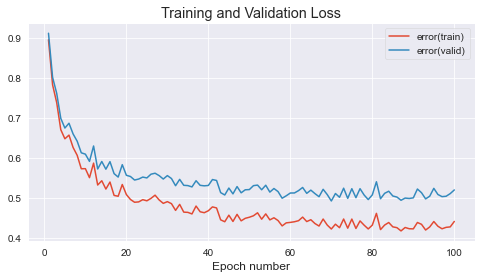

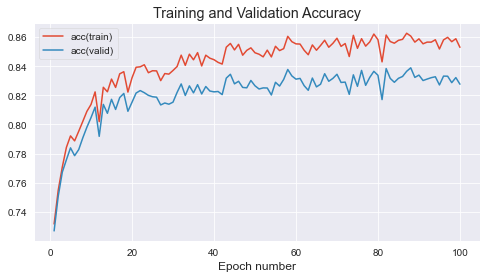

In [36]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Definition of the Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-4)), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L2Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L2Penalty(0.1))
])

# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_L2_incf, keys_L2_incf, runtime_L2_incf, activation_L2_incf = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_L2_incf, keys_L2_incf, runtime_L2_incf, activation_L2_incf, 'L2_incf')

## Study of the effect of L1 Regularization

### Model 1
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

L2 regularisation penalty of  **0.0001** in all layers

Epoch 1: 6.6s to complete
    error(train)=7.36e-01, acc(train)=7.65e-01, error(valid)=7.50e-01, acc(valid)=7.57e-01


Epoch 2: 6.6s to complete
    error(train)=6.16e-01, acc(train)=7.96e-01, error(valid)=6.33e-01, acc(valid)=7.88e-01


Epoch 3: 6.7s to complete
    error(train)=5.54e-01, acc(train)=8.17e-01, error(valid)=5.81e-01, acc(valid)=8.08e-01


Epoch 4: 7.2s to complete
    error(train)=5.27e-01, acc(train)=8.24e-01, error(valid)=5.64e-01, acc(valid)=8.14e-01


Epoch 5: 7.2s to complete
    error(train)=5.14e-01, acc(train)=8.25e-01, error(valid)=5.50e-01, acc(valid)=8.12e-01


Epoch 6: 6.5s to complete
    error(train)=4.98e-01, acc(train)=8.31e-01, error(valid)=5.42e-01, acc(valid)=8.16e-01


Epoch 7: 6.6s to complete
    error(train)=4.53e-01, acc(train)=8.42e-01, error(valid)=5.00e-01, acc(valid)=8.26e-01


Epoch 8: 6.5s to complete
    error(train)=4.43e-01, acc(train)=8.47e-01, error(valid)=4.87e-01, acc(valid)=8.33e-01


Epoch 9: 6.4s to complete
    error(train)=4.41e-01, acc(train)=8.47e-01, error(valid)=4.89e-01, acc(valid)=8.31e-01


Epoch 10: 7.0s to complete
    error(train)=4.43e-01, acc(train)=8.48e-01, error(valid)=4.85e-01, acc(valid)=8.35e-01


Epoch 11: 6.4s to complete
    error(train)=4.27e-01, acc(train)=8.52e-01, error(valid)=4.73e-01, acc(valid)=8.37e-01


Epoch 12: 6.6s to complete
    error(train)=4.23e-01, acc(train)=8.51e-01, error(valid)=4.72e-01, acc(valid)=8.34e-01


Epoch 13: 6.6s to complete
    error(train)=4.16e-01, acc(train)=8.55e-01, error(valid)=4.67e-01, acc(valid)=8.39e-01


Epoch 14: 6.5s to complete
    error(train)=4.26e-01, acc(train)=8.52e-01, error(valid)=4.82e-01, acc(valid)=8.34e-01


Epoch 15: 6.5s to complete
    error(train)=4.22e-01, acc(train)=8.52e-01, error(valid)=4.75e-01, acc(valid)=8.36e-01


Epoch 16: 6.5s to complete
    error(train)=4.02e-01, acc(train)=8.58e-01, error(valid)=4.51e-01, acc(valid)=8.46e-01


Epoch 17: 6.3s to complete
    error(train)=3.99e-01, acc(train)=8.57e-01, error(valid)=4.52e-01, acc(valid)=8.42e-01


Epoch 18: 6.7s to complete
    error(train)=3.97e-01, acc(train)=8.61e-01, error(valid)=4.56e-01, acc(valid)=8.45e-01


Epoch 19: 6.3s to complete
    error(train)=4.03e-01, acc(train)=8.54e-01, error(valid)=4.60e-01, acc(valid)=8.36e-01


Epoch 20: 6.3s to complete
    error(train)=4.02e-01, acc(train)=8.59e-01, error(valid)=4.56e-01, acc(valid)=8.43e-01


Epoch 21: 6.5s to complete
    error(train)=3.88e-01, acc(train)=8.63e-01, error(valid)=4.44e-01, acc(valid)=8.48e-01


Epoch 22: 6.6s to complete
    error(train)=3.96e-01, acc(train)=8.59e-01, error(valid)=4.59e-01, acc(valid)=8.44e-01


Epoch 23: 6.6s to complete
    error(train)=3.80e-01, acc(train)=8.66e-01, error(valid)=4.40e-01, acc(valid)=8.48e-01


Epoch 24: 6.4s to complete
    error(train)=3.86e-01, acc(train)=8.62e-01, error(valid)=4.52e-01, acc(valid)=8.44e-01


Epoch 25: 7.0s to complete
    error(train)=3.81e-01, acc(train)=8.63e-01, error(valid)=4.50e-01, acc(valid)=8.46e-01


Epoch 26: 7.4s to complete
    error(train)=3.99e-01, acc(train)=8.58e-01, error(valid)=4.63e-01, acc(valid)=8.41e-01


Epoch 27: 7.3s to complete
    error(train)=3.84e-01, acc(train)=8.62e-01, error(valid)=4.45e-01, acc(valid)=8.47e-01


Epoch 28: 6.6s to complete
    error(train)=3.80e-01, acc(train)=8.64e-01, error(valid)=4.45e-01, acc(valid)=8.47e-01


Epoch 29: 6.5s to complete
    error(train)=3.70e-01, acc(train)=8.68e-01, error(valid)=4.32e-01, acc(valid)=8.51e-01


Epoch 30: 6.9s to complete
    error(train)=3.71e-01, acc(train)=8.67e-01, error(valid)=4.42e-01, acc(valid)=8.48e-01


Epoch 31: 6.6s to complete
    error(train)=3.71e-01, acc(train)=8.66e-01, error(valid)=4.40e-01, acc(valid)=8.47e-01


Epoch 32: 6.4s to complete
    error(train)=3.59e-01, acc(train)=8.72e-01, error(valid)=4.30e-01, acc(valid)=8.52e-01


Epoch 33: 7.2s to complete
    error(train)=3.73e-01, acc(train)=8.65e-01, error(valid)=4.45e-01, acc(valid)=8.47e-01


Epoch 34: 6.8s to complete
    error(train)=3.84e-01, acc(train)=8.63e-01, error(valid)=4.52e-01, acc(valid)=8.45e-01


Epoch 35: 7.2s to complete
    error(train)=3.62e-01, acc(train)=8.69e-01, error(valid)=4.30e-01, acc(valid)=8.48e-01


Epoch 36: 7.0s to complete
    error(train)=3.62e-01, acc(train)=8.69e-01, error(valid)=4.35e-01, acc(valid)=8.47e-01


Epoch 37: 6.5s to complete
    error(train)=3.58e-01, acc(train)=8.72e-01, error(valid)=4.29e-01, acc(valid)=8.51e-01


Epoch 38: 6.5s to complete
    error(train)=3.65e-01, acc(train)=8.69e-01, error(valid)=4.39e-01, acc(valid)=8.50e-01


Epoch 39: 7.1s to complete
    error(train)=3.70e-01, acc(train)=8.67e-01, error(valid)=4.47e-01, acc(valid)=8.46e-01


Epoch 40: 6.3s to complete
    error(train)=3.69e-01, acc(train)=8.67e-01, error(valid)=4.41e-01, acc(valid)=8.49e-01


Epoch 41: 6.3s to complete
    error(train)=3.87e-01, acc(train)=8.63e-01, error(valid)=4.66e-01, acc(valid)=8.44e-01


Epoch 42: 7.3s to complete
    error(train)=3.55e-01, acc(train)=8.70e-01, error(valid)=4.31e-01, acc(valid)=8.50e-01


Epoch 43: 6.6s to complete
    error(train)=3.54e-01, acc(train)=8.70e-01, error(valid)=4.33e-01, acc(valid)=8.46e-01


Epoch 44: 6.7s to complete
    error(train)=3.56e-01, acc(train)=8.71e-01, error(valid)=4.37e-01, acc(valid)=8.49e-01


Epoch 45: 7.0s to complete
    error(train)=3.61e-01, acc(train)=8.70e-01, error(valid)=4.34e-01, acc(valid)=8.50e-01


Epoch 46: 6.5s to complete
    error(train)=3.51e-01, acc(train)=8.74e-01, error(valid)=4.33e-01, acc(valid)=8.51e-01


Epoch 47: 6.6s to complete
    error(train)=3.54e-01, acc(train)=8.72e-01, error(valid)=4.39e-01, acc(valid)=8.52e-01


Epoch 48: 6.6s to complete
    error(train)=3.46e-01, acc(train)=8.74e-01, error(valid)=4.26e-01, acc(valid)=8.50e-01


Epoch 49: 6.6s to complete
    error(train)=3.51e-01, acc(train)=8.72e-01, error(valid)=4.31e-01, acc(valid)=8.52e-01


Epoch 50: 6.5s to complete
    error(train)=3.54e-01, acc(train)=8.71e-01, error(valid)=4.35e-01, acc(valid)=8.52e-01


Epoch 51: 6.4s to complete
    error(train)=3.58e-01, acc(train)=8.68e-01, error(valid)=4.38e-01, acc(valid)=8.45e-01


Epoch 52: 6.4s to complete
    error(train)=3.43e-01, acc(train)=8.76e-01, error(valid)=4.24e-01, acc(valid)=8.53e-01


Epoch 53: 6.6s to complete
    error(train)=3.62e-01, acc(train)=8.70e-01, error(valid)=4.46e-01, acc(valid)=8.48e-01


Epoch 54: 6.3s to complete
    error(train)=3.56e-01, acc(train)=8.71e-01, error(valid)=4.47e-01, acc(valid)=8.48e-01


Epoch 55: 6.3s to complete
    error(train)=3.69e-01, acc(train)=8.68e-01, error(valid)=4.52e-01, acc(valid)=8.46e-01


Epoch 56: 6.3s to complete
    error(train)=3.51e-01, acc(train)=8.73e-01, error(valid)=4.37e-01, acc(valid)=8.50e-01


Epoch 57: 6.3s to complete
    error(train)=3.42e-01, acc(train)=8.77e-01, error(valid)=4.26e-01, acc(valid)=8.52e-01


Epoch 58: 6.3s to complete
    error(train)=3.43e-01, acc(train)=8.77e-01, error(valid)=4.33e-01, acc(valid)=8.50e-01


Epoch 59: 6.8s to complete
    error(train)=3.69e-01, acc(train)=8.67e-01, error(valid)=4.52e-01, acc(valid)=8.46e-01


Epoch 60: 6.7s to complete
    error(train)=3.47e-01, acc(train)=8.75e-01, error(valid)=4.38e-01, acc(valid)=8.50e-01


Epoch 61: 6.3s to complete
    error(train)=3.41e-01, acc(train)=8.77e-01, error(valid)=4.27e-01, acc(valid)=8.54e-01


Epoch 62: 6.4s to complete
    error(train)=3.78e-01, acc(train)=8.60e-01, error(valid)=4.64e-01, acc(valid)=8.40e-01


Epoch 63: 6.3s to complete
    error(train)=3.42e-01, acc(train)=8.75e-01, error(valid)=4.31e-01, acc(valid)=8.53e-01


Epoch 64: 6.5s to complete
    error(train)=3.46e-01, acc(train)=8.76e-01, error(valid)=4.33e-01, acc(valid)=8.53e-01


Epoch 65: 6.4s to complete
    error(train)=3.55e-01, acc(train)=8.73e-01, error(valid)=4.40e-01, acc(valid)=8.50e-01


Epoch 66: 7.3s to complete
    error(train)=3.44e-01, acc(train)=8.72e-01, error(valid)=4.36e-01, acc(valid)=8.47e-01


Epoch 67: 7.0s to complete
    error(train)=3.47e-01, acc(train)=8.72e-01, error(valid)=4.40e-01, acc(valid)=8.46e-01


Epoch 68: 6.6s to complete
    error(train)=3.40e-01, acc(train)=8.76e-01, error(valid)=4.35e-01, acc(valid)=8.50e-01


Epoch 69: 6.3s to complete
    error(train)=3.42e-01, acc(train)=8.76e-01, error(valid)=4.38e-01, acc(valid)=8.51e-01


Epoch 70: 6.4s to complete
    error(train)=3.51e-01, acc(train)=8.73e-01, error(valid)=4.46e-01, acc(valid)=8.48e-01


Epoch 71: 7.3s to complete
    error(train)=3.49e-01, acc(train)=8.72e-01, error(valid)=4.42e-01, acc(valid)=8.49e-01


Epoch 72: 7.0s to complete
    error(train)=3.58e-01, acc(train)=8.70e-01, error(valid)=4.50e-01, acc(valid)=8.47e-01


Epoch 73: 7.0s to complete
    error(train)=3.46e-01, acc(train)=8.74e-01, error(valid)=4.37e-01, acc(valid)=8.49e-01


Epoch 74: 6.7s to complete
    error(train)=3.33e-01, acc(train)=8.79e-01, error(valid)=4.24e-01, acc(valid)=8.55e-01


Epoch 75: 6.5s to complete
    error(train)=3.43e-01, acc(train)=8.74e-01, error(valid)=4.39e-01, acc(valid)=8.50e-01


Epoch 76: 6.8s to complete
    error(train)=3.50e-01, acc(train)=8.72e-01, error(valid)=4.39e-01, acc(valid)=8.48e-01


Epoch 77: 6.3s to complete
    error(train)=3.42e-01, acc(train)=8.74e-01, error(valid)=4.34e-01, acc(valid)=8.49e-01


Epoch 78: 7.1s to complete
    error(train)=3.33e-01, acc(train)=8.79e-01, error(valid)=4.30e-01, acc(valid)=8.53e-01


Epoch 79: 6.5s to complete
    error(train)=3.52e-01, acc(train)=8.71e-01, error(valid)=4.49e-01, acc(valid)=8.46e-01


Epoch 80: 6.6s to complete
    error(train)=3.33e-01, acc(train)=8.78e-01, error(valid)=4.28e-01, acc(valid)=8.55e-01


Epoch 81: 6.4s to complete
    error(train)=3.44e-01, acc(train)=8.77e-01, error(valid)=4.42e-01, acc(valid)=8.50e-01


Epoch 82: 6.5s to complete
    error(train)=3.42e-01, acc(train)=8.73e-01, error(valid)=4.37e-01, acc(valid)=8.48e-01


Epoch 83: 6.7s to complete
    error(train)=3.55e-01, acc(train)=8.71e-01, error(valid)=4.56e-01, acc(valid)=8.43e-01


Epoch 84: 6.7s to complete
    error(train)=3.30e-01, acc(train)=8.77e-01, error(valid)=4.30e-01, acc(valid)=8.51e-01


Epoch 85: 6.6s to complete
    error(train)=3.46e-01, acc(train)=8.74e-01, error(valid)=4.40e-01, acc(valid)=8.49e-01


Epoch 86: 7.1s to complete
    error(train)=3.32e-01, acc(train)=8.79e-01, error(valid)=4.29e-01, acc(valid)=8.54e-01


Epoch 87: 6.8s to complete
    error(train)=3.33e-01, acc(train)=8.79e-01, error(valid)=4.33e-01, acc(valid)=8.51e-01


Epoch 88: 6.4s to complete
    error(train)=3.45e-01, acc(train)=8.74e-01, error(valid)=4.44e-01, acc(valid)=8.49e-01


Epoch 89: 6.4s to complete
    error(train)=3.31e-01, acc(train)=8.77e-01, error(valid)=4.37e-01, acc(valid)=8.48e-01


Epoch 90: 6.3s to complete
    error(train)=3.42e-01, acc(train)=8.74e-01, error(valid)=4.45e-01, acc(valid)=8.48e-01


Epoch 91: 6.6s to complete
    error(train)=3.49e-01, acc(train)=8.74e-01, error(valid)=4.49e-01, acc(valid)=8.46e-01


Epoch 92: 6.4s to complete
    error(train)=3.33e-01, acc(train)=8.79e-01, error(valid)=4.34e-01, acc(valid)=8.54e-01


Epoch 93: 6.4s to complete
    error(train)=3.47e-01, acc(train)=8.73e-01, error(valid)=4.47e-01, acc(valid)=8.47e-01


Epoch 94: 6.4s to complete
    error(train)=3.58e-01, acc(train)=8.70e-01, error(valid)=4.63e-01, acc(valid)=8.44e-01


Epoch 95: 6.4s to complete
    error(train)=3.26e-01, acc(train)=8.80e-01, error(valid)=4.26e-01, acc(valid)=8.53e-01


Epoch 96: 6.6s to complete
    error(train)=3.30e-01, acc(train)=8.78e-01, error(valid)=4.33e-01, acc(valid)=8.52e-01


Epoch 97: 6.3s to complete
    error(train)=3.29e-01, acc(train)=8.79e-01, error(valid)=4.27e-01, acc(valid)=8.54e-01


Epoch 98: 7.1s to complete
    error(train)=3.37e-01, acc(train)=8.78e-01, error(valid)=4.45e-01, acc(valid)=8.52e-01


Epoch 99: 6.7s to complete
    error(train)=3.41e-01, acc(train)=8.76e-01, error(valid)=4.43e-01, acc(valid)=8.50e-01


Epoch 100: 6.5s to complete
    error(train)=3.26e-01, acc(train)=8.80e-01, error(valid)=4.33e-01, acc(valid)=8.52e-01


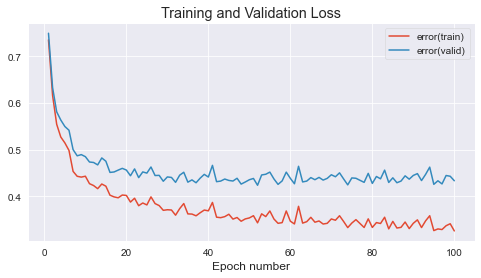

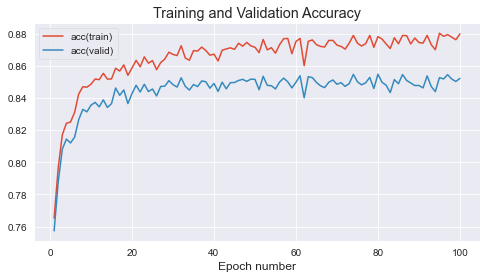

In [38]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Definition of the Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L1Penalty(1e-4))
])

# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_L1_1e_4, keys_L1_1e_4, runtime_L1_1e_4, activation_L1_1e_4 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_L1_1e_4, keys_L1_1e_4, runtime_L1_1e_4, activation_L1_1e_4, 'L1_1e_4')

### Model 2
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

L2 regularisation penalty of  **0.01** in all layers

Epoch 1: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 2: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 3: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 4: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 5: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 6: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 7: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 8: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 9: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 10: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 11: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 12: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 13: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 14: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 15: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 16: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 17: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 18: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 19: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 20: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 21: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 22: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 23: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 24: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 25: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 26: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 27: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 28: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 29: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 30: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 31: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 32: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 33: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 34: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 35: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 36: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 37: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 38: 6.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 39: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 40: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 41: 7.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 42: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 43: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 44: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 45: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 46: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=1.89e-02


Epoch 47: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 48: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 49: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 50: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.09e-02


Epoch 51: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 52: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 53: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 54: 6.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 55: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 56: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 57: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 58: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 59: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 60: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 61: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=1.88e-02


Epoch 62: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 63: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 64: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 65: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 66: 6.7s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=1.99e-02


Epoch 67: 6.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 68: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 69: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 70: 7.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 71: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 72: 6.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 73: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 74: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 75: 6.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 76: 6.8s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 77: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 78: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 79: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 80: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 81: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 82: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 83: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 84: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 85: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 86: 6.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 87: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 88: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 89: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 90: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 91: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 92: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 93: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.19e-02


Epoch 94: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 95: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=1.99e-02


Epoch 96: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 97: 6.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 98: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 99: 6.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 100: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


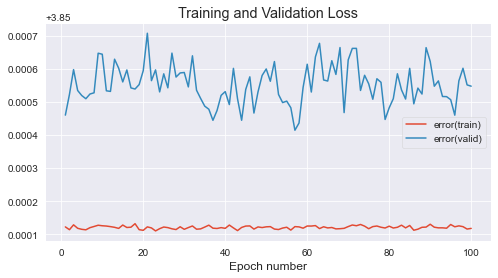

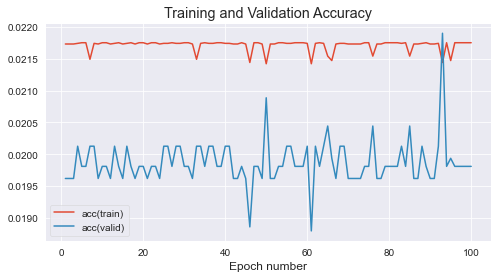

In [39]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Definition of the Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L1Penalty(1e-2))
])

# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_L1_1e_2, keys_L1_1e_2, runtime_L1_1e_2, activation_L1_1e_2 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_L1_1e_2, keys_L1_1e_2, runtime_L1_1e_2, activation_L1_1e_2, 'L1_1e_2')

### Model 3
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

L2 regularisation penalty in  **increasing fashion** of 0.0001, 0.01, 0.1

Epoch 1: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 2: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 3: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 4: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 5: 6.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 6: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 7: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 8: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 9: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 10: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 11: 6.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 12: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 13: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.19e-02


Epoch 14: 6.8s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 15: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 16: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 17: 7.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 18: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 19: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 20: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 21: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 22: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 23: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 24: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 25: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 26: 6.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 27: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.11e-02


Epoch 28: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 29: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 30: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 31: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.07e-02


Epoch 32: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.18e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 33: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=1.89e-02


Epoch 34: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 35: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 36: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 37: 6.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 38: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 39: 6.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 40: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 41: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 42: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 43: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.03e-02


Epoch 44: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 45: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 46: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 47: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 48: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 49: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.13e-02, error(valid)=3.85e+00, acc(valid)=2.16e-02


Epoch 50: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=1.88e-02


Epoch 51: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 52: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.11e-02


Epoch 53: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 54: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 55: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 56: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 57: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 58: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=1.99e-02


Epoch 59: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 60: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 61: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 62: 6.8s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.11e-02


Epoch 63: 6.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 64: 6.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 65: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 66: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 67: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 68: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 69: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 70: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 71: 6.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 72: 6.7s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 73: 6.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 74: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 75: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 76: 6.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 77: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 78: 6.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 79: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 80: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 81: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 82: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 83: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 84: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 85: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 86: 5.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 87: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 88: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 89: 6.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 90: 6.2s to complete
    error(train)=3.85e+00, acc(train)=2.13e-02, error(valid)=3.85e+00, acc(valid)=2.02e-02


Epoch 91: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 92: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 93: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.07e-02


Epoch 94: 6.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 95: 6.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 96: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 97: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 98: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 99: 6.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 100: 6.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


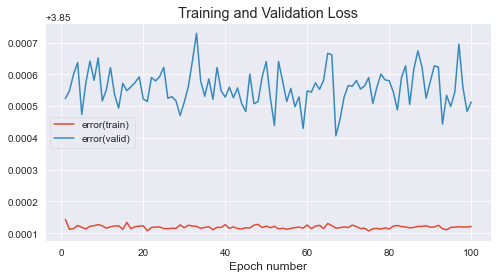

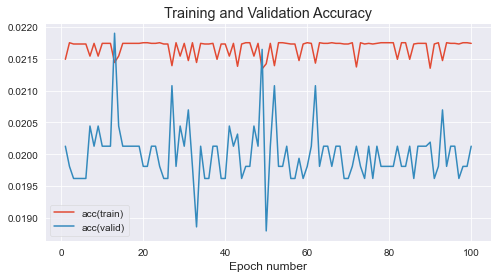

In [40]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Definition of the Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L1Penalty(0.1))
])

# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_L1_incf, keys_L1_incf, runtime_L1_incf, activation_L1_incf = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_L1_incf, keys_L1_incf, runtime_L1_incf, activation_L1_incf, 'L1_incf')

## Study of the effect of Dropout + L1 Regularization

### Model 1
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

Dropout of **0.2** and L2 regularisation penalty of **0.001**

Epoch 1: 9.3s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.19e-02


Epoch 2: 9.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 3: 7.9s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.03e-02


Epoch 4: 7.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 5: 7.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 6: 7.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 7: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 8: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 9: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 10: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 11: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 12: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 13: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 14: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 15: 9.0s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=1.88e-02


Epoch 16: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 17: 8.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 18: 7.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 19: 8.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 20: 7.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 21: 8.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 22: 8.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 23: 8.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 24: 9.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 25: 8.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 26: 9.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 27: 8.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 28: 7.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 29: 9.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 30: 8.5s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 31: 9.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 32: 7.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 33: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 34: 8.0s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 35: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 36: 8.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 37: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 38: 7.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 39: 9.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 40: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 41: 8.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 42: 9.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 43: 7.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 44: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 45: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 46: 8.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 47: 7.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 48: 8.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 49: 7.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 50: 7.9s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 51: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 52: 8.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 53: 7.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 54: 7.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 55: 9.3s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=1.89e-02


Epoch 56: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 57: 8.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 58: 8.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 59: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 60: 8.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 61: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 62: 8.3s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 63: 7.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 64: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 65: 8.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 66: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 67: 7.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 68: 7.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 69: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 70: 7.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 71: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.03e-02


Epoch 72: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 73: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 74: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 75: 7.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 76: 7.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 77: 8.2s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 78: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 79: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 80: 7.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 81: 8.3s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 82: 8.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 83: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 84: 8.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 85: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 86: 7.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 87: 8.1s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.19e-02


Epoch 88: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 89: 8.7s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 90: 8.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 91: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 92: 7.6s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 93: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 94: 9.1s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.96e-02


Epoch 95: 8.0s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 96: 7.5s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=1.98e-02


Epoch 97: 8.4s to complete
    error(train)=3.85e+00, acc(train)=2.15e-02, error(valid)=3.85e+00, acc(valid)=2.04e-02


Epoch 98: 7.8s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


Epoch 99: 8.8s to complete
    error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.23e-02


Epoch 100: 8.4s to complete
    error(train)=3.85e+00, acc(train)=2.17e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02


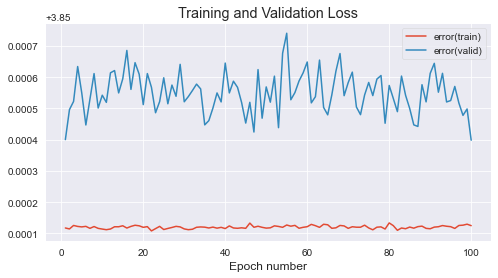

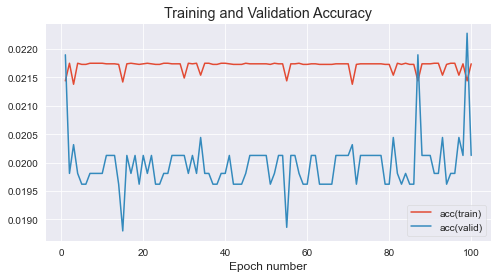

In [53]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialization of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Dropout random state
rng = np.random.RandomState(92019)

# Definition of Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.8),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.8),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.8),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-2)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L1Penalty(1e-2))
])

# Definition of error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_d02_L2_1e3, keys_d02_L2_1e3, runtime_d02_L2_1e3, activation_d02_L2_1e3 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_d02_L2_1e3, keys_d02_L2_1e3, runtime_d02_L2_1e3, activation_d02_L2_1e3, 'd08_L1_1e2')

### Model 2
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

Dropout of **0.5** and L2 regularisation penalty of **0.01**

Epoch 1: 7.7s to complete
    error(train)=2.50e+00, acc(train)=2.62e-01, error(valid)=2.49e+00, acc(valid)=2.63e-01


Epoch 2: 9.7s to complete
    error(train)=2.23e+00, acc(train)=3.25e-01, error(valid)=2.22e+00, acc(valid)=3.24e-01


Epoch 3: 7.9s to complete
    error(train)=1.98e+00, acc(train)=3.95e-01, error(valid)=1.98e+00, acc(valid)=3.96e-01


Epoch 4: 8.1s to complete
    error(train)=1.85e+00, acc(train)=4.32e-01, error(valid)=1.85e+00, acc(valid)=4.30e-01


Epoch 5: 8.3s to complete
    error(train)=1.81e+00, acc(train)=4.41e-01, error(valid)=1.82e+00, acc(valid)=4.39e-01


Epoch 6: 8.1s to complete
    error(train)=1.72e+00, acc(train)=4.71e-01, error(valid)=1.74e+00, acc(valid)=4.66e-01


Epoch 7: 9.1s to complete
    error(train)=1.69e+00, acc(train)=4.85e-01, error(valid)=1.69e+00, acc(valid)=4.85e-01


Epoch 8: 9.6s to complete
    error(train)=1.65e+00, acc(train)=4.97e-01, error(valid)=1.66e+00, acc(valid)=4.96e-01


Epoch 9: 8.4s to complete
    error(train)=1.61e+00, acc(train)=5.03e-01, error(valid)=1.63e+00, acc(valid)=4.99e-01


Epoch 10: 8.6s to complete
    error(train)=1.60e+00, acc(train)=5.11e-01, error(valid)=1.58e+00, acc(valid)=5.14e-01


Epoch 11: 8.5s to complete
    error(train)=1.60e+00, acc(train)=5.11e-01, error(valid)=1.61e+00, acc(valid)=5.08e-01


Epoch 12: 8.4s to complete
    error(train)=1.56e+00, acc(train)=5.28e-01, error(valid)=1.54e+00, acc(valid)=5.23e-01


Epoch 13: 7.9s to complete
    error(train)=1.50e+00, acc(train)=5.42e-01, error(valid)=1.54e+00, acc(valid)=5.35e-01


Epoch 14: 9.0s to complete
    error(train)=1.50e+00, acc(train)=5.43e-01, error(valid)=1.50e+00, acc(valid)=5.45e-01


Epoch 15: 7.7s to complete
    error(train)=1.48e+00, acc(train)=5.47e-01, error(valid)=1.51e+00, acc(valid)=5.40e-01


Epoch 16: 9.2s to complete
    error(train)=1.49e+00, acc(train)=5.48e-01, error(valid)=1.51e+00, acc(valid)=5.40e-01


Epoch 17: 7.7s to complete
    error(train)=1.44e+00, acc(train)=5.61e-01, error(valid)=1.46e+00, acc(valid)=5.48e-01


Epoch 18: 9.4s to complete
    error(train)=1.49e+00, acc(train)=5.47e-01, error(valid)=1.50e+00, acc(valid)=5.39e-01


Epoch 19: 7.8s to complete
    error(train)=1.42e+00, acc(train)=5.67e-01, error(valid)=1.44e+00, acc(valid)=5.58e-01


Epoch 20: 7.9s to complete
    error(train)=1.42e+00, acc(train)=5.69e-01, error(valid)=1.46e+00, acc(valid)=5.57e-01


Epoch 21: 9.3s to complete
    error(train)=1.41e+00, acc(train)=5.68e-01, error(valid)=1.43e+00, acc(valid)=5.66e-01


Epoch 22: 7.7s to complete
    error(train)=1.39e+00, acc(train)=5.74e-01, error(valid)=1.41e+00, acc(valid)=5.71e-01


Epoch 23: 7.8s to complete
    error(train)=1.38e+00, acc(train)=5.78e-01, error(valid)=1.39e+00, acc(valid)=5.70e-01


Epoch 24: 7.8s to complete
    error(train)=1.37e+00, acc(train)=5.79e-01, error(valid)=1.39e+00, acc(valid)=5.80e-01


Epoch 25: 7.8s to complete
    error(train)=1.39e+00, acc(train)=5.71e-01, error(valid)=1.42e+00, acc(valid)=5.72e-01


Epoch 26: 9.2s to complete
    error(train)=1.39e+00, acc(train)=5.77e-01, error(valid)=1.46e+00, acc(valid)=5.62e-01


Epoch 27: 9.1s to complete
    error(train)=1.39e+00, acc(train)=5.77e-01, error(valid)=1.42e+00, acc(valid)=5.65e-01


Epoch 28: 7.8s to complete
    error(train)=1.38e+00, acc(train)=5.79e-01, error(valid)=1.39e+00, acc(valid)=5.80e-01


Epoch 29: 7.9s to complete
    error(train)=1.36e+00, acc(train)=5.82e-01, error(valid)=1.39e+00, acc(valid)=5.76e-01


Epoch 30: 7.8s to complete
    error(train)=1.35e+00, acc(train)=5.85e-01, error(valid)=1.40e+00, acc(valid)=5.72e-01


Epoch 31: 8.8s to complete
    error(train)=1.37e+00, acc(train)=5.79e-01, error(valid)=1.37e+00, acc(valid)=5.80e-01


Epoch 32: 7.8s to complete
    error(train)=1.35e+00, acc(train)=5.87e-01, error(valid)=1.38e+00, acc(valid)=5.83e-01


Epoch 33: 8.1s to complete
    error(train)=1.33e+00, acc(train)=5.92e-01, error(valid)=1.36e+00, acc(valid)=5.87e-01


Epoch 34: 8.0s to complete
    error(train)=1.34e+00, acc(train)=5.90e-01, error(valid)=1.38e+00, acc(valid)=5.77e-01


Epoch 35: 7.8s to complete
    error(train)=1.31e+00, acc(train)=6.00e-01, error(valid)=1.33e+00, acc(valid)=5.94e-01


Epoch 36: 7.9s to complete
    error(train)=1.32e+00, acc(train)=5.96e-01, error(valid)=1.33e+00, acc(valid)=5.95e-01


Epoch 37: 8.6s to complete
    error(train)=1.31e+00, acc(train)=5.99e-01, error(valid)=1.35e+00, acc(valid)=5.84e-01


Epoch 38: 8.3s to complete
    error(train)=1.33e+00, acc(train)=5.92e-01, error(valid)=1.34e+00, acc(valid)=5.89e-01


Epoch 39: 7.8s to complete
    error(train)=1.30e+00, acc(train)=6.03e-01, error(valid)=1.32e+00, acc(valid)=5.96e-01


Epoch 40: 7.7s to complete
    error(train)=1.31e+00, acc(train)=5.97e-01, error(valid)=1.35e+00, acc(valid)=5.84e-01


Epoch 41: 7.8s to complete
    error(train)=1.31e+00, acc(train)=5.97e-01, error(valid)=1.33e+00, acc(valid)=5.93e-01


Epoch 42: 8.2s to complete
    error(train)=1.28e+00, acc(train)=6.07e-01, error(valid)=1.32e+00, acc(valid)=5.99e-01


Epoch 43: 8.2s to complete
    error(train)=1.27e+00, acc(train)=6.10e-01, error(valid)=1.32e+00, acc(valid)=5.98e-01


Epoch 44: 9.5s to complete
    error(train)=1.30e+00, acc(train)=6.00e-01, error(valid)=1.34e+00, acc(valid)=5.88e-01


Epoch 45: 8.1s to complete
    error(train)=1.28e+00, acc(train)=6.04e-01, error(valid)=1.27e+00, acc(valid)=6.12e-01


Epoch 46: 8.0s to complete
    error(train)=1.30e+00, acc(train)=6.02e-01, error(valid)=1.31e+00, acc(valid)=5.95e-01


Epoch 47: 7.9s to complete
    error(train)=1.27e+00, acc(train)=6.11e-01, error(valid)=1.31e+00, acc(valid)=5.97e-01


Epoch 48: 7.9s to complete
    error(train)=1.25e+00, acc(train)=6.15e-01, error(valid)=1.24e+00, acc(valid)=6.18e-01


Epoch 49: 8.2s to complete
    error(train)=1.26e+00, acc(train)=6.12e-01, error(valid)=1.28e+00, acc(valid)=6.07e-01


Epoch 50: 7.9s to complete
    error(train)=1.29e+00, acc(train)=6.05e-01, error(valid)=1.33e+00, acc(valid)=5.89e-01


Epoch 51: 8.7s to complete
    error(train)=1.27e+00, acc(train)=6.12e-01, error(valid)=1.29e+00, acc(valid)=6.04e-01


Epoch 52: 7.9s to complete
    error(train)=1.25e+00, acc(train)=6.14e-01, error(valid)=1.26e+00, acc(valid)=6.12e-01


Epoch 53: 8.7s to complete
    error(train)=1.27e+00, acc(train)=6.11e-01, error(valid)=1.26e+00, acc(valid)=6.14e-01


Epoch 54: 9.1s to complete
    error(train)=1.29e+00, acc(train)=6.03e-01, error(valid)=1.29e+00, acc(valid)=5.99e-01


Epoch 55: 7.8s to complete
    error(train)=1.25e+00, acc(train)=6.17e-01, error(valid)=1.28e+00, acc(valid)=6.07e-01


Epoch 56: 7.7s to complete
    error(train)=1.27e+00, acc(train)=6.11e-01, error(valid)=1.29e+00, acc(valid)=6.09e-01


Epoch 57: 7.8s to complete
    error(train)=1.23e+00, acc(train)=6.22e-01, error(valid)=1.26e+00, acc(valid)=6.12e-01


Epoch 58: 8.6s to complete
    error(train)=1.23e+00, acc(train)=6.22e-01, error(valid)=1.24e+00, acc(valid)=6.19e-01


Epoch 59: 8.6s to complete
    error(train)=1.23e+00, acc(train)=6.21e-01, error(valid)=1.25e+00, acc(valid)=6.16e-01


Epoch 60: 8.1s to complete
    error(train)=1.25e+00, acc(train)=6.16e-01, error(valid)=1.27e+00, acc(valid)=6.12e-01


Epoch 61: 8.3s to complete
    error(train)=1.26e+00, acc(train)=6.15e-01, error(valid)=1.29e+00, acc(valid)=6.02e-01


Epoch 62: 7.7s to complete
    error(train)=1.21e+00, acc(train)=6.26e-01, error(valid)=1.26e+00, acc(valid)=6.10e-01


Epoch 63: 8.3s to complete
    error(train)=1.22e+00, acc(train)=6.26e-01, error(valid)=1.22e+00, acc(valid)=6.25e-01


Epoch 64: 7.8s to complete
    error(train)=1.24e+00, acc(train)=6.17e-01, error(valid)=1.28e+00, acc(valid)=6.10e-01


Epoch 65: 7.8s to complete
    error(train)=1.22e+00, acc(train)=6.25e-01, error(valid)=1.25e+00, acc(valid)=6.14e-01


Epoch 66: 8.4s to complete
    error(train)=1.25e+00, acc(train)=6.17e-01, error(valid)=1.29e+00, acc(valid)=6.08e-01


Epoch 67: 8.3s to complete
    error(train)=1.22e+00, acc(train)=6.25e-01, error(valid)=1.25e+00, acc(valid)=6.23e-01


Epoch 68: 9.7s to complete
    error(train)=1.24e+00, acc(train)=6.20e-01, error(valid)=1.26e+00, acc(valid)=6.17e-01


Epoch 69: 7.8s to complete
    error(train)=1.22e+00, acc(train)=6.23e-01, error(valid)=1.23e+00, acc(valid)=6.22e-01


Epoch 70: 7.8s to complete
    error(train)=1.24e+00, acc(train)=6.21e-01, error(valid)=1.28e+00, acc(valid)=6.06e-01


Epoch 71: 9.8s to complete
    error(train)=1.22e+00, acc(train)=6.25e-01, error(valid)=1.24e+00, acc(valid)=6.14e-01


Epoch 72: 8.0s to complete
    error(train)=1.22e+00, acc(train)=6.26e-01, error(valid)=1.25e+00, acc(valid)=6.18e-01


Epoch 73: 8.7s to complete
    error(train)=1.23e+00, acc(train)=6.19e-01, error(valid)=1.23e+00, acc(valid)=6.20e-01


Epoch 74: 8.0s to complete
    error(train)=1.24e+00, acc(train)=6.19e-01, error(valid)=1.27e+00, acc(valid)=6.06e-01


Epoch 75: 8.5s to complete
    error(train)=1.23e+00, acc(train)=6.24e-01, error(valid)=1.24e+00, acc(valid)=6.20e-01


Epoch 76: 8.7s to complete
    error(train)=1.24e+00, acc(train)=6.20e-01, error(valid)=1.27e+00, acc(valid)=6.09e-01


Epoch 77: 7.9s to complete
    error(train)=1.20e+00, acc(train)=6.30e-01, error(valid)=1.24e+00, acc(valid)=6.23e-01


Epoch 78: 8.3s to complete
    error(train)=1.21e+00, acc(train)=6.28e-01, error(valid)=1.23e+00, acc(valid)=6.21e-01


Epoch 79: 8.0s to complete
    error(train)=1.22e+00, acc(train)=6.25e-01, error(valid)=1.24e+00, acc(valid)=6.20e-01


Epoch 80: 8.3s to complete
    error(train)=1.22e+00, acc(train)=6.26e-01, error(valid)=1.24e+00, acc(valid)=6.18e-01


Epoch 81: 7.9s to complete
    error(train)=1.24e+00, acc(train)=6.19e-01, error(valid)=1.25e+00, acc(valid)=6.17e-01


Epoch 82: 8.1s to complete
    error(train)=1.22e+00, acc(train)=6.25e-01, error(valid)=1.24e+00, acc(valid)=6.19e-01


Epoch 83: 8.1s to complete
    error(train)=1.22e+00, acc(train)=6.26e-01, error(valid)=1.24e+00, acc(valid)=6.17e-01


Epoch 84: 9.3s to complete
    error(train)=1.25e+00, acc(train)=6.16e-01, error(valid)=1.25e+00, acc(valid)=6.13e-01


Epoch 85: 8.0s to complete
    error(train)=1.22e+00, acc(train)=6.24e-01, error(valid)=1.24e+00, acc(valid)=6.21e-01


Epoch 86: 7.9s to complete
    error(train)=1.23e+00, acc(train)=6.24e-01, error(valid)=1.25e+00, acc(valid)=6.17e-01


Epoch 87: 8.8s to complete
    error(train)=1.23e+00, acc(train)=6.26e-01, error(valid)=1.26e+00, acc(valid)=6.16e-01


Epoch 88: 7.9s to complete
    error(train)=1.22e+00, acc(train)=6.27e-01, error(valid)=1.22e+00, acc(valid)=6.27e-01


Epoch 89: 7.8s to complete
    error(train)=1.20e+00, acc(train)=6.32e-01, error(valid)=1.23e+00, acc(valid)=6.19e-01


Epoch 90: 8.4s to complete
    error(train)=1.22e+00, acc(train)=6.26e-01, error(valid)=1.25e+00, acc(valid)=6.13e-01


Epoch 91: 8.1s to complete
    error(train)=1.22e+00, acc(train)=6.24e-01, error(valid)=1.23e+00, acc(valid)=6.20e-01


Epoch 92: 8.7s to complete
    error(train)=1.22e+00, acc(train)=6.25e-01, error(valid)=1.26e+00, acc(valid)=6.18e-01


Epoch 93: 9.5s to complete
    error(train)=1.23e+00, acc(train)=6.21e-01, error(valid)=1.23e+00, acc(valid)=6.17e-01


Epoch 94: 8.8s to complete
    error(train)=1.21e+00, acc(train)=6.27e-01, error(valid)=1.26e+00, acc(valid)=6.12e-01


Epoch 95: 9.3s to complete
    error(train)=1.20e+00, acc(train)=6.31e-01, error(valid)=1.23e+00, acc(valid)=6.24e-01


Epoch 96: 8.9s to complete
    error(train)=1.21e+00, acc(train)=6.28e-01, error(valid)=1.23e+00, acc(valid)=6.25e-01


Epoch 97: 8.7s to complete
    error(train)=1.20e+00, acc(train)=6.29e-01, error(valid)=1.26e+00, acc(valid)=6.13e-01


Epoch 98: 8.4s to complete
    error(train)=1.20e+00, acc(train)=6.29e-01, error(valid)=1.23e+00, acc(valid)=6.22e-01


Epoch 99: 8.6s to complete
    error(train)=1.20e+00, acc(train)=6.32e-01, error(valid)=1.20e+00, acc(valid)=6.30e-01


Epoch 100: 7.9s to complete
    error(train)=1.21e+00, acc(train)=6.27e-01, error(valid)=1.23e+00, acc(valid)=6.21e-01


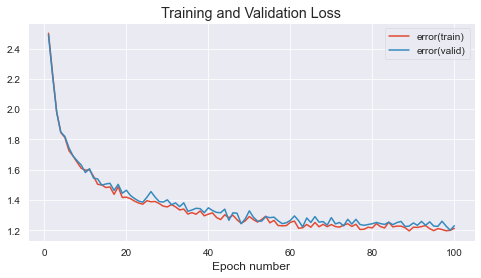

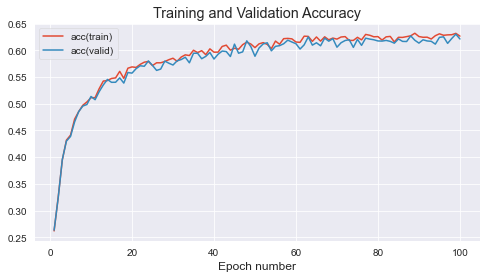

In [54]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialization of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Dropout random state
rng = np.random.RandomState(92019)

# Definition of Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.5),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.5),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.5),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L1Penalty(1e-4))
])

# Definition of error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_d05_L2_1e2, keys_d05_L2_1e2, runtime_d05_L2_1e2, activation_d05_L2_1e2 = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_d05_L2_1e2, keys_d05_L2_1e2, runtime_d05_L2_1e2, activation_d05_L2_1e2, 'd05_L1_1e4')

### Model 3
Number of ReLu hidden units: **128**

Number of Hidden layers:**3**

Dropout **in a decreasing fashion** and L2 regularisation **in an increasing fashion**

Epoch 1: 8.6s to complete
    error(train)=2.42e+00, acc(train)=2.98e-01, error(valid)=2.43e+00, acc(valid)=2.97e-01


Epoch 2: 7.8s to complete
    error(train)=2.11e+00, acc(train)=3.72e-01, error(valid)=2.11e+00, acc(valid)=3.68e-01


Epoch 3: 7.9s to complete
    error(train)=1.95e+00, acc(train)=4.02e-01, error(valid)=1.93e+00, acc(valid)=4.08e-01


Epoch 4: 7.9s to complete
    error(train)=1.81e+00, acc(train)=4.56e-01, error(valid)=1.80e+00, acc(valid)=4.49e-01


Epoch 5: 7.8s to complete
    error(train)=1.74e+00, acc(train)=4.67e-01, error(valid)=1.76e+00, acc(valid)=4.65e-01


Epoch 6: 7.8s to complete
    error(train)=1.60e+00, acc(train)=5.16e-01, error(valid)=1.63e+00, acc(valid)=5.10e-01


Epoch 7: 8.8s to complete
    error(train)=1.56e+00, acc(train)=5.23e-01, error(valid)=1.54e+00, acc(valid)=5.29e-01


Epoch 8: 9.4s to complete
    error(train)=1.49e+00, acc(train)=5.41e-01, error(valid)=1.50e+00, acc(valid)=5.36e-01


Epoch 9: 8.4s to complete
    error(train)=1.49e+00, acc(train)=5.48e-01, error(valid)=1.50e+00, acc(valid)=5.39e-01


Epoch 10: 9.5s to complete
    error(train)=1.42e+00, acc(train)=5.62e-01, error(valid)=1.45e+00, acc(valid)=5.60e-01


Epoch 11: 8.0s to complete
    error(train)=1.38e+00, acc(train)=5.77e-01, error(valid)=1.40e+00, acc(valid)=5.72e-01


Epoch 12: 8.6s to complete
    error(train)=1.35e+00, acc(train)=5.78e-01, error(valid)=1.37e+00, acc(valid)=5.72e-01


Epoch 13: 8.0s to complete
    error(train)=1.33e+00, acc(train)=5.97e-01, error(valid)=1.33e+00, acc(valid)=5.95e-01


Epoch 14: 9.3s to complete
    error(train)=1.30e+00, acc(train)=5.97e-01, error(valid)=1.32e+00, acc(valid)=5.88e-01


Epoch 15: 8.8s to complete
    error(train)=1.28e+00, acc(train)=6.06e-01, error(valid)=1.30e+00, acc(valid)=6.03e-01


Epoch 16: 9.8s to complete
    error(train)=1.24e+00, acc(train)=6.17e-01, error(valid)=1.25e+00, acc(valid)=6.09e-01


Epoch 17: 8.9s to complete
    error(train)=1.26e+00, acc(train)=6.02e-01, error(valid)=1.27e+00, acc(valid)=6.01e-01


Epoch 18: 8.1s to complete
    error(train)=1.22e+00, acc(train)=6.27e-01, error(valid)=1.22e+00, acc(valid)=6.28e-01


Epoch 19: 9.4s to complete
    error(train)=1.18e+00, acc(train)=6.37e-01, error(valid)=1.22e+00, acc(valid)=6.29e-01


Epoch 20: 9.7s to complete
    error(train)=1.22e+00, acc(train)=6.19e-01, error(valid)=1.22e+00, acc(valid)=6.18e-01


Epoch 21: 8.1s to complete
    error(train)=1.18e+00, acc(train)=6.35e-01, error(valid)=1.19e+00, acc(valid)=6.28e-01


Epoch 22: 9.5s to complete
    error(train)=1.11e+00, acc(train)=6.57e-01, error(valid)=1.15e+00, acc(valid)=6.42e-01


Epoch 23: 9.5s to complete
    error(train)=1.14e+00, acc(train)=6.52e-01, error(valid)=1.15e+00, acc(valid)=6.46e-01


Epoch 24: 9.4s to complete
    error(train)=1.12e+00, acc(train)=6.51e-01, error(valid)=1.13e+00, acc(valid)=6.42e-01


Epoch 25: 7.8s to complete
    error(train)=1.10e+00, acc(train)=6.57e-01, error(valid)=1.10e+00, acc(valid)=6.54e-01


Epoch 26: 9.7s to complete
    error(train)=1.07e+00, acc(train)=6.70e-01, error(valid)=1.10e+00, acc(valid)=6.63e-01


Epoch 27: 9.7s to complete
    error(train)=1.10e+00, acc(train)=6.56e-01, error(valid)=1.14e+00, acc(valid)=6.49e-01


Epoch 28: 8.0s to complete
    error(train)=1.09e+00, acc(train)=6.61e-01, error(valid)=1.12e+00, acc(valid)=6.50e-01


Epoch 29: 9.2s to complete
    error(train)=1.09e+00, acc(train)=6.61e-01, error(valid)=1.13e+00, acc(valid)=6.56e-01


Epoch 30: 9.2s to complete
    error(train)=1.08e+00, acc(train)=6.57e-01, error(valid)=1.10e+00, acc(valid)=6.56e-01


Epoch 31: 8.4s to complete
    error(train)=1.07e+00, acc(train)=6.66e-01, error(valid)=1.10e+00, acc(valid)=6.58e-01


Epoch 32: 8.0s to complete
    error(train)=1.06e+00, acc(train)=6.72e-01, error(valid)=1.09e+00, acc(valid)=6.59e-01


Epoch 33: 9.1s to complete
    error(train)=1.08e+00, acc(train)=6.55e-01, error(valid)=1.10e+00, acc(valid)=6.54e-01


Epoch 34: 9.4s to complete
    error(train)=1.06e+00, acc(train)=6.67e-01, error(valid)=1.09e+00, acc(valid)=6.56e-01


Epoch 35: 8.1s to complete
    error(train)=1.08e+00, acc(train)=6.62e-01, error(valid)=1.09e+00, acc(valid)=6.59e-01


Epoch 36: 9.3s to complete
    error(train)=1.05e+00, acc(train)=6.75e-01, error(valid)=1.07e+00, acc(valid)=6.69e-01


Epoch 37: 8.1s to complete
    error(train)=1.10e+00, acc(train)=6.56e-01, error(valid)=1.13e+00, acc(valid)=6.43e-01


Epoch 38: 9.6s to complete
    error(train)=1.08e+00, acc(train)=6.60e-01, error(valid)=1.10e+00, acc(valid)=6.51e-01


Epoch 39: 9.1s to complete
    error(train)=1.07e+00, acc(train)=6.66e-01, error(valid)=1.08e+00, acc(valid)=6.60e-01


Epoch 40: 8.1s to complete
    error(train)=1.04e+00, acc(train)=6.67e-01, error(valid)=1.06e+00, acc(valid)=6.65e-01


Epoch 41: 9.2s to complete
    error(train)=1.06e+00, acc(train)=6.66e-01, error(valid)=1.10e+00, acc(valid)=6.51e-01


Epoch 42: 8.2s to complete
    error(train)=1.06e+00, acc(train)=6.66e-01, error(valid)=1.10e+00, acc(valid)=6.53e-01


Epoch 43: 8.3s to complete
    error(train)=1.08e+00, acc(train)=6.53e-01, error(valid)=1.10e+00, acc(valid)=6.46e-01


Epoch 44: 8.7s to complete
    error(train)=1.02e+00, acc(train)=6.76e-01, error(valid)=1.04e+00, acc(valid)=6.69e-01


Epoch 45: 8.5s to complete
    error(train)=1.02e+00, acc(train)=6.76e-01, error(valid)=1.05e+00, acc(valid)=6.65e-01


Epoch 46: 8.6s to complete
    error(train)=1.07e+00, acc(train)=6.69e-01, error(valid)=1.11e+00, acc(valid)=6.60e-01


Epoch 47: 8.1s to complete
    error(train)=1.04e+00, acc(train)=6.79e-01, error(valid)=1.07e+00, acc(valid)=6.74e-01


Epoch 48: 9.0s to complete
    error(train)=1.06e+00, acc(train)=6.68e-01, error(valid)=1.10e+00, acc(valid)=6.56e-01


Epoch 49: 8.3s to complete
    error(train)=1.01e+00, acc(train)=6.82e-01, error(valid)=1.04e+00, acc(valid)=6.78e-01


Epoch 50: 9.2s to complete
    error(train)=1.03e+00, acc(train)=6.79e-01, error(valid)=1.06e+00, acc(valid)=6.71e-01


Epoch 51: 8.1s to complete
    error(train)=1.03e+00, acc(train)=6.72e-01, error(valid)=1.05e+00, acc(valid)=6.68e-01


Epoch 52: 8.4s to complete
    error(train)=1.04e+00, acc(train)=6.70e-01, error(valid)=1.07e+00, acc(valid)=6.64e-01


Epoch 53: 7.9s to complete
    error(train)=1.01e+00, acc(train)=6.87e-01, error(valid)=1.04e+00, acc(valid)=6.73e-01


Epoch 54: 8.2s to complete
    error(train)=1.05e+00, acc(train)=6.74e-01, error(valid)=1.08e+00, acc(valid)=6.65e-01


Epoch 55: 7.9s to complete
    error(train)=1.03e+00, acc(train)=6.68e-01, error(valid)=1.06e+00, acc(valid)=6.58e-01


Epoch 56: 8.0s to complete
    error(train)=1.03e+00, acc(train)=6.73e-01, error(valid)=1.05e+00, acc(valid)=6.64e-01


Epoch 57: 7.8s to complete
    error(train)=1.02e+00, acc(train)=6.77e-01, error(valid)=1.05e+00, acc(valid)=6.68e-01


Epoch 58: 8.2s to complete
    error(train)=1.02e+00, acc(train)=6.74e-01, error(valid)=1.05e+00, acc(valid)=6.66e-01


Epoch 59: 7.8s to complete
    error(train)=1.02e+00, acc(train)=6.77e-01, error(valid)=1.04e+00, acc(valid)=6.69e-01


Epoch 60: 7.7s to complete
    error(train)=1.01e+00, acc(train)=6.80e-01, error(valid)=1.03e+00, acc(valid)=6.73e-01


Epoch 61: 8.4s to complete
    error(train)=1.04e+00, acc(train)=6.68e-01, error(valid)=1.08e+00, acc(valid)=6.56e-01


Epoch 62: 7.7s to complete
    error(train)=1.04e+00, acc(train)=6.70e-01, error(valid)=1.08e+00, acc(valid)=6.62e-01


Epoch 63: 8.4s to complete
    error(train)=9.98e-01, acc(train)=6.91e-01, error(valid)=1.03e+00, acc(valid)=6.78e-01


Epoch 64: 7.8s to complete
    error(train)=1.02e+00, acc(train)=6.66e-01, error(valid)=1.05e+00, acc(valid)=6.57e-01


Epoch 65: 7.8s to complete
    error(train)=9.91e-01, acc(train)=6.87e-01, error(valid)=1.03e+00, acc(valid)=6.80e-01


Epoch 66: 7.9s to complete
    error(train)=1.01e+00, acc(train)=6.77e-01, error(valid)=1.05e+00, acc(valid)=6.73e-01


Epoch 67: 7.7s to complete
    error(train)=1.01e+00, acc(train)=6.86e-01, error(valid)=1.05e+00, acc(valid)=6.75e-01


Epoch 68: 7.7s to complete
    error(train)=1.03e+00, acc(train)=6.79e-01, error(valid)=1.05e+00, acc(valid)=6.73e-01


Epoch 69: 8.3s to complete
    error(train)=1.03e+00, acc(train)=6.78e-01, error(valid)=1.05e+00, acc(valid)=6.68e-01


Epoch 70: 8.5s to complete
    error(train)=9.89e-01, acc(train)=6.86e-01, error(valid)=1.03e+00, acc(valid)=6.73e-01


Epoch 71: 7.7s to complete
    error(train)=1.00e+00, acc(train)=6.89e-01, error(valid)=1.04e+00, acc(valid)=6.81e-01


Epoch 72: 7.9s to complete
    error(train)=9.87e-01, acc(train)=6.92e-01, error(valid)=1.02e+00, acc(valid)=6.81e-01


Epoch 73: 8.1s to complete
    error(train)=1.01e+00, acc(train)=6.82e-01, error(valid)=1.01e+00, acc(valid)=6.83e-01


Epoch 74: 9.6s to complete
    error(train)=9.75e-01, acc(train)=6.89e-01, error(valid)=1.02e+00, acc(valid)=6.75e-01


Epoch 75: 8.2s to complete
    error(train)=1.02e+00, acc(train)=6.72e-01, error(valid)=1.06e+00, acc(valid)=6.57e-01


Epoch 76: 7.8s to complete
    error(train)=1.01e+00, acc(train)=6.84e-01, error(valid)=1.05e+00, acc(valid)=6.73e-01


Epoch 77: 7.9s to complete
    error(train)=9.85e-01, acc(train)=6.97e-01, error(valid)=1.02e+00, acc(valid)=6.83e-01


Epoch 78: 8.8s to complete
    error(train)=9.78e-01, acc(train)=6.98e-01, error(valid)=1.01e+00, acc(valid)=6.95e-01


Epoch 79: 7.9s to complete
    error(train)=1.00e+00, acc(train)=6.83e-01, error(valid)=1.04e+00, acc(valid)=6.78e-01


Epoch 80: 8.2s to complete
    error(train)=1.01e+00, acc(train)=6.80e-01, error(valid)=1.03e+00, acc(valid)=6.74e-01


Epoch 81: 7.9s to complete
    error(train)=9.79e-01, acc(train)=6.99e-01, error(valid)=1.00e+00, acc(valid)=6.94e-01


Epoch 82: 8.2s to complete
    error(train)=9.83e-01, acc(train)=6.94e-01, error(valid)=1.04e+00, acc(valid)=6.78e-01


Epoch 83: 7.8s to complete
    error(train)=1.00e+00, acc(train)=6.85e-01, error(valid)=1.01e+00, acc(valid)=6.79e-01


Epoch 84: 7.8s to complete
    error(train)=9.79e-01, acc(train)=6.96e-01, error(valid)=1.01e+00, acc(valid)=6.89e-01


Epoch 85: 9.2s to complete
    error(train)=1.03e+00, acc(train)=6.83e-01, error(valid)=1.07e+00, acc(valid)=6.70e-01


Epoch 86: 7.7s to complete
    error(train)=9.84e-01, acc(train)=6.92e-01, error(valid)=1.02e+00, acc(valid)=6.81e-01


Epoch 87: 8.1s to complete
    error(train)=1.02e+00, acc(train)=6.84e-01, error(valid)=1.06e+00, acc(valid)=6.79e-01


Epoch 88: 7.7s to complete
    error(train)=1.00e+00, acc(train)=6.82e-01, error(valid)=1.04e+00, acc(valid)=6.69e-01


Epoch 89: 7.7s to complete
    error(train)=9.93e-01, acc(train)=6.89e-01, error(valid)=1.02e+00, acc(valid)=6.88e-01


Epoch 90: 7.7s to complete
    error(train)=1.06e+00, acc(train)=6.63e-01, error(valid)=1.10e+00, acc(valid)=6.50e-01


Epoch 91: 7.9s to complete
    error(train)=1.03e+00, acc(train)=6.84e-01, error(valid)=1.07e+00, acc(valid)=6.73e-01


Epoch 92: 7.7s to complete
    error(train)=1.01e+00, acc(train)=6.84e-01, error(valid)=1.05e+00, acc(valid)=6.73e-01


Epoch 93: 7.8s to complete
    error(train)=1.00e+00, acc(train)=6.81e-01, error(valid)=1.04e+00, acc(valid)=6.73e-01


Epoch 94: 7.8s to complete
    error(train)=9.73e-01, acc(train)=6.92e-01, error(valid)=1.01e+00, acc(valid)=6.84e-01


Epoch 95: 7.7s to complete
    error(train)=9.88e-01, acc(train)=6.92e-01, error(valid)=1.01e+00, acc(valid)=6.89e-01


Epoch 96: 7.7s to complete
    error(train)=1.01e+00, acc(train)=6.84e-01, error(valid)=1.05e+00, acc(valid)=6.75e-01


Epoch 97: 7.7s to complete
    error(train)=9.95e-01, acc(train)=6.82e-01, error(valid)=1.04e+00, acc(valid)=6.69e-01


Epoch 98: 7.8s to complete
    error(train)=1.03e+00, acc(train)=6.74e-01, error(valid)=1.07e+00, acc(valid)=6.63e-01


Epoch 99: 7.7s to complete
    error(train)=1.00e+00, acc(train)=6.86e-01, error(valid)=1.03e+00, acc(valid)=6.77e-01


Epoch 100: 7.7s to complete
    error(train)=9.90e-01, acc(train)=6.92e-01, error(valid)=1.04e+00, acc(valid)=6.78e-01


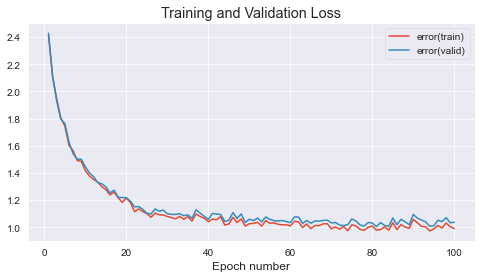

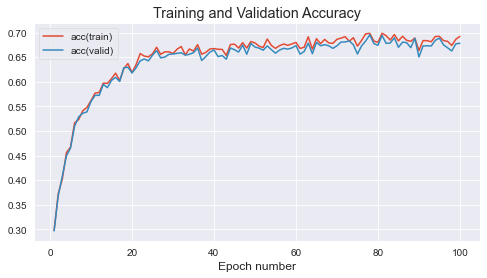

In [51]:
# Reset Data Providor
train_data.reset()
valid_data.reset()

# Setup hyperparameters
learning_rate = 0.05
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialization of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Dropout random state
rng = np.random.RandomState(92019)

# Definition of Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.8),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.7),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    DropoutLayer(rng, incl_prob=0.7),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L1Penalty(0.1))
])

# Definition of error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
stats_ddecf_L2incf, keys_ddecf_L2incf, runtime_ddecf_L2incf, activation_ddecf_L2incf = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(stats_ddecf_L2incf, keys_ddecf_L2incf, runtime_ddecf_L2incf, activation_ddecf_L2incf, 'ddecf_L1incf')

### Fine tuned model 2

## Reporting the results on the test set

In [55]:
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

KeysView(<numpy.lib.npyio.NpzFile object at 0x2afe0fc42340>)


Epoch 1: 6.7s to complete
    error(train)=7.96e-01, acc(train)=7.50e-01, error(valid)=8.44e-01, acc(valid)=7.35e-01


Epoch 2: 6.6s to complete
    error(train)=6.13e-01, acc(train)=7.96e-01, error(valid)=6.73e-01, acc(valid)=7.83e-01


Epoch 3: 6.8s to complete
    error(train)=5.55e-01, acc(train)=8.17e-01, error(valid)=6.20e-01, acc(valid)=7.95e-01


Epoch 4: 6.9s to complete
    error(train)=5.11e-01, acc(train)=8.30e-01, error(valid)=5.83e-01, acc(valid)=8.09e-01


Epoch 5: 6.2s to complete
    error(train)=4.91e-01, acc(train)=8.35e-01, error(valid)=5.57e-01, acc(valid)=8.14e-01


Epoch 6: 6.2s to complete
    error(train)=4.68e-01, acc(train)=8.42e-01, error(valid)=5.43e-01, acc(valid)=8.19e-01


Epoch 7: 7.1s to complete
    error(train)=4.56e-01, acc(train)=8.44e-01, error(valid)=5.39e-01, acc(valid)=8.19e-01


Epoch 8: 7.3s to complete
    error(train)=4.44e-01, acc(train)=8.48e-01, error(valid)=5.20e-01, acc(valid)=8.26e-01


Epoch 9: 7.3s to complete
    error(train)=4.34e-01, acc(train)=8.52e-01, error(valid)=5.17e-01, acc(valid)=8.27e-01


Epoch 10: 7.1s to complete
    error(train)=4.37e-01, acc(train)=8.46e-01, error(valid)=5.18e-01, acc(valid)=8.22e-01


Epoch 11: 6.8s to complete
    error(train)=4.11e-01, acc(train)=8.57e-01, error(valid)=4.95e-01, acc(valid)=8.31e-01


Epoch 12: 6.9s to complete
    error(train)=4.26e-01, acc(train)=8.50e-01, error(valid)=5.06e-01, acc(valid)=8.31e-01


Epoch 13: 7.3s to complete
    error(train)=4.67e-01, acc(train)=8.38e-01, error(valid)=5.58e-01, acc(valid)=8.17e-01


Epoch 14: 7.4s to complete
    error(train)=4.11e-01, acc(train)=8.56e-01, error(valid)=4.99e-01, acc(valid)=8.30e-01


Epoch 15: 6.9s to complete
    error(train)=4.00e-01, acc(train)=8.61e-01, error(valid)=4.89e-01, acc(valid)=8.34e-01


Epoch 16: 7.1s to complete
    error(train)=3.93e-01, acc(train)=8.63e-01, error(valid)=4.84e-01, acc(valid)=8.39e-01


Epoch 17: 6.6s to complete
    error(train)=4.11e-01, acc(train)=8.57e-01, error(valid)=5.05e-01, acc(valid)=8.32e-01


Epoch 18: 7.0s to complete
    error(train)=3.79e-01, acc(train)=8.67e-01, error(valid)=4.72e-01, acc(valid)=8.41e-01


Epoch 19: 7.2s to complete
    error(train)=3.90e-01, acc(train)=8.61e-01, error(valid)=4.81e-01, acc(valid)=8.33e-01


Epoch 20: 6.7s to complete
    error(train)=3.84e-01, acc(train)=8.66e-01, error(valid)=4.80e-01, acc(valid)=8.37e-01


Epoch 21: 7.0s to complete
    error(train)=4.11e-01, acc(train)=8.55e-01, error(valid)=5.05e-01, acc(valid)=8.32e-01


Epoch 22: 7.4s to complete
    error(train)=3.89e-01, acc(train)=8.62e-01, error(valid)=4.88e-01, acc(valid)=8.32e-01


Epoch 23: 6.4s to complete
    error(train)=3.91e-01, acc(train)=8.62e-01, error(valid)=4.82e-01, acc(valid)=8.39e-01


Epoch 24: 6.3s to complete
    error(train)=3.84e-01, acc(train)=8.63e-01, error(valid)=4.81e-01, acc(valid)=8.37e-01


Epoch 25: 6.3s to complete
    error(train)=3.75e-01, acc(train)=8.67e-01, error(valid)=4.79e-01, acc(valid)=8.36e-01


Epoch 26: 6.5s to complete
    error(train)=3.81e-01, acc(train)=8.65e-01, error(valid)=4.83e-01, acc(valid)=8.36e-01


Epoch 27: 6.9s to complete
    error(train)=3.82e-01, acc(train)=8.64e-01, error(valid)=4.78e-01, acc(valid)=8.37e-01


Epoch 28: 7.3s to complete
    error(train)=3.82e-01, acc(train)=8.64e-01, error(valid)=4.85e-01, acc(valid)=8.38e-01


Epoch 29: 7.1s to complete
    error(train)=3.78e-01, acc(train)=8.66e-01, error(valid)=4.82e-01, acc(valid)=8.36e-01


Epoch 30: 7.5s to complete
    error(train)=3.80e-01, acc(train)=8.63e-01, error(valid)=4.90e-01, acc(valid)=8.32e-01


Epoch 31: 7.2s to complete
    error(train)=3.70e-01, acc(train)=8.62e-01, error(valid)=4.76e-01, acc(valid)=8.31e-01


Epoch 32: 6.8s to complete
    error(train)=3.76e-01, acc(train)=8.64e-01, error(valid)=4.79e-01, acc(valid)=8.34e-01


Epoch 33: 7.1s to complete
    error(train)=3.65e-01, acc(train)=8.69e-01, error(valid)=4.74e-01, acc(valid)=8.39e-01


Epoch 34: 6.5s to complete
    error(train)=3.69e-01, acc(train)=8.69e-01, error(valid)=4.73e-01, acc(valid)=8.38e-01


Epoch 35: 6.8s to complete
    error(train)=3.73e-01, acc(train)=8.67e-01, error(valid)=4.79e-01, acc(valid)=8.42e-01


Epoch 36: 7.1s to complete
    error(train)=3.55e-01, acc(train)=8.74e-01, error(valid)=4.66e-01, acc(valid)=8.45e-01


Epoch 37: 6.7s to complete
    error(train)=3.55e-01, acc(train)=8.73e-01, error(valid)=4.67e-01, acc(valid)=8.43e-01


Epoch 38: 7.4s to complete
    error(train)=3.66e-01, acc(train)=8.68e-01, error(valid)=4.76e-01, acc(valid)=8.39e-01


Epoch 39: 7.0s to complete
    error(train)=3.66e-01, acc(train)=8.69e-01, error(valid)=4.74e-01, acc(valid)=8.39e-01


Epoch 40: 6.3s to complete
    error(train)=3.74e-01, acc(train)=8.65e-01, error(valid)=4.85e-01, acc(valid)=8.37e-01


Epoch 41: 6.3s to complete
    error(train)=3.55e-01, acc(train)=8.72e-01, error(valid)=4.71e-01, acc(valid)=8.41e-01


Epoch 42: 6.3s to complete
    error(train)=3.60e-01, acc(train)=8.72e-01, error(valid)=4.63e-01, acc(valid)=8.42e-01


Epoch 43: 6.6s to complete
    error(train)=3.51e-01, acc(train)=8.75e-01, error(valid)=4.59e-01, acc(valid)=8.47e-01


Epoch 44: 7.4s to complete
    error(train)=3.54e-01, acc(train)=8.73e-01, error(valid)=4.62e-01, acc(valid)=8.45e-01


Epoch 45: 7.3s to complete
    error(train)=3.50e-01, acc(train)=8.74e-01, error(valid)=4.69e-01, acc(valid)=8.42e-01


Epoch 46: 7.3s to complete
    error(train)=3.59e-01, acc(train)=8.69e-01, error(valid)=4.75e-01, acc(valid)=8.39e-01


Epoch 47: 7.4s to complete
    error(train)=3.67e-01, acc(train)=8.66e-01, error(valid)=4.83e-01, acc(valid)=8.34e-01


Epoch 48: 7.4s to complete
    error(train)=3.59e-01, acc(train)=8.69e-01, error(valid)=4.73e-01, acc(valid)=8.39e-01


Epoch 49: 7.2s to complete
    error(train)=3.74e-01, acc(train)=8.67e-01, error(valid)=4.90e-01, acc(valid)=8.35e-01


Epoch 50: 6.6s to complete
    error(train)=3.46e-01, acc(train)=8.76e-01, error(valid)=4.64e-01, acc(valid)=8.47e-01


Epoch 51: 6.6s to complete
    error(train)=3.48e-01, acc(train)=8.73e-01, error(valid)=4.61e-01, acc(valid)=8.43e-01


Epoch 52: 6.9s to complete
    error(train)=3.79e-01, acc(train)=8.61e-01, error(valid)=4.93e-01, acc(valid)=8.30e-01


Epoch 53: 6.9s to complete
    error(train)=3.41e-01, acc(train)=8.78e-01, error(valid)=4.54e-01, acc(valid)=8.46e-01


Epoch 54: 6.7s to complete
    error(train)=3.52e-01, acc(train)=8.74e-01, error(valid)=4.73e-01, acc(valid)=8.43e-01


Epoch 55: 7.1s to complete
    error(train)=3.52e-01, acc(train)=8.72e-01, error(valid)=4.63e-01, acc(valid)=8.44e-01


Epoch 56: 7.1s to complete
    error(train)=3.55e-01, acc(train)=8.71e-01, error(valid)=4.71e-01, acc(valid)=8.41e-01


Epoch 57: 6.4s to complete
    error(train)=3.43e-01, acc(train)=8.77e-01, error(valid)=4.70e-01, acc(valid)=8.46e-01


Epoch 58: 6.4s to complete
    error(train)=3.62e-01, acc(train)=8.69e-01, error(valid)=4.84e-01, acc(valid)=8.38e-01


Epoch 59: 7.0s to complete
    error(train)=3.42e-01, acc(train)=8.75e-01, error(valid)=4.66e-01, acc(valid)=8.41e-01


Epoch 60: 7.0s to complete
    error(train)=3.40e-01, acc(train)=8.76e-01, error(valid)=4.64e-01, acc(valid)=8.42e-01


Epoch 61: 7.0s to complete
    error(train)=3.50e-01, acc(train)=8.74e-01, error(valid)=4.73e-01, acc(valid)=8.41e-01


Epoch 62: 7.3s to complete
    error(train)=3.46e-01, acc(train)=8.73e-01, error(valid)=4.71e-01, acc(valid)=8.40e-01


Epoch 63: 7.2s to complete
    error(train)=3.44e-01, acc(train)=8.74e-01, error(valid)=4.71e-01, acc(valid)=8.42e-01


Epoch 64: 7.1s to complete
    error(train)=3.48e-01, acc(train)=8.73e-01, error(valid)=4.70e-01, acc(valid)=8.41e-01


Epoch 65: 6.9s to complete
    error(train)=3.40e-01, acc(train)=8.78e-01, error(valid)=4.58e-01, acc(valid)=8.43e-01


Epoch 66: 7.4s to complete
    error(train)=3.35e-01, acc(train)=8.79e-01, error(valid)=4.57e-01, acc(valid)=8.46e-01


Epoch 67: 6.7s to complete
    error(train)=3.38e-01, acc(train)=8.79e-01, error(valid)=4.58e-01, acc(valid)=8.47e-01


Epoch 68: 6.3s to complete
    error(train)=3.33e-01, acc(train)=8.78e-01, error(valid)=4.61e-01, acc(valid)=8.44e-01


Epoch 69: 6.3s to complete
    error(train)=3.47e-01, acc(train)=8.75e-01, error(valid)=4.68e-01, acc(valid)=8.43e-01


Epoch 70: 6.6s to complete
    error(train)=3.52e-01, acc(train)=8.72e-01, error(valid)=4.68e-01, acc(valid)=8.40e-01


Epoch 71: 6.4s to complete
    error(train)=3.38e-01, acc(train)=8.75e-01, error(valid)=4.63e-01, acc(valid)=8.41e-01


Epoch 72: 6.8s to complete
    error(train)=3.45e-01, acc(train)=8.75e-01, error(valid)=4.65e-01, acc(valid)=8.46e-01


Epoch 73: 7.2s to complete
    error(train)=3.35e-01, acc(train)=8.78e-01, error(valid)=4.61e-01, acc(valid)=8.45e-01


Epoch 74: 7.3s to complete
    error(train)=3.50e-01, acc(train)=8.72e-01, error(valid)=4.76e-01, acc(valid)=8.37e-01


Epoch 75: 7.2s to complete
    error(train)=3.37e-01, acc(train)=8.77e-01, error(valid)=4.67e-01, acc(valid)=8.41e-01


Epoch 76: 7.3s to complete
    error(train)=3.39e-01, acc(train)=8.77e-01, error(valid)=4.65e-01, acc(valid)=8.46e-01


Epoch 77: 7.0s to complete
    error(train)=3.38e-01, acc(train)=8.76e-01, error(valid)=4.57e-01, acc(valid)=8.43e-01


Epoch 78: 6.9s to complete
    error(train)=3.45e-01, acc(train)=8.72e-01, error(valid)=4.72e-01, acc(valid)=8.41e-01


Epoch 79: 6.4s to complete
    error(train)=3.36e-01, acc(train)=8.77e-01, error(valid)=4.59e-01, acc(valid)=8.45e-01


Epoch 80: 6.5s to complete
    error(train)=3.41e-01, acc(train)=8.75e-01, error(valid)=4.60e-01, acc(valid)=8.45e-01


Epoch 81: 6.5s to complete
    error(train)=3.52e-01, acc(train)=8.70e-01, error(valid)=4.86e-01, acc(valid)=8.38e-01


Epoch 82: 6.6s to complete
    error(train)=3.31e-01, acc(train)=8.79e-01, error(valid)=4.59e-01, acc(valid)=8.41e-01


Epoch 83: 7.2s to complete
    error(train)=3.43e-01, acc(train)=8.77e-01, error(valid)=4.67e-01, acc(valid)=8.46e-01


Epoch 84: 6.8s to complete
    error(train)=3.42e-01, acc(train)=8.74e-01, error(valid)=4.70e-01, acc(valid)=8.41e-01


Epoch 85: 6.5s to complete
    error(train)=3.61e-01, acc(train)=8.67e-01, error(valid)=4.98e-01, acc(valid)=8.31e-01


Epoch 86: 6.8s to complete
    error(train)=3.39e-01, acc(train)=8.77e-01, error(valid)=4.62e-01, acc(valid)=8.43e-01


Epoch 87: 7.4s to complete
    error(train)=3.27e-01, acc(train)=8.80e-01, error(valid)=4.58e-01, acc(valid)=8.47e-01


Epoch 88: 7.0s to complete
    error(train)=3.33e-01, acc(train)=8.79e-01, error(valid)=4.56e-01, acc(valid)=8.47e-01


Epoch 89: 6.5s to complete
    error(train)=3.31e-01, acc(train)=8.79e-01, error(valid)=4.61e-01, acc(valid)=8.46e-01


Epoch 90: 6.7s to complete
    error(train)=3.39e-01, acc(train)=8.77e-01, error(valid)=4.71e-01, acc(valid)=8.42e-01


Epoch 91: 7.0s to complete
    error(train)=3.36e-01, acc(train)=8.76e-01, error(valid)=4.70e-01, acc(valid)=8.42e-01


Epoch 92: 6.3s to complete
    error(train)=3.42e-01, acc(train)=8.77e-01, error(valid)=4.70e-01, acc(valid)=8.44e-01


Epoch 93: 6.6s to complete
    error(train)=3.48e-01, acc(train)=8.73e-01, error(valid)=4.73e-01, acc(valid)=8.40e-01


Epoch 94: 7.2s to complete
    error(train)=3.34e-01, acc(train)=8.79e-01, error(valid)=4.63e-01, acc(valid)=8.43e-01


Epoch 95: 6.7s to complete
    error(train)=3.38e-01, acc(train)=8.77e-01, error(valid)=4.65e-01, acc(valid)=8.43e-01


Epoch 96: 6.8s to complete
    error(train)=3.40e-01, acc(train)=8.77e-01, error(valid)=4.70e-01, acc(valid)=8.42e-01


Epoch 97: 6.6s to complete
    error(train)=3.41e-01, acc(train)=8.74e-01, error(valid)=4.74e-01, acc(valid)=8.39e-01


Epoch 98: 6.7s to complete
    error(train)=3.30e-01, acc(train)=8.81e-01, error(valid)=4.67e-01, acc(valid)=8.43e-01


Epoch 99: 6.4s to complete
    error(train)=3.37e-01, acc(train)=8.78e-01, error(valid)=4.70e-01, acc(valid)=8.40e-01


Epoch 100: 6.5s to complete
    error(train)=3.41e-01, acc(train)=8.76e-01, error(valid)=4.66e-01, acc(valid)=8.40e-01


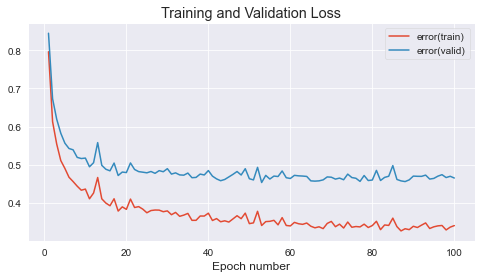

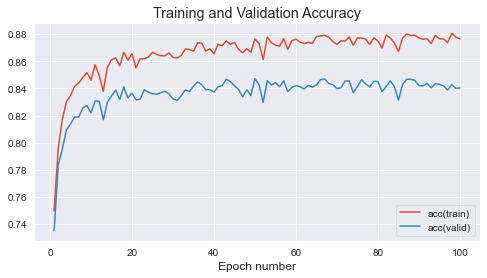

In [56]:
# Reset Data Providor
train_data.reset()

# Setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Definition of the Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, L1Penalty(1e-4)),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init, L1Penalty(1e-4))
])

# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
test_stats, test_keys, test_runtime, test_activation = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, test_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(test_stats, test_keys, test_runtime, test_activation, 'L1_ontest_1e_4')

Epoch 1: 7.3s to complete
    error(train)=6.85e-01, acc(train)=7.81e-01, error(valid)=7.35e-01, acc(valid)=7.62e-01


Epoch 2: 7.6s to complete
    error(train)=5.66e-01, acc(train)=8.12e-01, error(valid)=6.38e-01, acc(valid)=7.92e-01


Epoch 3: 7.5s to complete
    error(train)=4.91e-01, acc(train)=8.33e-01, error(valid)=5.88e-01, acc(valid)=8.05e-01


Epoch 4: 6.9s to complete
    error(train)=4.28e-01, acc(train)=8.52e-01, error(valid)=5.47e-01, acc(valid)=8.19e-01


Epoch 5: 7.1s to complete
    error(train)=4.15e-01, acc(train)=8.54e-01, error(valid)=5.50e-01, acc(valid)=8.16e-01


Epoch 6: 6.3s to complete
    error(train)=3.70e-01, acc(train)=8.66e-01, error(valid)=5.16e-01, acc(valid)=8.29e-01


Epoch 7: 6.6s to complete
    error(train)=3.67e-01, acc(train)=8.67e-01, error(valid)=5.39e-01, acc(valid)=8.22e-01


Epoch 8: 6.6s to complete
    error(train)=3.44e-01, acc(train)=8.75e-01, error(valid)=5.26e-01, acc(valid)=8.29e-01


Epoch 9: 6.9s to complete
    error(train)=3.16e-01, acc(train)=8.84e-01, error(valid)=5.13e-01, acc(valid)=8.32e-01


Epoch 10: 7.4s to complete
    error(train)=3.07e-01, acc(train)=8.86e-01, error(valid)=5.23e-01, acc(valid)=8.28e-01


Epoch 11: 6.7s to complete
    error(train)=3.07e-01, acc(train)=8.84e-01, error(valid)=5.38e-01, acc(valid)=8.31e-01


Epoch 12: 7.1s to complete
    error(train)=2.81e-01, acc(train)=8.93e-01, error(valid)=5.22e-01, acc(valid)=8.33e-01


Epoch 13: 6.5s to complete
    error(train)=2.89e-01, acc(train)=8.91e-01, error(valid)=5.53e-01, acc(valid)=8.31e-01


Epoch 14: 6.7s to complete
    error(train)=2.62e-01, acc(train)=8.99e-01, error(valid)=5.52e-01, acc(valid)=8.34e-01


Epoch 15: 7.1s to complete
    error(train)=2.65e-01, acc(train)=8.97e-01, error(valid)=5.67e-01, acc(valid)=8.28e-01


Epoch 16: 6.7s to complete
    error(train)=2.58e-01, acc(train)=8.99e-01, error(valid)=5.60e-01, acc(valid)=8.28e-01


Epoch 17: 6.6s to complete
    error(train)=2.52e-01, acc(train)=9.01e-01, error(valid)=5.83e-01, acc(valid)=8.27e-01


Epoch 18: 6.6s to complete
    error(train)=2.38e-01, acc(train)=9.06e-01, error(valid)=5.94e-01, acc(valid)=8.33e-01


Epoch 19: 6.9s to complete
    error(train)=2.21e-01, acc(train)=9.11e-01, error(valid)=5.90e-01, acc(valid)=8.33e-01


Epoch 20: 7.4s to complete
    error(train)=2.28e-01, acc(train)=9.09e-01, error(valid)=6.18e-01, acc(valid)=8.31e-01


Epoch 21: 6.3s to complete
    error(train)=2.33e-01, acc(train)=9.08e-01, error(valid)=6.26e-01, acc(valid)=8.27e-01


Epoch 22: 6.7s to complete
    error(train)=2.23e-01, acc(train)=9.10e-01, error(valid)=6.38e-01, acc(valid)=8.29e-01


Epoch 23: 6.4s to complete
    error(train)=2.14e-01, acc(train)=9.15e-01, error(valid)=6.61e-01, acc(valid)=8.29e-01


Epoch 24: 6.5s to complete
    error(train)=2.15e-01, acc(train)=9.13e-01, error(valid)=6.72e-01, acc(valid)=8.23e-01


Epoch 25: 6.8s to complete
    error(train)=2.05e-01, acc(train)=9.17e-01, error(valid)=6.76e-01, acc(valid)=8.29e-01


Epoch 26: 7.5s to complete
    error(train)=2.32e-01, acc(train)=9.09e-01, error(valid)=7.34e-01, acc(valid)=8.17e-01


Epoch 27: 7.5s to complete
    error(train)=1.89e-01, acc(train)=9.23e-01, error(valid)=6.81e-01, acc(valid)=8.29e-01


Epoch 28: 6.9s to complete
    error(train)=1.84e-01, acc(train)=9.24e-01, error(valid)=6.95e-01, acc(valid)=8.29e-01


Epoch 29: 6.3s to complete
    error(train)=1.92e-01, acc(train)=9.22e-01, error(valid)=7.47e-01, acc(valid)=8.28e-01


Epoch 30: 6.3s to complete
    error(train)=2.02e-01, acc(train)=9.18e-01, error(valid)=7.50e-01, acc(valid)=8.19e-01


Epoch 31: 6.5s to complete
    error(train)=1.86e-01, acc(train)=9.25e-01, error(valid)=7.40e-01, acc(valid)=8.28e-01


Epoch 32: 6.5s to complete
    error(train)=1.86e-01, acc(train)=9.24e-01, error(valid)=7.66e-01, acc(valid)=8.22e-01


Epoch 33: 7.0s to complete
    error(train)=1.89e-01, acc(train)=9.22e-01, error(valid)=8.09e-01, acc(valid)=8.18e-01


Epoch 34: 7.3s to complete
    error(train)=1.86e-01, acc(train)=9.25e-01, error(valid)=7.90e-01, acc(valid)=8.26e-01


Epoch 35: 6.7s to complete
    error(train)=1.75e-01, acc(train)=9.30e-01, error(valid)=8.24e-01, acc(valid)=8.24e-01


Epoch 36: 7.3s to complete
    error(train)=1.87e-01, acc(train)=9.23e-01, error(valid)=8.10e-01, acc(valid)=8.19e-01


Epoch 37: 6.9s to complete
    error(train)=1.70e-01, acc(train)=9.30e-01, error(valid)=8.23e-01, acc(valid)=8.23e-01


Epoch 38: 9.1s to complete
    error(train)=1.68e-01, acc(train)=9.32e-01, error(valid)=8.52e-01, acc(valid)=8.23e-01


Epoch 39: 7.7s to complete
    error(train)=1.71e-01, acc(train)=9.30e-01, error(valid)=8.78e-01, acc(valid)=8.18e-01


Epoch 40: 6.8s to complete
    error(train)=1.61e-01, acc(train)=9.34e-01, error(valid)=8.65e-01, acc(valid)=8.24e-01


Epoch 41: 6.6s to complete
    error(train)=1.69e-01, acc(train)=9.31e-01, error(valid)=8.85e-01, acc(valid)=8.21e-01


Epoch 42: 7.4s to complete
    error(train)=1.65e-01, acc(train)=9.32e-01, error(valid)=8.96e-01, acc(valid)=8.25e-01


Epoch 43: 8.5s to complete
    error(train)=1.64e-01, acc(train)=9.33e-01, error(valid)=9.23e-01, acc(valid)=8.22e-01


Epoch 44: 7.2s to complete
    error(train)=1.65e-01, acc(train)=9.33e-01, error(valid)=9.24e-01, acc(valid)=8.21e-01


Epoch 45: 7.1s to complete
    error(train)=1.59e-01, acc(train)=9.35e-01, error(valid)=9.37e-01, acc(valid)=8.23e-01


Epoch 46: 7.8s to complete
    error(train)=1.53e-01, acc(train)=9.38e-01, error(valid)=9.62e-01, acc(valid)=8.24e-01


Epoch 47: 8.0s to complete
    error(train)=1.52e-01, acc(train)=9.38e-01, error(valid)=9.50e-01, acc(valid)=8.25e-01


Epoch 48: 7.1s to complete
    error(train)=1.49e-01, acc(train)=9.39e-01, error(valid)=9.61e-01, acc(valid)=8.22e-01


Epoch 49: 7.5s to complete
    error(train)=1.54e-01, acc(train)=9.37e-01, error(valid)=1.00e+00, acc(valid)=8.20e-01


Epoch 50: 7.2s to complete
    error(train)=1.51e-01, acc(train)=9.39e-01, error(valid)=1.00e+00, acc(valid)=8.23e-01


Epoch 51: 6.8s to complete
    error(train)=1.48e-01, acc(train)=9.39e-01, error(valid)=1.00e+00, acc(valid)=8.22e-01


Epoch 52: 6.9s to complete
    error(train)=1.52e-01, acc(train)=9.38e-01, error(valid)=1.04e+00, acc(valid)=8.21e-01


Epoch 53: 6.6s to complete
    error(train)=1.59e-01, acc(train)=9.37e-01, error(valid)=1.04e+00, acc(valid)=8.21e-01


Epoch 54: 6.6s to complete
    error(train)=1.54e-01, acc(train)=9.38e-01, error(valid)=1.07e+00, acc(valid)=8.16e-01


Epoch 55: 7.9s to complete
    error(train)=1.49e-01, acc(train)=9.40e-01, error(valid)=1.07e+00, acc(valid)=8.21e-01


Epoch 56: 8.3s to complete
    error(train)=1.53e-01, acc(train)=9.39e-01, error(valid)=1.11e+00, acc(valid)=8.19e-01


Epoch 57: 7.9s to complete
    error(train)=1.51e-01, acc(train)=9.40e-01, error(valid)=1.09e+00, acc(valid)=8.18e-01


Epoch 58: 7.6s to complete
    error(train)=1.39e-01, acc(train)=9.43e-01, error(valid)=1.06e+00, acc(valid)=8.19e-01


Epoch 59: 8.4s to complete
    error(train)=1.43e-01, acc(train)=9.42e-01, error(valid)=1.08e+00, acc(valid)=8.18e-01


Epoch 60: 7.8s to complete
    error(train)=1.43e-01, acc(train)=9.44e-01, error(valid)=1.10e+00, acc(valid)=8.22e-01


Epoch 61: 7.9s to complete
    error(train)=1.45e-01, acc(train)=9.42e-01, error(valid)=1.13e+00, acc(valid)=8.16e-01


Epoch 62: 8.1s to complete
    error(train)=1.37e-01, acc(train)=9.44e-01, error(valid)=1.11e+00, acc(valid)=8.17e-01


Epoch 63: 9.0s to complete
    error(train)=1.34e-01, acc(train)=9.45e-01, error(valid)=1.14e+00, acc(valid)=8.23e-01


Epoch 64: 6.8s to complete
    error(train)=1.47e-01, acc(train)=9.42e-01, error(valid)=1.18e+00, acc(valid)=8.19e-01


Epoch 65: 7.0s to complete
    error(train)=1.35e-01, acc(train)=9.46e-01, error(valid)=1.20e+00, acc(valid)=8.21e-01


Epoch 66: 7.3s to complete
    error(train)=1.44e-01, acc(train)=9.42e-01, error(valid)=1.22e+00, acc(valid)=8.19e-01


Epoch 67: 7.5s to complete
    error(train)=1.39e-01, acc(train)=9.46e-01, error(valid)=1.23e+00, acc(valid)=8.17e-01


Epoch 68: 8.0s to complete
    error(train)=1.51e-01, acc(train)=9.42e-01, error(valid)=1.22e+00, acc(valid)=8.15e-01


Epoch 69: 7.5s to complete
    error(train)=1.44e-01, acc(train)=9.44e-01, error(valid)=1.27e+00, acc(valid)=8.19e-01


Epoch 70: 7.6s to complete
    error(train)=1.33e-01, acc(train)=9.48e-01, error(valid)=1.25e+00, acc(valid)=8.19e-01


Epoch 71: 7.1s to complete
    error(train)=1.40e-01, acc(train)=9.45e-01, error(valid)=1.25e+00, acc(valid)=8.13e-01


Epoch 72: 7.0s to complete
    error(train)=1.46e-01, acc(train)=9.43e-01, error(valid)=1.28e+00, acc(valid)=8.15e-01


Epoch 73: 6.9s to complete
    error(train)=1.50e-01, acc(train)=9.41e-01, error(valid)=1.29e+00, acc(valid)=8.15e-01


Epoch 74: 7.6s to complete
    error(train)=1.21e-01, acc(train)=9.51e-01, error(valid)=1.34e+00, acc(valid)=8.18e-01


Epoch 75: 7.2s to complete
    error(train)=1.39e-01, acc(train)=9.46e-01, error(valid)=1.31e+00, acc(valid)=8.16e-01


Epoch 76: 6.7s to complete
    error(train)=1.27e-01, acc(train)=9.50e-01, error(valid)=1.29e+00, acc(valid)=8.20e-01


Epoch 77: 8.0s to complete
    error(train)=1.31e-01, acc(train)=9.47e-01, error(valid)=1.35e+00, acc(valid)=8.20e-01


Epoch 78: 7.1s to complete
    error(train)=1.29e-01, acc(train)=9.49e-01, error(valid)=1.32e+00, acc(valid)=8.17e-01


Epoch 79: 6.9s to complete
    error(train)=1.25e-01, acc(train)=9.51e-01, error(valid)=1.32e+00, acc(valid)=8.18e-01


Epoch 80: 7.4s to complete
    error(train)=1.38e-01, acc(train)=9.46e-01, error(valid)=1.37e+00, acc(valid)=8.16e-01


Epoch 81: 7.4s to complete
    error(train)=1.30e-01, acc(train)=9.48e-01, error(valid)=1.35e+00, acc(valid)=8.14e-01


Epoch 82: 7.1s to complete
    error(train)=1.26e-01, acc(train)=9.49e-01, error(valid)=1.31e+00, acc(valid)=8.21e-01


Epoch 83: 6.4s to complete
    error(train)=1.30e-01, acc(train)=9.49e-01, error(valid)=1.38e+00, acc(valid)=8.22e-01


Epoch 84: 7.1s to complete
    error(train)=1.33e-01, acc(train)=9.47e-01, error(valid)=1.39e+00, acc(valid)=8.16e-01


Epoch 85: 7.0s to complete
    error(train)=1.19e-01, acc(train)=9.53e-01, error(valid)=1.41e+00, acc(valid)=8.20e-01


Epoch 86: 6.8s to complete
    error(train)=1.18e-01, acc(train)=9.53e-01, error(valid)=1.38e+00, acc(valid)=8.20e-01


Epoch 87: 7.1s to complete
    error(train)=1.46e-01, acc(train)=9.44e-01, error(valid)=1.46e+00, acc(valid)=8.13e-01


Epoch 88: 7.1s to complete
    error(train)=1.23e-01, acc(train)=9.52e-01, error(valid)=1.46e+00, acc(valid)=8.16e-01


Epoch 89: 7.0s to complete
    error(train)=1.19e-01, acc(train)=9.53e-01, error(valid)=1.47e+00, acc(valid)=8.14e-01


Epoch 90: 7.3s to complete
    error(train)=1.38e-01, acc(train)=9.48e-01, error(valid)=1.45e+00, acc(valid)=8.18e-01


Epoch 91: 7.4s to complete
    error(train)=1.28e-01, acc(train)=9.52e-01, error(valid)=1.49e+00, acc(valid)=8.17e-01


Epoch 92: 6.8s to complete
    error(train)=1.25e-01, acc(train)=9.52e-01, error(valid)=1.49e+00, acc(valid)=8.17e-01


Epoch 93: 6.7s to complete
    error(train)=1.32e-01, acc(train)=9.50e-01, error(valid)=1.50e+00, acc(valid)=8.14e-01


Epoch 94: 6.6s to complete
    error(train)=1.29e-01, acc(train)=9.50e-01, error(valid)=1.48e+00, acc(valid)=8.15e-01


Epoch 95: 6.6s to complete
    error(train)=1.45e-01, acc(train)=9.46e-01, error(valid)=1.53e+00, acc(valid)=8.15e-01


Epoch 96: 6.7s to complete
    error(train)=1.14e-01, acc(train)=9.55e-01, error(valid)=1.60e+00, acc(valid)=8.14e-01


Epoch 97: 7.4s to complete
    error(train)=1.15e-01, acc(train)=9.55e-01, error(valid)=1.52e+00, acc(valid)=8.19e-01


Epoch 98: 6.9s to complete
    error(train)=1.15e-01, acc(train)=9.55e-01, error(valid)=1.55e+00, acc(valid)=8.17e-01


Epoch 99: 7.4s to complete
    error(train)=1.34e-01, acc(train)=9.51e-01, error(valid)=1.57e+00, acc(valid)=8.12e-01


Epoch 100: 5.9s to complete
    error(train)=1.19e-01, acc(train)=9.54e-01, error(valid)=1.54e+00, acc(valid)=8.14e-01


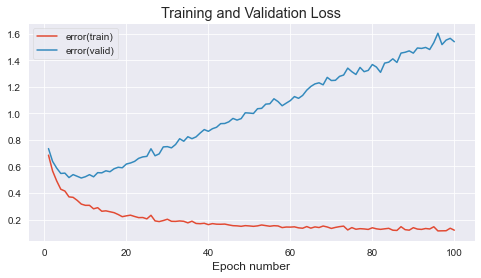

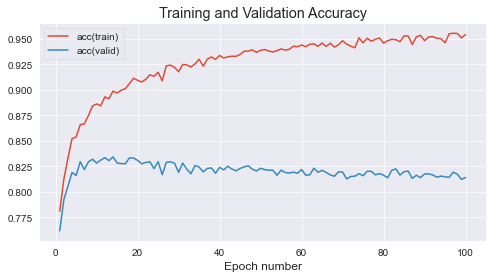

In [57]:
# Reset Data Providor
train_data.reset()
test_data.reset()

# Setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128 # 128 Hidden Units fed into the ReLu activation function

# Initialisation of weights and biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Definition of the Neural Network Model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Definition of the error function
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

# Remember to use notebook=False when you write a script to be run in a terminal
test_stats, test_keys, test_runtime, test_activation = main_train_model_and_plot_stats(
    model, error, learning_rule, train_data, test_data, num_epochs, stats_interval, notebook=True)

# Output results for further anlysis
export_values(test_stats, test_keys, test_runtime, test_activation, 'baseline_ontest')